In [ ]:
import pandas as pd
import xml.etree.ElementTree as ET
import os
from urllib.request import urlretrieve as download
from glob import glob as g
from Bio.Blast import NCBIWWW, NCBIXML
from mypdb import PDB_file as mypdb
from Bio.Blast.Applications import NcbipsiblastCommandline
from time import time as t
from tqdm import tqdm


import glob
import xml.etree.ElementTree as ET
from collections import defaultdict

import re
import MDAnalysis as mda
from time import time as t

In [ ]:
#Class to handle and download the hits from a blast search



def merge_dicts(dict1, dict2):
    for k2, v2 in dict2.items():
        if k2 in dict1:
            if isinstance(dict1[k2], list):
                dict1[k2].append(v2)
            else:
                dict1[k2] = [dict1[k2], v2]
        else:
            print(f"New Key : {k2}")
            dict1[k2] = v2
    return dict1

class hit:
    def __init__(self, xml_hit):
        self.hit_num = xml_hit[0].text
        pdb_info = xml_hit[1].text.split("|")[1:]
        self.pdb_id = pdb_info[0]
        self.pdb_chain = pdb_info[1]
        self.description = xml_hit[2].text
        data = [[y.tag.replace("Hsp_", ""), y.text] for y in xml_hit[5][0]]
        self.data = dict(data)
        self.pdb = None
        self._not_exists = False

    @staticmethod
    def download2(code, pdir=None):
        base_url = "https://files.rcsb.org/download"
        pdb_url = f"{base_url}/{code}.pdb"
        f_p = os.path.join(pdir, f"{code}.pdb")
        try:
            download(pdb_url, f_p)
            return f_p  # Return the file path if succeeded
        except Exception:
            print(f"File {code} not found.")
            return None  # Return None if failed

    def _assign(self, f_p):
        self.pdb_path = f_p
        self.pdb = mypdb(f_p)
        
    def check_for_pdb(self, pdir=None):
        if pdir is None:
            pdir = "./pdbs/"
        elif pdir[-1] != "/":
            pdir += "/"
        if not os.path.isdir(pdir):
            os.makedirs(pdir, exist_ok=True)
        matches = g(pdir + f"{self.pdb_id}*")
        if matches:
            if not self.pdb:
                self._assign(matches[0])
            return True
        else:
            return False

In [ ]:
#Class to handle the blast search
class blast:
    def __init__(self, sequence, name, database, path, program="blastp", hitlen=10000):
        self.sequence = sequence
        self.program = program
        self.database = database
        self.path = path
        self.name = name
        self.hitlen = hitlen

        if program == "blastp" and (self.path and os.path.isfile(self.path)):
            self.parse_search()
        elif program == "psiblast":
            self.psiblast_search()
        else:
            self.bsearch()

    def bsearch(self):
        # Perform the initial BLASTP search
        if self.program == "blastp":
            print("Searching BLASTP...")
            t1 = t()
            self.results = NCBIWWW.qblast(self.program, self.database, self.sequence, hitlist_size=self.hitlen)
            t2 = t()
            print(f"BLASTP took {round(t2-t1,4)} seconds")
            if not self.path:
                self.path = f"{self.name}-blast.xml"
            with open(self.path, "w") as output_xml:
                output_xml.write(self.results.read())
            self.parse_search()

    def psiblast_search(self):
        # Run local PSI-BLAST using NcbipsiblastCommandline
        print(f"Running PSI-BLAST on {self.name}...")
        input_fasta = f"{self.name}.fasta"
        with open(input_fasta, "w") as f:
            f.write(f">query\n{self.sequence}\n")

        psiblast_cline = NcbipsiblastCommandline(
            query=input_fasta,
            db="/home/marmatt/ncbi-blast-2.16.0+/bin/pdbaa",
            evalue=10,
            num_iterations=3,
            out_ascii_pssm=f"{self.name}.pssm",
            out=f"{self.name}-psiblast.xml",
            outfmt=5
        )
        stdout, stderr = psiblast_cline()
        if stderr:
            print(f"PSI-BLAST ERROR: {stderr}")
        else:
            print("PSI-BLAST search completed.")
            self.parse_search(xml_file=f"{self.name}-psiblast.xml")

    def parse_search(self, xml_file=None):
        xml_file = xml_file or self.path
        if not xml_file:
            raise Exception("No XML file path provided.")
        t1 = t()
        tree = ET.parse(xml_file)
        iteration = tree.findall("./BlastOutput_iterations/Iteration/")
        self.query_length = iteration[3].text
        hits = [hit(x) for x in iteration[-2]] #returns hit objects
        self.hits = hits
        mega_dict = hits[0].data
        for x in hits[1:]:
            mega_dict = merge_dicts(mega_dict, x.data)
        mega_dict["PDB ID"] = [x.pdb_id for x in hits]
        mega_dict["Chain"] = [x.pdb_chain for x in hits]
        mega_dict["Description"] = [x.description for x in hits]
        self.df = pd.DataFrame.from_dict(mega_dict)
        print(self.df)
        t2 = t()
        print(f"Time taken to parse {t2-t1}")
    
    def download_pdbs(self, pdir=None):
        default_dir = "./PDBs"
        pdir = os.path.abspath(pdir if pdir else default_dir)
        if not os.path.isdir(pdir):
            os.makedirs(pdir, exist_ok=True)
        
        files = [os.path.splitext(f)[0] for f in os.listdir(pdir)]
        hit_bar = tqdm(self.hits, desc="Processing Hits")
        
        for x in hit_bar:
            if x.pdb_id not in files:
                hit_bar.set_description(f"Downloading {x}")
                
                try:
                    file_path = x.download2(x.pdb_id, pdir=pdir)

                    if file_path:
                        x._assign(file_path)
                    else:
                        # In case download2 does not return a valid path
                        raise Exception("Download failed")
                except Exception as e:
                    # Print a message if download fails or file path is invalid
                    print(f"Structure {x.pdb_id} was not found...")

## Actually running the blast search

In [ ]:

"""
Here we perform a blast search on:
 1.   The BRAF monomer
"""
with open("./fastas.txt") as f:
    fastas = f.readlines()

braf_fasta = fastas[1]
name = "braf"

# Directory for storing blast search results
output_dir = "./blast_search"
# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

res_path = os.path.join(output_dir, f"{name}-blast.xml")  # Path for the results file

# Check for saved results in the specified directory
if os.path.exists(res_path):
    bs = blast(braf_fasta, name, database="pdb", path=res_path)
else:
    bs = blast(braf_fasta, name, database="pdb", path=None)

bs.download_pdbs()

## Counting the number of pdb files in the directory

In [ ]:


import glob
def count_pdb_files(directory):
    # Ensure the directory path ends with a slash
    directory = os.path.join(directory, '')

    # Use glob to find all .pdb files in the directory
    pdb_files = glob.glob(os.path.join(directory, '*.pdb'))

    # Return the count of .pdb files
    return len(pdb_files)

# Specify the directory
pdb_directory = 'PDBs'

# Get the count of PDB files
pdb_count = count_pdb_files(pdb_directory)

print(f"There are {pdb_count} PDB files in the directory '{pdb_directory}'.")

## Counting the number of pdb hits in the xml file and checking which ones have not been downloaded


In [ ]:


def count_pdb_files(directory):
    # Use glob to find all .pdb files in the directory
    pdb_files = glob.glob(os.path.join(directory, '*.pdb'))

    # Extract the base filenames (without extension) to compare with PDB IDs
    pdb_file_ids = {os.path.splitext(os.path.basename(f))[0] for f in pdb_files}

    return pdb_file_ids

def find_unique_and_duplicate_pdb_hit_ids(xml_file):
    # Parse the XML file
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Dictionary to count occurrences of each PDB hit ID
    hit_id_counts = defaultdict(int)

    # Iterate over all Hit elements in the XML
    for hit in root.findall('.//Hit'):
        # Extract the Hit_id text
        hit_id = hit.find('Hit_id').text

        # Assuming the Hit_id format is 'pdb|PDB_ID|Chain', extract the PDB_ID
        pdb_id = hit_id.split('|')[1]

        # Increment the count for this PDB_ID
        hit_id_counts[pdb_id] += 1

    # Find all PDB IDs (unique and duplicates)
    all_hit_ids = set(hit_id_counts.keys())

    return all_hit_ids

# Specify the directory and XML file
pdb_directory = 'PDBs'
xml_file = 'braf-blast.xml'

# Get the PDB file IDs from the directory
pdb_file_ids = count_pdb_files(pdb_directory)

# Get all PDB hit IDs from the XML
all_pdb_ids = find_unique_and_duplicate_pdb_hit_ids(xml_file)

# Calculate the number of total PDB hits
total_pdb_hits = len(all_pdb_ids)

# Find PDB IDs in XML that are not in the directory
missing_pdb_ids = all_pdb_ids - pdb_file_ids

print(f"There are {total_pdb_hits} total PDB hits in the file '{xml_file}'.")
print(f"There are {len(missing_pdb_ids)} PDB IDs in the XML not found in the directory '{pdb_directory}':")
print(missing_pdb_ids)


## Here we are stripping the downloaded pdb files to only contain the chain of interest


In [ ]:
import os
from glob import glob
import re
import MDAnalysis as mda
from time import time as t
!ls
def sglob(fp, absolute=True):
    fps = sorted(glob(fp))
    if absolute:
        fps = [os.path.abspath(f) for f in fps]
    return fps

def strip_to_chain(pdb_file, chain_ID):
    u = mda.Universe(pdb_file)
    print(f"Loaded trajectory from {pdb_file} with {len(u.atoms)} atoms.")

    chain = u.select_atoms(f"protein and chainID {chain_ID}")
    if len(chain) == 0:
        print(f"Chain {chain_ID} not found in {pdb_file}.")
        return None
    return chain

def post_process(fname):
    with open(fname, "r") as f_o:
        initial_lines = f_o.readlines()

    print(f"File {fname} before post_process, first few lines:")
    print("".join(initial_lines[:20]))

    final_lines = initial_lines[-2:].copy()
    no_ter = [line for line in initial_lines if line[:3] != "TER" or line in final_lines]

    if len(no_ter) != len(initial_lines):
        with open(fname, "w") as f_o:
            print(f"Rewriting {fname}, lines reduced from {len(initial_lines)} to {len(no_ter)}")
            f_o.write("".join(no_ter))

    print(f"File {fname} after post_process, first few lines:")
    with open(fname, "r") as f_r:
        print("".join(f_r.readlines()[:20]))

def parse_xml(xml_file):
    hit_id = re.compile(r"<Hit_id>(.*?)<.Hit_id>")
    with open(xml_file, "r") as f:
        text = f.read()
        results = [h.split("|")[1:] for h in hit_id.findall(text)]
        pdb_chain_dict = {}
        for r in results:
            pdb_chain_dict[r[0]+f"_{r[1]}"] = r[1]
    return pdb_chain_dict

def get_pdb_id(fp):
    fp = fp.rsplit(".", 1)[0]
    if "/" in fp:
        fp = fp.rsplit("/", 1)[1]
    return fp

def target_name(fp, target_dir, chain):
    orig_path, file_name = fp.rsplit("/", 1)
    fp = fp.replace(orig_path, target_dir)
    fp = fp.split(".")[0] + f"_{chain}.pdb"
    return fp

def find_pdb_file(PDB_chain_id, files):
    print(files)
    if "_" in PDB_chain_id:
        PDB_id = PDB_chain_id.split("_")[0]
    assert len(PDB_id) == 4
    for f in files:
        filename = os.path.basename(f).split('.')[0]
        if filename.startswith(PDB_id):
            print(f"Found file: {f} for PDB ID: {PDB_id}")
            return f

print("BEGIN")
t1 = t()
xml = "braf-blast.xml"
pdb_dir = "PDBs"
target_dir = "Results/activation_segments/unaligned"

# Ensure the target directory exists
os.makedirs(target_dir, exist_ok=True)

xml_chain_dict = parse_xml(xml)
print(xml_chain_dict)

pdb_files = sorted(sglob("PDBs/*.pdb"))
print(pdb_files)
keys = sorted([*xml_chain_dict.keys()], key=get_pdb_id)

print(keys)
files = [find_pdb_file(k, pdb_files) for k in keys]
print(files)
chain_IDs = [xml_chain_dict[k] for k in keys]
print(len(chain_IDs))

valid_file_chain_pairs = [(f, c) for f, c in zip(files, chain_IDs) if f is not None]
print(len(valid_file_chain_pairs))
new_file_paths = [target_name(f, target_dir, c) for f, c in valid_file_chain_pairs]
print(new_file_paths)
file_paths = [f for f, c in valid_file_chain_pairs]
print(file_paths)
print(len(file_paths))

for (fp, chain_ID, tp) in zip(file_paths, chain_IDs, new_file_paths):
    if fp is not None:
        try:
            print(fp, chain_ID, tp)
            chain = strip_to_chain(fp, chain_ID)
            if chain is not None:
                with mda.Writer(tp) as w:
                    w.write(chain)
                post_process(tp)
        except Exception as e:
            print(f"An error occurred while processing {fp} with chain {chain_ID}: {e}")
        
t2 = t()
t_t = round(t2 - t1, 3) // 60
t_t = str((t_t // 60)) + ":" + str(t_t % 60)
print(f"Time taken {t_t} for sequential processing")


## Counting again how many pdb files are in the directory after stripping the chains

In [ ]:
import glob

def count_pdb_files(directory):
    # Ensure the directory path ends with a slash
    directory = os.path.join(directory, '')

    # Use glob to find all .pdb files in the directory
    pdb_files = glob.glob(os.path.join(directory, '*.pdb'))

    # Return the count of .pdb files
    return len(pdb_files)

# Specify the directory
pdb_directory = 'Results/activation_segments/unaligned'

# Get the count of PDB files
pdb_count = count_pdb_files(pdb_directory)

print(f"There are {pdb_count} PDB files in the directory '{pdb_directory}'.")

In [ ]:
#Extracting the full sequence from the pdb files, checking if there are any non-natural amino acids and substituting them and selecting only sequences with a maximum gap length of 4 amino acids to be reconstructed
from Bio.PDB import PDBParser, PPBuilder
from Bio.SeqUtils import seq1
from glob import glob
from tqdm import tqdm
import os

def substitute_non_natural_amino_acid(residue, aligned_atom, index):
    """Substitute non-natural amino acids with their natural counterparts."""
    substitutions = {
        'X': 'G',  # Glycine
        'B': 'N',  # Asparagine
        'Z': 'Q',  # Glutamine
        'J': 'L'   # Leucine
    }
    
    if residue == 'X':
        # Check if 'X' is surrounded by missing amino acids in aligned_atom
        if index > 0 and aligned_atom[index - 1] == '-':
            return residue
        if index < len(aligned_atom) - 1 and aligned_atom[index + 1] == '-':
            return residue

    return substitutions.get(residue, residue)

def extract_seqres_sequence(pdb_file):
    """Extract SEQRES sequences for each chain from a PDB file."""
    seq_dict = {}
    with open(pdb_file, "r") as file:
        lines = file.readlines()

    current_chain = None
    current_seq = []

    for line in lines:
        if line.startswith("SEQRES"):
            parts = line.split()
            chain_id = parts[2]
            if chain_id != current_chain:
                if current_chain is not None:
                    seq_dict[current_chain] = ''.join(seq1(residue) for residue in current_seq)
                current_chain = chain_id
                current_seq = []
            current_seq.extend(parts[4:])

    if current_chain is not None:
        seq_dict[current_chain] = ''.join(seq1(residue) for residue in current_seq)

    return seq_dict

def extract_atom_sequence(pdb_file, chain_id):
    """Extract sequence from atomic coordinates for a specific chain."""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('PDB', pdb_file)
    
    for model in structure:
        chain = model[chain_id]
        
        ppb = PPBuilder()
        sequence = ''
        for pp in ppb.build_peptides(chain):
            sequence += pp.get_sequence()
        return sequence
    return None

def find_motif_indices(sequence, motif):
    """Find the start index of a motif in a sequence."""
    index = sequence.find(motif)
    return index if index != -1 else None

def align_and_highlight_gaps(seqres_segment, atom_segment):
    """Align SEQRES and ATOM segments and highlight gaps in ATOM."""
    aligned_seqres = ''
    aligned_atom = ''
    atom_index = 0
    max_gap_length = 0
    current_gap_length = 0

    for res_seqres in seqres_segment:
        if atom_index < len(atom_segment) and res_seqres == atom_segment[atom_index]:
            aligned_seqres += res_seqres
            aligned_atom += atom_segment[atom_index]
            atom_index += 1
            current_gap_length = 0
        else:
            aligned_seqres += res_seqres
            aligned_atom += '-'
            current_gap_length += 1
            max_gap_length = max(max_gap_length, current_gap_length)

    return aligned_seqres, aligned_atom, max_gap_length

def main():
    target_dir = "Results/activation_segments/unaligned"
    pdb_dir = "PDBs"
    fasta_output_file = "seqres_sequences.fasta"  # File to store full sequences
    text_output_file = "seqres_info.txt"
    aligned_sequences = {}
    satisfying_structures_count = 0

    pdb_files = glob(os.path.join(target_dir, "*.pdb"))

    with open(text_output_file, "w") as text_output, open(fasta_output_file, "w") as fasta_output:
        for pdb_file in tqdm(pdb_files, desc="Processing PDB files"):
            pdb_name = os.path.basename(pdb_file)
            pdb_id, chain_id_file = os.path.splitext(pdb_name)[0].split('_')
            chain_id = chain_id_file

            full_pdb_path = os.path.join(pdb_dir, pdb_id + '.pdb')
            if not os.path.isfile(full_pdb_path):
                print(f"Corresponding full PDB for {pdb_id} not found.")
                continue

            seqres_seqs = extract_seqres_sequence(full_pdb_path)
            atom_seq = extract_atom_sequence(full_pdb_path, chain_id)

            if chain_id in seqres_seqs and atom_seq:
                seqres_sequence = seqres_seqs[chain_id]
                seqres_dfg_index = find_motif_indices(seqres_sequence, 'DFG')
                seqres_ape_index = find_motif_indices(seqres_sequence, 'APE')
                atom_dfg_index = find_motif_indices(atom_seq, 'DFG')
                atom_ape_index = find_motif_indices(atom_seq, 'APE')

                # Determine the start and end indices for the segments
                if None not in [seqres_dfg_index, seqres_ape_index, atom_dfg_index, atom_ape_index]:
                    seqres_start = min(seqres_dfg_index, seqres_ape_index)
                    seqres_end = max(seqres_dfg_index + 3, seqres_ape_index + 3)
                    atom_start = min(atom_dfg_index, atom_ape_index)
                    atom_end = max(atom_dfg_index + 3, atom_ape_index + 3)

                    seqres_segment = seqres_sequence[seqres_start:seqres_end]
                    atom_segment = atom_seq[atom_start:atom_end]

                    aligned_seqres, aligned_atom, max_gap_length = align_and_highlight_gaps(seqres_segment, atom_segment)
                    
                    # Check for differences and substitute non-natural amino acids
                    exclude_due_to_non_natural_diff = False
                    corrected_seqres = ''
                    for index, (res_seqres, res_atom) in enumerate(zip(aligned_seqres, aligned_atom)):
                        if res_seqres != res_atom:
                            corrected_residue = substitute_non_natural_amino_acid(res_seqres, aligned_atom, index)
                            corrected_seqres += corrected_residue
                            if corrected_residue != res_seqres:
                                print(f"Substituting non-natural amino acid '{res_seqres}' with '{corrected_residue}' in SEQRES for {pdb_id}_{chain_id}.")
                        else:
                            corrected_seqres += res_seqres

                    if not exclude_due_to_non_natural_diff and max_gap_length <= 4:
                        satisfying_structures_count += 1
                        info = (f"Aligned Sequences for {pdb_id}_{chain_id}: (Max gap length: {max_gap_length})\n"
                                f"SEQRES Segment: {corrected_seqres}\n"
                                f"ATOM Segment:   {aligned_atom}\n\n")
                        print(info)
                        text_output.write(info)
                        
                        aligned_sequences[f"{pdb_id}_{chain_id}_SEQRES"] = corrected_seqres
                        aligned_sequences[f"{pdb_id}_{chain_id}_ATOM"] = aligned_atom

                        # Write full SEQRES and ATOM sequences to the FASTA file
                        fasta_output.write(f">{pdb_id}_{chain_id}_SEQRES\n{seqres_sequence}\n")
                        fasta_output.write(f">{pdb_id}_{chain_id}_ATOM\n{atom_seq}\n")
                    else:
                        exclusion_msg = f"Excluding {pdb_id}_{chain_id} due to gap length: {max_gap_length} or non-natural amino acid difference.\n"
                        print(exclusion_msg)
                        text_output.write(exclusion_msg)
                else:
                    motif_msg = f"Motifs not found in {pdb_id}_{chain_id}.\n"
                    print(motif_msg)
                    text_output.write(motif_msg)
            else:
                chain_msg = f"Chain {chain_id} not found in SEQRES of {pdb_id} or no atomic sequence available.\n"
                print(chain_msg)
                text_output.write(chain_msg)
                
        count_msg = f"Total structures satisfying the condition: {satisfying_structures_count}"
        text_output.write(count_msg)
        print(count_msg)

if __name__ == '__main__':
    main()


In [ ]:
#COunting how many seqences are in the fasta file
def count_total_pdb_ids(file_path):
    total_pdb_ids = 0

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('>'):
                total_pdb_ids += 1

    print(f"Total number of PDB IDs: {int(total_pdb_ids/2)} in {file_path}") #here we divide by 2 because we have two lines per PDB ID

# Provide the path to your seqres_sequence.fasta file
file_path = "seqres_sequences.fasta"
count_total_pdb_ids(file_path)


In [ ]:
#Code to use MODELLER to reconstruct the sequences that have a gap length of 4 or less, if there are no differences between the SEQRES and ATOM sequences, the original PDB file is copied to the target directory
# FIX was to eliminate remarks from the pdb file
import os
import shutil
from Bio.PDB import PDBParser, PPBuilder
from modeller import *
from modeller.automodel import *

def read_fasta_sequences(fasta_file):
    """Read sequences from a FASTA file into a dictionary."""
    sequences = {}
    with open(fasta_file, "r") as f:
        lines = f.readlines()
        header = None
        sequence = []
        for line in lines:
            line = line.strip()
            if line.startswith(">"):
                if header:
                    sequences[header] = ''.join(sequence)
                header = line[1:]
                sequence = []
            else:
                sequence.append(line)
        if header:
            sequences[header] = ''.join(sequence)
    return sequences

def extract_atom_sequence(pdb_file):
    """Extract sequence from atomic coordinates for the first chain found in the PDB file."""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('PDB', pdb_file)
    
    for model in structure:
        for chain in model:
            ppb = PPBuilder()
            sequence = ''
            for pp in ppb.build_peptides(chain):
                sequence += pp.get_sequence()
            return str(sequence)
    return None

def find_motif_indices(sequence, motif):
    """Find the start index of a motif in a sequence."""
    index = sequence.find(motif)
    return index if index != -1 else None

def reconstruct_with_modeller(pdb_chain_id, pdb_path, target_path, full_sequence, atom_sequence):
    print(f"Processing {pdb_chain_id}")

    # Find indices of the DFG and APE motifs
    seqres_dfg_index = find_motif_indices(full_sequence, 'DFG')
    seqres_ape_index = find_motif_indices(full_sequence, 'APE')
    atom_dfg_index = find_motif_indices(atom_sequence, 'DFG')
    atom_ape_index = find_motif_indices(atom_sequence, 'APE')

    # Determine if reconstruction is needed
    if None not in [seqres_dfg_index, seqres_ape_index, atom_dfg_index, atom_ape_index]:
        seqres_start = min(seqres_dfg_index, seqres_ape_index)
        seqres_end = max(seqres_dfg_index + 3, seqres_ape_index + 3)
        atom_start = min(atom_dfg_index, atom_ape_index)
        atom_end = max(atom_dfg_index + 3, atom_ape_index + 3)

        seqres_segment = full_sequence[seqres_start:seqres_end]
        atom_segment = atom_sequence[atom_start:atom_end]

        # Check for differences in the segment
        if seqres_segment != atom_segment:
            print(f"Reconstructing full sequence for {pdb_chain_id} using MODELLER")

            # Setting up MODELLER
            env = environ()
            aln = alignment(env)
            
            # Read the structure to work on
            mdl = model(env, file=pdb_path)
            aln.append_model(mdl, align_codes='template', atom_files=pdb_path)

            # Append the full target sequence
            aln.append_sequence(full_sequence)
            aln[-1].code = 'target'
            
            # Perform the alignment
            aln.align2d(max_gap_length=50)

            # Create AutoModel object and build models
            a = automodel(env, alnfile=aln, knowns='template', sequence='target')
            a.starting_model = 1
            a.ending_model = 1
            
            # Build the model
            a.make()
            
            # Save the best model to the target directory
            model_path = os.path.join(target_path, f"{pdb_chain_id}_filled.pdb")
            os.rename(a.outputs[0]['name'], model_path)
            print(f"Reconstruction completed for {pdb_chain_id}. File saved at {model_path}")

            # Post-process to remove REMARK lines
            remove_remark_lines(model_path)
        else:
            # No reconstruction needed, copy original PDB
            shutil.copy(pdb_path, os.path.join(target_path, f"{pdb_chain_id}.pdb"))
            print(f"No differences found for {pdb_chain_id}. Original PDB copied to target directory.")
    else:
        print(f"Motifs not found in {pdb_chain_id}.")

def remove_remark_lines(pdb_file):
    """Remove lines starting with 'REMARK' from the PDB file."""
    with open(pdb_file, 'r') as file:
        lines = file.readlines()
    
    with open(pdb_file, 'w') as file:
        for line in lines:
            if not line.startswith("REMARK"):
                file.write(line)
    
    print(f"Removed REMARK lines from {pdb_file}")

def main():
    seqres_fasta = "seqres_sequences.fasta"
    pdb_dir = "Results/activation_segments/unaligned"
    target_dir = "Results/activation_segments/reconstructedModeller"

    # Read the sequences from the FASTA file
    seqres_sequences = read_fasta_sequences(seqres_fasta)

    for header, full_sequence in seqres_sequences.items():
        if "_SEQRES" in header:  # Only consider SEQRES entries
            pdb_chain_id = header.replace("_SEQRES", "")
            pdb_file_path = os.path.join(pdb_dir, f"{pdb_chain_id}.pdb")

            # Extract the atomic sequence
            atom_sequence = extract_atom_sequence(pdb_file_path)

            if atom_sequence is None:
                print(f"Could not extract sequence for {pdb_chain_id}. Skipping...")
                continue

            if not os.path.exists(target_dir):
                os.makedirs(target_dir)
            
            reconstruct_with_modeller(pdb_chain_id, pdb_file_path, target_dir, full_sequence, atom_sequence)

    print("Processing complete!")

if __name__ == '__main__':
    main()


In [ ]:
#Counting the number of pdb files in the directory after reconstruction
import glob
import os
def count_pdb_files(directory):
    # Ensure the directory path ends with a slash
    directory = os.path.join(directory, '')

    # Use glob to find all .pdb files in the directory
    pdb_files = glob.glob(os.path.join(directory, '*.pdb'))

    # Return the count of .pdb files
    return len(pdb_files)

# Specify the directory
pdb_directory = 'Results/activation_segments/reconstructedModeller'

# Get the count of PDB files
pdb_count = count_pdb_files(pdb_directory)

print(f"There are {pdb_count} PDB files in the directory '{pdb_directory}'.")

In [ ]:
#Fast checking if reconstruction was successful, need to just change the pdb id and chain id
import MDAnalysis as mda
import nglview as nv
from Bio.PDB import PDBParser
from MDAnalysis.analysis import align

# Dictionary to convert three-letter amino acid codes to one-letter codes
three_to_one = {
    'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D',
    'CYS': 'C', 'GLU': 'E', 'GLN': 'Q', 'GLY': 'G',
    'HIS': 'H', 'ILE': 'I', 'LEU': 'L', 'LYS': 'K',
    'MET': 'M', 'PHE': 'F', 'PRO': 'P', 'SER': 'S',
    'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
}

def extract_sequence_and_mapping(pdb_file):
    """Extract sequence and create a mapping from sequence index to PDB residue ID."""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('PDB', pdb_file)
    
    sequence = []
    index_to_resid = {}
    
    for model in structure:
        for chain in model:
            for residue in chain:
                if 'CA' in residue:  # Check if it's an amino acid
                    resname = residue.get_resname()
                    if resname in three_to_one:
                        sequence.append(three_to_one[resname])
                        index_to_resid[len(sequence) - 1] = residue.get_id()[1]  # Map sequence index to PDB resid
            break
        break

    return sequence, index_to_resid

def find_motif_indices(sequence, motif):
    """Find the start index of a motif in a sequence."""
    sequence_str = ''.join(sequence)
    index = sequence_str.find(motif)
    return index if index != -1 else None

# Extract the sequence and mapping for the single chain
atom_sequence, index_to_resid = extract_sequence_and_mapping("Results/activation_segments/unaligned/7OPO_A.pdb")

# Find indices of DFG and APE motifs
dfg_index = find_motif_indices(atom_sequence, 'DFG')
ape_index = find_motif_indices(atom_sequence, 'APE')

# Ensure indices are found and select the residues between them
if dfg_index is not None and ape_index is not None:
    # Use the mapping to get the correct residue IDs
    dfg_resid = index_to_resid[dfg_index]
    ape_resid = index_to_resid[ape_index + 2]  # +2 to include the entire 'APE' motif

    u_missing = mda.Universe("Results/activation_segments/unaligned/7OPO_A.pdb")
    selected_atoms = u_missing.select_atoms(f"resid {dfg_resid}:{ape_resid}")

    print("Number of Atoms Selected:", selected_atoms.n_atoms)

    u_reconstructed = mda.Universe("Results/activation_segments/reconstructedModeller/7OPO_A_filled.pdb")
    print("Number of Atoms Reconstructed:", u_reconstructed.select_atoms(f"all").n_atoms)

    # Merge the aligned atoms for visualization
    merged = mda.Merge(selected_atoms, u_reconstructed.atoms)
    print(merged.residues)

    # Create NGLView widget
    w = nv.show_mdanalysis(merged)

    # Add a representation for each residue name with the corresponding color
    w.clear()
    w.add_cartoon(color="resname")

    

else:
    print("Motifs not found in the sequence.")

w

In [ ]:
#Helper functions and function to run MUSTANG on the reconstructed pdb files

import subprocess
import os
from glob import glob as g
import mdtraj as md
from mpi4py import MPI
from time import time as t
from tqdm import tqdm


def sg(f_p):
    return sorted(g(f_p))


def find_pdbs(directory):
    """
    Find topologies in a directory.
    Currently excludes cif files.
    """
    return sg(directory+"/*.pdb")


def fname(file):
    return file.rsplit(".", 1)[0].rsplit("/", 1)[-1]


def ifnotmake(dir_path):
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
    return dir_path


def run_mustang(f1, f2, name=None):
    """
    Writes a MUSTANG input file which aligns
    file1 to file 2.
    If no name defaults to the second file.
    """
    if name is None:
        name = fname(f2)
    if not os.path.isdir(f"./{name}"):
        os.makedirs(f"./{name}")
    new_fp = f"./{name}/{name}"
    structs = f"{f1} {f2} "
    command = f"/home/marmatt/Downloads/MUSTANG_v3.2.4/bin/mustang-3.2.4 -i {structs} -o {new_fp} -F fasta -s ON" #here you should change the path to where you install MUSTANG
    command = command.split()
    new_fp = f"{new_fp}.pdb"
    try:
        result = subprocess.run(command, capture_output=True, text=True)
        print(f"Running command: {' '.join(command)}")
        print(f"STDOUT: {result.stdout}")
        print(f"STDERR: {result.stderr}")
        if result.returncode != 0:
            print("Error in MUSTANG execution")
            return None
    except Exception as e:
        print(f"Exception occurred: {e}")
        return None
    return new_fp


def postprocess(file_path):
    """
    file_path is the name of a pdb file.
    It deletes the first chain which is always the alignment structures
    """
    structure = md.load(file_path)
    aligned_chain_idx = [[atom.index for atom in res.atoms] for res in
                         structure.top._chains[1]._residues]
    aligned_chain_idx = sum(aligned_chain_idx, [])
    structure = structure.atom_slice(aligned_chain_idx)
    structure.save(file_path)

In [ ]:
#Perform MUSTANG alignment on the sequences that have not been reconstructed, I need to fix this bug

#from mustang import *
import subprocess
from mpi4py import MPI

# Constants (most to be made variable)

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
# Define the paths explicitly
pdb_path = "Results/activation_segments/reconstructedModeller"
target_dir = "Results/activation_segments/mustangs"
template_pdb = "6UAN_chainD.pdb"
# Ensure the target directory exists
ifnotmake(target_dir)
pdb_path = os.path.abspath(pdb_path)
target_dir = os.path.abspath(target_dir)
template_pdb = os.path.abspath(template_pdb)
print(pdb_path, target_dir, template_pdb)
os.chdir(target_dir)
os.system("pwd")
if rank == 0:
    pdbs = find_pdbs(pdb_path)
    n_files = len(pdbs)
    n_slices = (n_files // size)
    step = int(n_files / n_slices)
    if n_files % n_slices != 0:
        n_slices += 1
    slices = [slice(i*n_slices, (i+1)*n_slices) for i in range(step)]
    pdbs = [pdbs[s] for s in slices]
else:
    pdbs = None

pdbs = comm.scatter(pdbs, root=0)
print("RANK:\t", rank, "DATA SIZE:\t", len(pdbs))
t1 = t()
failures = []
for pdb in tqdm(pdbs):
    name = fname(pdb)
    new_fp = run_mustang(template_pdb, pdb, name=name)
    if new_fp:
        if os.path.isfile(new_fp):
            postprocess(new_fp)
        else:
            failures.append(pdb)
    else:
        failures.append(pdb)
t2 = t()
print("FINISHED RANK:\t", rank, "DATA SIZE:\t", len(pdbs),
      "TIME:\t", round(t2-t1, 4))
failures = comm.gather(failures, root=0)
if rank == 0:
    failures = sum(failures, [])
    with open("./failures.txt", "w") as f_o:
        f_o.write("\n".join(f for f in failures))
    t2 = t()
    print(round(t2-t1, 3))


In [ ]:
#Counting the number of directories representing the number of pdb files that have been aligned
import os
def count_directories(directory):
    # List all entries in the given directory
    entries = os.listdir(directory)

    # Use os.path.join to get the full path and os.path.isdir to check if it's a directory
    directories = [entry for entry in entries if os.path.isdir(os.path.join(directory, entry))]

    # Return the count of directories
    return len(directories)

# Specify the directory
directory_path = 'Results/activation_segments/mustangs'

# Get the count of directories
directory_count = count_directories(directory_path)

print(f"There are {directory_count} directories in the directory '{directory_path}'.")


In [ ]:
#Counting the number of files representing the number of pdb files that did not need reconstruction
import os
from glob import glob as g

def count_non_filled_pdbs(directory):
    # Find all PDB files in the directory
    pdb_files = g(os.path.join(directory, "*.pdb"))

    # Filter out files with '_filled' in their names
    non_filled_pdbs = [pdb for pdb in pdb_files if "_filled" not in os.path.basename(pdb)]

    # Return the count of non '_filled' PDB files
    return len(non_filled_pdbs)

# Specify the directory
pdb_directory_path = 'Results/activation_segments/reconstructedModeller'

# Get the count of non '_filled' PDB files
non_filled_pdb_count = count_non_filled_pdbs(pdb_directory_path)

print(f"There are {non_filled_pdb_count} PDB files without '_filled' in the directory '{pdb_directory_path}'.")


In [5]:
import re
import os
import h5py
import numpy as np
import mdtraj as md
import pickle as p
from tqdm import tqdm
from glob import glob
from pprint import pprint as pp
alignment_dir = "Results/activation_segments/mustangs"

class alignment:
    """
    Class to hold alignments.
    Currently only supports braf_monomers!
    """
    def __init__(self,name,seq1,seq2):
        self.name = name
        self.seq1 = seq1
        self.seq2 = seq2
        self.aligned = self.find_aligned()

    def find_pdb(self):
        pdb_files = []
        for root, dirs, files in os.walk(alignment_dir):
            pdb_files += [os.path.join(root, file) for file in files if file.endswith('.pdb')]
        
        pdb = [f for f in pdb_files if self.name in f]
        print(pdb)
        if len(pdb) == 1:
            return pdb[0]
        

    def find_aligned(self):
        aligned = []
        for char1, char2 in zip(self.seq1,self.seq2):
            if char1 != "-":
                aligned.append((char1,char2))
        return aligned

    def aligned_res(self):
        seq1, seq2 = self.seq1, self.seq2
        aligned = [[*item] for item in self.aligned]
        seq_length = len(aligned)
        pdb2_top = self.load_pdb()
        full_seq2 = "".join(char for char in seq2 if char != "-")
        residues = pdb2_top.top._residues
        n_res = len(residues)
        res_counter = 0
        for i in range(seq_length):
            if res_counter >= n_res:
                break
            if aligned[i][1] != "-":
                aligned[i][1] = residues[res_counter]
                res_counter += 1
            else:
                continue
        return [tuple(a) for a in aligned]

    def aligned_xyz(self):
        """
        Return xyz of aligned residues
        """
        xyz = self.load_pdb()._xyz[0] # Only one frame
        aligned = [[*item] for item in self.aligned]
        for k,(_,res) in enumerate(self.residues):
            if not isinstance(res,str):
                idxs = []
                for atom in res._atoms:
                    idxs.append(atom.index)
                res_xyz = xyz[idxs]
                aligned[k][1] = res_xyz
            else:
                continue
        return [tuple(a) for a in aligned]

    def aligned_ca_xyz(self):
        """
        Return xyz of aligned residues
        """
        xyz = self.load_pdb()._xyz[0] # Only one frame
        aligned = [[*item] for item in self.aligned]
        for k,(_,res) in enumerate(self.residues):
            if not isinstance(res,str):
                for atom in res._atoms:
                    if atom.name == "CA":
                        idxs = atom.index
                        break
                try:
                    res_xyz = xyz[idxs]
                except Exception as e:
                    print(e)
                    print("ERROR FOR:")
                    print(self.name)
                    return None
                aligned[k][1] = res_xyz
            else:
                continue
        return [tuple(a) for a in aligned]

    def load_pdb(self):
        return md.load(self.pdb_file)

    def __getitem__(self,idx):
        return (self.seq1[idx],self.seq2[idx])

    def __repr__(self):
        return self.name

    def find_match_id(self):
        seq1, seq2 = self.seq1, self.seq2
        full_seq2 = "".join(char for char in seq2 if char != "-")
        pp(full_seq2)
        aligned = self.aligned
        actv_low = 155
        actv_hgh = 181
        match_residues = aligned[actv_low:actv_hgh] # These are what we need
        seq2_Seq = [a[1] for a in match_residues if a[1] != "-"]
        begin_idx = 0

In [6]:
def afasta_parse(file):
    """
    Parse mustang afasta format output file.
    Returns two lists of equal length
    """
    with open(file,"r") as f:
        lines = f.readlines()
    names = [l.split(".")[0][1:] for l in lines if l[0] == ">"]
    for i in range(1,len(lines)):
        if lines[i].isspace():
            lines[i] = "BREAK"
            break
        elif lines[i][0] == ">":
            lines[i] = "BREAK" + lines[i]
            break
    lines = [l.strip() for l in lines if l[0] != ">"]
    lines = "".join(lines)
    fastas = lines.split("BREAK")
    fastas = [*filter(None,fastas)]
    return fastas[0], fastas[1]

def load_alignments(kind="mustang"):
    if kind=="mustang":
        #ppath = "/home/marmatt/Documents/projects/BRAF/myWork/reproduceBRAFWork/Results/activation_segments/mustangs/mustang_alignments.fasta"
        ppath = "Results/activation_segments/mustangs/mustang_alignments.fasta"
        
        #print("Loading pickled alignments...")
    elif kind=="blast":
        ppath = "blast_alignments.fasta"
    if os.path.isfile(ppath):
        with open(ppath,"rb") as pickled:
            #print("Loading pickled alignments...")
            return p.load(pickled)
    else:
        make_align_pickle()
        #print("No pickled alignments found. Creating...")
        return load_alignments()
    
def make_align_pickle(kind="mustang"):
    if kind == "mustang":

        alignments = []

        # Iterate over directories in the alignment directory
        for directory_name in os.listdir(alignment_dir):
            directory_path = os.path.join(alignment_dir, directory_name)

            # Ensure we are working with directories
            if os.path.isdir(directory_path):
                #print(f"Processing directory: {directory_name}")
                fasta_files = tqdm(glob(os.path.join(directory_path, "*.afasta")), desc=f"Processing {directory_name} .afasta files")
                
                for fasta_file in fasta_files:
                    name = os.path.splitext(os.path.basename(fasta_file))[0]
                    fasta_files.set_description(f"Working on {name}")

                    # Simulate the alignment logic
                    aligned = alignment(name, *afasta_parse(fasta_file))  # Assuming `alignment` and `afasta_parse` are predefined
                    alignments.append(aligned)

        # Define a path for the output pickle file
        ppath = os.path.join(alignment_dir, "mustang_alignments.fasta")
        with open(ppath, "wb") as pickled:
            p.dump(alignments, pickled)
    
    elif kind == "blast":
        b = BLAST_results()
        alignments = []
        for k, dicti in tqdm(b.alignments.items(),total=len(b.alignments)):
            seq1 = dicti["Query"]
            seq2 = dicti["Subject"]
            alignments.append(alignment(k,seq1,seq2))
        ppath = "blast_alignments.fasta"
        with open(ppath, "wb") as pickled:
            p.dump(alignments, pickled)

In [7]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from glob import glob as g
import os
import matplotlib as mpl
from tqdm.notebook import tqdm
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams.update({'font.size': 8})
kind = "mustang"
make_align_pickle(kind) #create MSA file --> important, substituted .p with .html in alignment class
aligned = load_alignments(kind)

Processing 3RHX_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4S30_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7F3G_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5ZV2_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6GDM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3HNG_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2Y9Q_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8R9B_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7E11_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3G0E_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4WIH_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6BUU_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6G77_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4EOJ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2GTM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7Q7I_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1ZZL_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1XH9_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3KMM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4AE9_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4ZHX_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6TPD_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2J0L_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4XUF_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2QR7_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6BDL_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2E9V_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3DK3_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4RWI_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4QPS_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4LG4_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7DV6_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6ELR_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7UYW_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1FOT_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2G2F_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3FI4_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2YAC_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2QHM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4MYG_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7DTZ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3Q4T_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6O9L_8_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4XJ0_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8FH4_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6LVK_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5TQ6_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4HGE_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2PWL_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3BKB_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8R99_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4REW_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6VQM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5Z33_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3G0F_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1TVO_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6CCY_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4EOM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1XJD_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3IEC_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4WB8_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3SRV_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4XP2_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2PZR_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6NFY_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5Y5T_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6NYB_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3CD3_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6HZV_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6EIM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1XBA_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4U3Z_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8PQJ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2UVY_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4DFX_E_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3PVB_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2OH4_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2QOH_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2VO0_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1VYW_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1JOW_B_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3KXZ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8FE9_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5A46_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7KHJ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3ZHP_C_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1PME_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3MPM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5TR6_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7E0Z_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2F4J_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1OGU_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3NZ0_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4W8E_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4WB6_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2PVY_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6YAT_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3LXK_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3ZC6_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2Z7L_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2CN5_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2ZM1_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2JFL_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6GQK_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8JN8_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4Q9Z_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6WJF_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4PX6_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5FLF_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4PV0_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3U6J_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4EOS_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4O21_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3CQU_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1T46_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1A9U_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3KRR_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3SXR_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1Y57_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5AM7_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1AD5_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7WCX_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6TPE_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6GUE_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4QQJ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4IC7_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4YJO_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3G33_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2Q0B_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5N3N_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4GL9_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6Q4I_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4DG3_E_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1H01_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8G6Z_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3KXX_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5A4C_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4ERW_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4RX9_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6IL3_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5EG3_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1OIR_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4EWH_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7AKM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2XIK_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3THB_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6FXV_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4ZSG_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4EOK_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6A32_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4DFL_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6CQE_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3AMA_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8E1X_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6PDJ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5EZR_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2ONL_C_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4LOO_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5LW1_B_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4FUX_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5WEV_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6SO1_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2PVF_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3QAL_E_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6FRX_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5N1F_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7UY0_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7XQK_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8A8M_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3AGM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1GY3_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1GOL_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3VUH_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2PY3_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4C33_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2XA4_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1SYK_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1CTP_E_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4F63_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4D28_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4AQC_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8GMC_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5X02_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5E8U_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7E73_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4FSU_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6LVL_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2WZJ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6JPE_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6WXJ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3AGL_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5TQ4_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1RQQ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2JGZ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1U59_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1W98_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1OZ1_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8SWE_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4EOI_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7LV3_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2IW6_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4RT7_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8H7F_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3NPC_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2V5Q_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7ORE_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2RKU_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3OD6_X_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1QPC_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3MPT_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4RX7_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4CFU_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1SVH_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5NGU_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4WB5_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8FP1_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4FL2_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1Q8T_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3VN9_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3VUI_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1XH7_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7C2W_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7M0M_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5TQ5_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4IBM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5I3O_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2PZP_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3FHI_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4E4L_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5ETC_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3MVJ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5OQ5_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7M0L_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5ETI_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1ZYS_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3TL8_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2UZT_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7F3M_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1BMK_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1RJB_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6GQO_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3OT3_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2W99_B_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5X3F_B_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4E1Z_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7UY0_B_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2GNG_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5ISO_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1FPU_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3NYX_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6C9D_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4TWP_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6HKM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1U54_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1APM_E_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1IA8_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4RMZ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4K11_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4FST_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3J4Q_D_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1J3H_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4CZU_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2OF2_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5M07_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6C9H_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1M7Q_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5USY_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4H3Q_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3TJC_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5L4Q_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7E75_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7KXW_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4XLI_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4ZSL_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2P2I_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3ZO2_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6CZ2_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6Q0K_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1IRK_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2GCD_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4QYY_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2GU8_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1YDR_E_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2HYY_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3D83_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3JVR_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4NIF_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6XI8_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4GVJ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5NHH_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4FT3_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4RER_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5XKA_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2HZ0_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2HZI_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4GIH_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6HH1_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3RI1_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3QRJ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2ZOQ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3PJC_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4GSB_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3EYG_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2R5T_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6BXI_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2JDT_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6I99_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4N0S_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4XOY_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4EOQ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4ZSJ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3KQ7_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4FSZ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3SRV_B_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4JG8_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6DMG_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5NZZ_E_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6G76_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6VOV_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4W9W_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5JZJ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4LGD_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5E8V_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1CM8_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6CQD_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7OPM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4HVD_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3ZMM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1FQ1_B_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8XEY_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3L9M_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1QCF_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6LXY_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4RIO_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8HO6_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3E92_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3TT0_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2XK9_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4RSS_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4RZ7_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2YDJ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4F0F_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7JUW_B_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5UY6_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6JMF_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2B7A_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5WP1_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6FD3_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1B38_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4L46_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7M0K_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6E2M_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7KP6_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3LXN_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1S9I_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2GNJ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4YJQ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7CC2_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1PHK_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1E9H_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6AAJ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4CFE_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2I0V_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3EQP_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6PP9_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5BYZ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2CPK_E_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5TOZ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5ZJ6_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2ERZ_E_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3ZUV_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8SF8_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2NRU_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1PKG_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4CRS_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5F9E_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4HVS_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8PYR_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3PYY_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6FI6_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2BAJ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6XRG_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2J51_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3Q32_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7JIJ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5HEZ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6HM6_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4B6L_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6TCA_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2PSQ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5EZV_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7W5C_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4C34_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1Q24_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5YV8_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4J97_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7SJ3_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6BDN_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7LL4_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7UKZ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6CCF_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6KYR_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2W0J_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5UGL_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5F1Z_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7WCW_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5UGX_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7KIA_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8X5L_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4PY1_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3QYW_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4V0G_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3COM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2JDS_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7AKO_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8X3M_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3D5W_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7CGA_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8H75_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5UQ1_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5HHW_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3OY3_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4CFH_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5GRN_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5DYK_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6MOB_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4QYE_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2JED_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4E4M_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2IW8_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1Q8W_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4OTD_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3QRI_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1GZ8_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1SMH_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2QLU_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5DH3_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4XEY_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6CMJ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4XLV_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3CLY_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2J7T_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1RDQ_E_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6G9J_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1ZLT_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7E34_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2OJG_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4NTS_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6XR6_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6V6Q_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4QTB_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4EON_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8JOT_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7KHK_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8PAV_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3BHT_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4XRL_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4F4P_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3WE4_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7ZW8_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4OW8_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1BI7_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6C9F_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7W7X_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4ZIM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4RA4_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6TCA_B_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4O27_B_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4BCM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1T45_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3DND_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8FEC_B_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6MM5_E_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2YCR_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1OPK_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4FSM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5UHN_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3BYO_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4I3Z_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6F14_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5MHQ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1DI9_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7C3N_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5D7V_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3D7Z_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2HK5_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4FSY_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2JFM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8V1O_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3NNU_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6PNX_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4L42_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3S3I_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1ATP_E_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4D0W_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7L24_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3D0E_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3U4W_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4ID7_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4ZOG_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2AYP_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4KS7_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4BBE_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5N23_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2GPH_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4Z16_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2PL0_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3KUL_B_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2FO0_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3PXF_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4GV1_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8OKU_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2Y7J_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2P2H_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5NW8_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3EMG_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3X2U_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4XNE_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4E6D_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8PQH_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5VND_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1UA2_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6BL8_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6KYQ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4QTD_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5X5O_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8YGZ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3NX8_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2E9N_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1O6K_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6ITV_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4HW7_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4IAC_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7XZQ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3FPM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7W7Y_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6OT6_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4FV7_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3ZU7_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6T2W_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3C4F_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2XYN_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8ELC_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3UIM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4Z84_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3GC8_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6XD3_J_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2ZV2_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4S2Z_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7SIU_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7KX8_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6RFP_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2W1I_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2GNF_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4FSW_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2CJM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5AWM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3O17_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2I1M_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7CTX_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7NG7_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6EM7_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1CDK_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4ZSA_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7KUE_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2H8H_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4F1O_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2JDO_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1OVE_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8UDT_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7WCL_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6F3F_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6OQI_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3R63_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3BYM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4WB6_B_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8KH9_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5MZ3_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5LWM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3LCD_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2ERK_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7MFD_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4L3J_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4W4V_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2HIW_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5VIL_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1YI6_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6C0U_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2Z60_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2OZA_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3GQI_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7OPO_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6SOI_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3PY3_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3LCO_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6NBS_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2G1T_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6RA5_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6NFZ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3D5U_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4QP1_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 9BYJ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3DLS_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1GAG_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5OO0_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3IW4_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1O6L_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4MNE_B_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4HZR_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4K33_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8UOJ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4YTC_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2QR8_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3DK7_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3PPZ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4FSN_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2OU7_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5VI9_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3IO7_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2FYS_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8C7Y_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5JZN_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1CMK_E_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4EOO_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1L3R_E_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5LCK_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5C26_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1BKX_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7LVH_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2PZ5_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3BEA_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7KJB_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8PSR_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4WA9_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3H4J_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6Y05_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5M06_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8X88_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4E20_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2W96_B_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2OFU_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6N7A_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1KSW_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1SZM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6OPK_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5LCJ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3WZD_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3E62_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4J98_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3JY9_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3DT1_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1GJO_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1WZY_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4QFG_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5V62_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7UYV_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2E2B_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4QNY_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2PHK_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1U5Q_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4AE6_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6G9K_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5DA3_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5UI0_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5TA6_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6HXF_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2DQ7_X_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4WSQ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5CEN_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7T4T_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4IZA_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4U0I_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2OGV_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5EK7_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2I0E_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7L25_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2GQG_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8UOH_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5H2U_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6Q0J_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7W5O_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3FE3_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2LGC_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6NPZ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1Q61_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5F4N_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3JS2_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2R2P_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5FWK_K_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4QML_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2Z8C_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6VGL_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3B2T_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3V3V_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3KB7_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7VDU_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6CZ3_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8H59_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4QQT_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5TE0_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5J5T_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3DQW_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5KHW_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1YVJ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1OPL_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1H1P_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2HOG_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5O7I_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2C30_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7TNH_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1QL6_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3VUG_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8R4O_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7JHG_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4CZT_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6YG1_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7LL5_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2G01_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3EWH_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4XOZ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3KUL_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2BR1_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8BM2_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1JBP_E_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3CKX_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4V0G_B_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6LVM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4IZ5_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8UVY_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3QHR_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6HKN_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2X8E_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4NUS_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4J99_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3E7O_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8ZJV_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7N8T_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4J96_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2YCF_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6C7Y_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6XFP_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4XCU_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2C1A_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4JG6_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6WTN_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4UXQ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3OCB_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1AGW_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3ETA_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2F57_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4U8Z_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1QPD_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3DK6_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6CTH_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4J52_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8CGC_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8A66_B_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4TRL_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6GGH_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5TQ3_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 6OPG_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4ZZM_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2V7A_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4WO5_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2QUR_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 7NVQ_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4TYH_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 8WTF_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4EOP_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4W9X_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3VUK_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2F7E_E_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3O7L_B_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4EL9_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 5O1S_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3SA0_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4WB7_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3ZEW_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 3VUD_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 4IZ7_A_filled .afasta files:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
#Some helper functions to extract the sequence from the pdb files and to extract the sequence from the alignment files
def braf_res():
    fp = "./6UAN_chainD.pdb"
    top = md.load(fp).top
    return [res_namer(res) for res in top.residues]


def res_namer(res):
    return f"{res.name}-{res.resSeq}"

def fname(fp):
    return fp.rsplit(".",1)[0].rsplit("/",1)[-1]

def make_seg(a):
    seq = [t for t in a.aligned if t[0] != "-"]
    return seq

In [ ]:
"""
Plotting the number of aligned residues over the BRAF BLAST search results to show what are the most conserved residues throughout the alignment
"""
from matplotlib.ticker import FuncFormatter
print(aligned)
seq1mag = len(aligned[0].seq1.replace("-",""))
counts = np.zeros(seq1mag)
for a in aligned:
    segment = make_seg(a)
    for i,(b,c) in enumerate(segment):
        if c != "-":
            counts[i] += 1
counts =  counts / max(counts)
# sns.set_theme(style="whitegrid")
fig,ax = plt.subplots(1,figsize=(10,5))
x = [*range(len(counts))]
ax.set_xticks(x[::5])
x_lbl = braf_res()
ax.set_xticklabels(x_lbl[::5],rotation=90,fontsize=7)
# subtract 11
ax.axvspan(36,48, facecolor='g', alpha=0.5)
ax.axvspan(92,100, facecolor='c', alpha=0.5)
ax.axvspan(144,168, facecolor='r', alpha=0.5)
ax.axvspan(177,186, facecolor='y', alpha=0.5)
ax.axvspan(204,215, facecolor='pink', alpha=0.8)
ax.axvspan(222,240, facecolor='dodgerblue', alpha=0.8)
ax.bar(x,counts,linewidth=0.05,width=1)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
title = ax.set_title("Number of MUSTANG aligned residues over the BRAF BLAST search results")
ax1 = plt.xlabel("Resiude Name-Number")
ax1 = plt.ylabel("Percent matching in structural alignments")
ax.tick_params(length=2,color="black",direction="out")

In [9]:
"""
This cell finds PDBs with DFG and APE motifs aligned.
"""
from collections import Counter
import csv

# Initialize counters and lists
count = 0
new_aligned = []
bad = []

# First filtering loop
for k, a in enumerate(aligned):
    if a.seq1.find("DFG") == -1 or a.seq1.find("APE") == -1:
        bad.append(a)
        count += 1
    else:
        new_aligned.append(a)

print(count, "/", len(aligned), " don't match.")
print(f"Continuing with {len(new_aligned)} structures")

# Second filtering and analysis loop
counts = {}
counter = 0
new_aligned2 = []
aligning_segs = {}
lengths = []

for a in new_aligned:
    DFG_index = a.seq1.find("DFG")
    APE_index = a.seq1.find("APE")
    dfg = a.seq2[DFG_index]
    ape = a.seq2[APE_index]
    
    if dfg != "-" and ape != "-":
        counter += 1
        length = APE_index - DFG_index
        counts.setdefault(length, []).append((a.name, DFG_index, APE_index))
        new_aligned2.append(a)
        aligning_segs.setdefault(a.name,
                                 (a.seq2[DFG_index:DFG_index+3],
                                  a.seq2[APE_index:APE_index+3],
                                  a.seq2[DFG_index:APE_index+3]))
        lengths.append(len(a.seq2[DFG_index:APE_index+3]))

print(f"{counter} structures with an alignment to the D and A")

# Write to CSV
with open('alignment_results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Name', 'Seq1 Segment', 'Seq2 Segment', 'Status'])

    # Write new_aligned2
    for a in new_aligned2:
        DFG_index = a.seq1.find("DFG")
        APE_index = a.seq1.find("APE")
        seq1_segment = a.seq1[DFG_index:APE_index+3]
        seq2_segment = a.seq2[DFG_index:APE_index+3]
        writer.writerow([a.name, seq1_segment, seq2_segment, 'Aligned'])

    # Write bad
    for a in bad:
        writer.writerow([a.name, '', '', 'Not Aligned'])

49 / 780  don't match.
Continuing with 731 structures
719 structures with an alignment to the D and A


Code for aligning the ends of the activation loop

In [ ]:
from pymol import cmd
from glob import glob
import os
from Bio.PDB import PDBParser, PPBuilder

# Paths
pdb_dir = "Results/activation_segments/mustangs/"
reference_pdb = "6UAN_chainD.pdb"
output_dir = "Results/activation_segments/mustangs_realigned/"
image_output_path = "Results/aligned_loops.png"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load the reference structure
cmd.load(reference_pdb, "6UAN_chainD")

# Create selections for the reference structure
cmd.select("6UAN_chainD_dfg_selection", "6UAN_chainD and resi 594-596 and name CA")
cmd.select("6UAN_chainD_ape_selection", "6UAN_chainD and resi 621-623 and name CA")
cmd.select("6UAN_chainD_ends_selection", "6UAN_chainD and (resi 594-596 or resi 621-623) and name CA")

def extract_atom_sequence(pdb_file):
    """Extract sequence from atomic coordinates for the first chain found in the PDB file."""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('PDB', pdb_file)
    
    for model in structure:
        for chain in model:
            ppb = PPBuilder()
            sequence = ''
            for pp in ppb.build_peptides(chain):
                sequence += pp.get_sequence()
            return str(sequence)
    return None

def find_motif_indices(seq, motif):
    index = seq.find(motif)
    if index == -1:
        return None
    return index, index + len(motif)

def print_residues_in_selection(selection_name):
    model = cmd.get_model(selection_name)
    residues = set((atom.resi, atom.resn) for atom in model.atom)
    print(f"Residues in {selection_name}: {sorted(residues)}")

def process_structure(pdb_file, ref_name="6UAN_chainD"):
    pdb_code = os.path.basename(pdb_file).split('.')[0]
    cmd.load(pdb_file, pdb_code)

    # Extract sequence from atomic coordinates
    seq = extract_atom_sequence(pdb_file)
    if seq is None:
        print(f"Skipping {pdb_code} due to inability to extract sequence.")
        return
    print(f"Sequence for {pdb_code}: {seq}")

    # Find indices for DFG and APE
    dfg_indices = find_motif_indices(seq, "DFG")
    ape_indices = find_motif_indices(seq, "APE")

    if not dfg_indices or not ape_indices:
        print(f"Skipping {pdb_code} due to missing motifs.")
        return

    # Create selections using sequence indices
    dfg_residues = list(range(dfg_indices[0] + 1, dfg_indices[1] + 1))
    ape_residues = list(range(ape_indices[0] + 1, ape_indices[1] + 1))

    # Create selections
    cmd.select(f"{pdb_code}_dfg_selection", f"{pdb_code} and resi {dfg_residues[0]}-{dfg_residues[-1]} and name CA")
    cmd.select(f"{pdb_code}_ape_selection", f"{pdb_code} and resi {ape_residues[0]}-{ape_residues[-1]} and name CA")
    cmd.select(f"{pdb_code}_ends_selection", f"{pdb_code} and (resi {dfg_residues[0]}-{dfg_residues[-1]} or resi {ape_residues[0]}-{ape_residues[-1]}) and name CA")

    # Print residues in selections
    print_residues_in_selection(f"{pdb_code}_dfg_selection")
    print_residues_in_selection(f"{pdb_code}_ape_selection")
    print_residues_in_selection(f"{pdb_code}_ends_selection")

    # RMSD before alignment
    rms_dfg_before = cmd.rms_cur(f"{pdb_code}_dfg_selection", f"{ref_name}_dfg_selection", matchmaker=-1)
    rms_ape_before = cmd.rms_cur(f"{pdb_code}_ape_selection", f"{ref_name}_ape_selection", matchmaker=-1)
    rms_ends_before = cmd.rms_cur(f"{pdb_code}_ends_selection", f"{ref_name}_ends_selection", matchmaker=-1)

    print(f"Before alignment RMSD for {pdb_code}: DFG={rms_dfg_before}, APE={rms_ape_before}, ENDS={rms_ends_before}")

    # Aligning
    cmd.align(f"{pdb_code}_ends_selection", f"{ref_name}_ends_selection", cycles=0, transform=1)

    # Save aligned structure
    aligned_pdb_path = os.path.join(output_dir, f"{pdb_code}_aligned.pdb")
    cmd.save(aligned_pdb_path, pdb_code)
    print(f"Saved aligned structure to {aligned_pdb_path}")

    # RMSD after alignment
    rms_dfg_after = cmd.rms_cur(f"{pdb_code}_dfg_selection", f"{ref_name}_dfg_selection", matchmaker=-1)
    rms_ape_after = cmd.rms_cur(f"{pdb_code}_ape_selection", f"{ref_name}_ape_selection", matchmaker=-1)
    rms_ends_after = cmd.rms_cur(f"{pdb_code}_ends_selection", f"{ref_name}_ends_selection", matchmaker=-1)

    print(f"After alignment RMSD for {pdb_code}: DFG={rms_dfg_after}, APE={rms_ape_after}, ENDS={rms_ends_after}")

# Load all PDB files and process them
fps = glob(pdb_dir + "/*/*.pdb")
for fp in fps:
    print(fp)
    process_structure(fp)

# Visualize and color
cmd.select("all_loops", "byres 6UAN_chainD_ends_selection")
cmd.color("red", "6UAN_chainD and 6UAN_chainD_ends_selection")
cmd.color("white", "not 6UAN_chainD and all_loops")

# Set visualization style
cmd.show("cartoon")
cmd.hide("lines")

# Save the image
cmd.png(image_output_path, width=1200, height=800, dpi=300, ray=1)
print(f"Image saved to {image_output_path}")

cmd.quit()


Code for secondary structure alignment

In [2]:
import os
import shutil
from glob import glob

import mdtraj as md
from pymol import cmd
from collections import defaultdict, Counter

###############################################################################
# PART A: Utility functions
###############################################################################
def find_dfg_motif_index(residues):
    """
    Find the mdtraj residue index of 'ASP' in the DFG motif (ASP,PHE,GLY).
    Returns None if not found.
    """
    for i in range(len(residues) - 2):
        if (residues[i].name.startswith('ASP') and
            residues[i+1].name.startswith('PHE') and
            residues[i+2].name.startswith('GLY')):
            return i
    return None

def find_ape_motif_index(residues):
    """
    Find the mdtraj residue index of 'GLU' in the APE motif (ALA,PRO,GLU).
    Returns None if not found.
    """
    for i in range(len(residues) - 2):
        if (residues[i].name.startswith('ALA') and
            residues[i+1].name.startswith('PRO') and
            residues[i+2].name.startswith('GLU')):
            return i + 2
    return None

def make_resi_selection(object_name, residue_indices):
    """
    Convert a list of PDB residue numbers (not zero-based mdtraj indices)
    to a PyMOL selection of CA atoms:
    e.g. "object_name and name CA and (resi 10 or resi 11 or ...)".
    """
    if not residue_indices:
        return f"{object_name} and name CA"
    parts = [f"resi {resi_num}" for resi_num in residue_indices]
    joined = " or ".join(parts)
    return f"{object_name} and name CA and ({joined})"


###############################################################################
# PART B: Calculate secondary structure conservation with offset logic
###############################################################################
def calculate_secondary_structure_conservation(
    directory,
    reference_pdb,
    max_structures=800
):
    """
    1) Load reference, locate D/E => dRef, eRef. 
       Define slices: [dRef-46..dRef], [eRef..eRef+9].
    2) For each structure's D/E => dStruct, eStruct => offsets. 
       Gather DSSP for that same region in the target.
    3) Determine "conserved residues" by global frequency > 0.97, not coil, 
       matching reference assignment.
    4) Return a dict => { "pdbfile": { 
         "ref_indices": [...], "targ_indices": [...],
         "conserved_info": [ (refIdx, refName, structIdx, structName), ... ] 
       } }
    5) Also copy those PDBs into "Results/activation_segments/mustangs_conserved_secondary".
    6) Print the per-residue index & name for both reference and each structure 
       that passes the final test.
    """
    print("[INFO] Loading reference structure...")
    ref_traj = md.load(reference_pdb)
    ref_residues = list(ref_traj.topology.residues)
    ref_dssp = md.compute_dssp(ref_traj)[0]
    
    # DEBUG
    print(f"[DEBUG] Reference has {len(ref_residues)} residues.")
    
    # Find D/E in the reference
    dRef = find_dfg_motif_index(ref_residues)
    eRef = find_ape_motif_index(ref_residues)
    print(f"[DEBUG] Found DFG motif at ref residue index = {dRef}")
    print(f"[DEBUG] Found APE motif at ref residue index = {eRef}")
    
    if dRef is None or eRef is None:
        print("[WARNING] Reference doesn't have DFG or APE motif. Aborting.")
        return {}

    if dRef < 46 or (eRef + 9) >= len(ref_residues):
        print("[WARNING] Reference is too short for D-46..D, E..E+9 slices. Aborting.")
        return {}

    # Reference slices
    ref_d_slice = ref_residues[dRef - 46 : dRef + 1]  # e.g. 46 residues plus D
    ref_e_slice = ref_residues[eRef : eRef + 10]      # E..E+9
    all_ref_slice = ref_d_slice + ref_e_slice
    
    # DEBUG
    print("[DEBUG] Reference D-slice (indices):", [r.index for r in ref_d_slice])
    print("[DEBUG] Reference E-slice (indices):", [r.index for r in ref_e_slice])

    # Store reference assignment & names. Also store PDB numbering for each residue.
    reference_assignments = {}
    reference_names = {}
    reference_resnums = {}
    for r in all_ref_slice:
        reference_assignments[r] = ref_dssp[r.index]
        reference_names[r] = r.name
        # This is the actual PDB residue number from the topology
        reference_resnums[r] = r.resSeq

    # DEBUG: Print out the reference secondary structure for that slice
    for r in all_ref_slice:
        print(f"[DEBUG] Ref Slice Residue: idx={r.index}, name={r.name}, SS={reference_assignments[r]}")

    structure_assignments = {}
    structure_resnames = {}
    motif_map = {}
    structure_resnums = {}  # (sid, referenceResidue) -> target's PDB numbering

    def enough_structures_so_far():
        # If we have enough structures for the first residue in ref_d_slice
        if not ref_d_slice:
            return True
        first_r = ref_d_slice[0]
        used_ids = {sid for (sid, rr) in structure_assignments if rr == first_r}
        return len(used_ids) >= max_structures

    # Collect from directory
    subdirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    print(f"[DEBUG] Found {len(subdirs)} subdirectories in {directory}")

    for subdir in subdirs:
        if enough_structures_so_far():
            break
        sub_path = os.path.join(directory, subdir)
        pdb_files = [f for f in os.listdir(sub_path) if f.endswith(".pdb")]
        
        # DEBUG
        print(f"[DEBUG] Checking subdirectory: {subdir}, found {len(pdb_files)} pdb files")

        for pdb_file in pdb_files:
            if enough_structures_so_far():
                break

            full_path = os.path.join(sub_path, pdb_file)
            traj = md.load(full_path)
            residues = list(traj.topology.residues)

            # DEBUG
            print(f"[DEBUG] Loading {pdb_file}: total residues={len(residues)}")

            dS = find_dfg_motif_index(residues)
            eS = find_ape_motif_index(residues)
            if dS is None or eS is None:
                print(f"[DEBUG] {pdb_file}: missing DFG or APE motif.")
                continue
            if dS < 46 or (eS + 9) >= len(residues):
                print(f"[DEBUG] {pdb_file}: cannot slice [D-46..D], [E..E+9], skipping.")
                continue

            dssp_vals = md.compute_dssp(traj)[0]
            struct_d_slice = residues[dS - 46 : dS + 1]
            struct_e_slice = residues[eS : eS + 10]

            # DEBUG
            print(f"[DEBUG] {pdb_file}: D-slice indices={[r.index for r in struct_d_slice]}")
            print(f"[DEBUG] {pdb_file}: E-slice indices={[r.index for r in struct_e_slice]}")

            sid = f"{subdir}/{pdb_file}"
            motif_map[sid] = (dS, eS)

            # Build mapping from the reference's D/E slice to the target's
            for i, rRef in enumerate(ref_d_slice):
                sRes = struct_d_slice[i]
                structure_assignments[(sid, rRef)] = dssp_vals[sRes.index]
                structure_resnames[(sid, rRef)] = (sRes.name, sRes.index)
                # Store the PDB residue number for actual PyMOL selection
                structure_resnums[(sid, rRef)] = sRes.resSeq

            for i, rRef in enumerate(ref_e_slice):
                sRes = struct_e_slice[i]
                structure_assignments[(sid, rRef)] = dssp_vals[sRes.index]
                structure_resnames[(sid, rRef)] = (sRes.name, sRes.index)
                # Store the PDB residue number
                structure_resnums[(sid, rRef)] = sRes.resSeq

    # Analyze global frequency
    residue_to_assigns = defaultdict(list)
    for (sid, rRef), dchar in structure_assignments.items():
        if rRef in all_ref_slice:
            residue_to_assigns[rRef].append(dchar)

    print("[DEBUG] Counting assignments per reference residue across all structures...")

    def analyze_conservation(data):
        out = {}
        for r, assigns in data.items():
            if not assigns:
                out[r] = {"most_common": "-", "frequency": 0.0}
            else:
                c = Counter(assigns)
                mc, cnt = c.most_common(1)[0]
                freq = cnt / len(assigns)
                out[r] = {"most_common": mc, "frequency": freq}
        return out

    conservation = analyze_conservation(residue_to_assigns)

    # Decide which residues are "conserved"
    conserved_residues = []
    for rRef in all_ref_slice:
        if rRef not in conservation:
            continue
        mc = conservation[rRef]["most_common"]
        freq = conservation[rRef]["frequency"]
        print(f"[DEBUG] Residue rRef.idx={rRef.index}, refSS={reference_assignments[rRef]}, most_common={mc}, freq={freq:.3f}")

        if freq > 0.97 and mc != 'C' and mc == reference_assignments[rRef]:
            conserved_residues.append(rRef)
    conserved_residues.sort(key=lambda x: x.index)

    print("\n[INFO] Conserved residues in the reference:")
    for rRef in conserved_residues:
        mc = conservation[rRef]["most_common"]
        freq = conservation[rRef]["frequency"]
        print(f"  RefIndex={rRef.index}, Name={rRef.name}, freq={freq:.3f}, SS={mc}")

    target_dir = "Results/activation_segments/mustangs_conserved_secondary"
    os.makedirs(target_dir, exist_ok=True)

    all_struct_ids = {s for (s, rr) in structure_assignments}
    selected_structures_dict = {}

    dRef_start = dRef - 46
    dRef_end   = dRef
    eRef_start = eRef
    eRef_end   = eRef + 9
    
    print(f"[DEBUG] Reference slices: D-slice=({dRef_start}..{dRef_end}), E-slice=({eRef_start}..{eRef_end})")

    # Check each structure for "pass"
    for sid in all_struct_ids:
        pass_all = True
        for rRef in conserved_residues:
            if (sid, rRef) not in structure_assignments:
                pass_all = False
                break
            if structure_assignments[(sid, rRef)] != reference_assignments[rRef]:
                pass_all = False
                break
        
        if not pass_all:
            continue

        subd, pdbfile = sid.split('/', 1)
        dS, eS = motif_map[sid]
        offsetD = dS - dRef
        offsetE = eS - eRef
        
        print(f"[DEBUG] PASSING structure: {sid}; dS={dS}, eS={eS}, offsetD={offsetD}, offsetE={offsetE}")

        ref_list  = []
        targ_list = []
        info_list = []

        for rRef in conserved_residues:
            iRef = rRef.index
            rRefName = rRef.name

            # Original offset logic to see which slice it's in
            if dRef_start <= iRef <= dRef_end:
                iTarg = iRef + offsetD
            elif eRef_start <= iRef <= eRef_end:
                iTarg = iRef + offsetE
            else:
                continue

            # Instead of the zero-based indices, we put the actual PDB numbering:
            pdbRefNum = reference_resnums[rRef]
            if (sid, rRef) in structure_resnums:
                pdbTargNum = structure_resnums[(sid, rRef)]
            else:
                pdbTargNum = iTarg  # fallback (unlikely)

            # For PyMOL alignment, we want the real PDB numbers
            ref_list.append(pdbRefNum)
            targ_list.append(pdbTargNum)

            # Keep the same print statement data
            if (sid, rRef) in structure_resnames:
                (targetName, targetIdx) = structure_resnames[(sid, rRef)]
            else:
                targetName = "???"
                targetIdx = iTarg

            # info_list is the data in your final print statement
            info_list.append((iRef, rRefName, targetIdx, targetName))

        selected_structures_dict[pdbfile] = {
            "ref_indices": ref_list,
            "targ_indices": targ_list,
            "conserved_info": info_list
        }

        src_path = os.path.join(directory, subd, pdbfile)
        dst_path = os.path.join(target_dir, pdbfile)
        if os.path.isfile(src_path):
            shutil.copy2(src_path, dst_path)

    print("\n[INFO] Final conserved structures & residues (reference -> target):")
    for pdbfile, val in selected_structures_dict.items():
        print(f"  Structure: {pdbfile}")
        for (iRef, nmRef, iTarg, nmTarg) in val["conserved_info"]:
            print(f"    RefIdx={iRef}({nmRef}) => TargIdx={iTarg}({nmTarg})")

    return selected_structures_dict


###############################################################################
# PART C: Realign structures in PyMOL using the offset-based indices
###############################################################################
def realign_conserved_structures(
    selected_structures_dict,
    reference_pdb,
    source_dir="Results/activation_segments/mustangs_conserved_secondary",
    output_dir="Results/activation_segments/mustangs_realigned_secondary",
    reference_object_name="reference"
):
    """
    For each structure in 'selected_structures_dict':
      - We have a list of 'ref_indices' for the reference 
        and 'targ_indices' for the target. 
      - Load them in PyMOL, build two selections, do alignment, save.
    Also prints the before/after RMS.
    """

    os.makedirs(output_dir, exist_ok=True)
    
    # DEBUG
    print(f"[DEBUG] Realign: reference={reference_pdb}, source={source_dir}, output={output_dir}")

    # Load reference
    cmd.load(reference_pdb, reference_object_name)
    print("Num atoms in ref sel:", cmd.count_atoms(f"{reference_object_name} and name CA"))
    cmd.select("checkIndex", f"{reference_object_name} and resi 500 and name CA")
    print("Check residue 500:", cmd.count_atoms("checkIndex"))

    cmd.hide("everything", reference_object_name)
    cmd.show("cartoon", reference_object_name)
    cmd.color("cyan", reference_object_name)

    all_pdbs = glob(os.path.join(source_dir, "*.pdb"))
    print(f"[INFO] Found {len(all_pdbs)} .pdb in {source_dir}")

    def process_structure(pdb_path, ref_list, targ_list):
        pdb_file = os.path.basename(pdb_path)
        obj_name = os.path.splitext(pdb_file)[0]
        cmd.load(pdb_path, obj_name)

        # Now ref_list/targ_list are PDB residue numbers. 
        sel_ref  = make_resi_selection(reference_object_name, ref_list)
        sel_targ = make_resi_selection(obj_name, targ_list)

        # DEBUG
        print(f"[DEBUG] process_structure => {pdb_file}")
        print(f"[DEBUG] - ref_list={ref_list}")
        print(f"[DEBUG] - targ_list={targ_list}")
        print(f"[DEBUG] - sel_ref={sel_ref}")
        print(f"[DEBUG] - sel_targ={sel_targ}")

        n_ref  = cmd.count_atoms(sel_ref)
        n_targ = cmd.count_atoms(sel_targ)
        if n_ref != n_targ or n_ref == 0:
            print(f"  [WARNING] {pdb_file}: mismatch in selection sizes ({n_ref} vs {n_targ}). Skipping.")
            cmd.delete(obj_name)
            return

        rms_before = cmd.rms_cur(sel_targ, sel_ref, matchmaker=-1)
        print(f"  RMS before alignment for {pdb_file}: {rms_before:.3f} Å")

        cmd.super(sel_targ, sel_ref)

        rms_after = cmd.rms_cur(sel_targ, sel_ref, matchmaker=-1)
        print(f"  RMS after alignment for {pdb_file}: {rms_after:.3f} Å")

        out_pdb = os.path.join(output_dir, pdb_file)
        cmd.save(out_pdb, obj_name)
        print(f"  [INFO] Saved aligned => {out_pdb}")

        cmd.delete(obj_name)

    for pdb_path in all_pdbs:
        pdb_file = os.path.basename(pdb_path)
        if pdb_file in selected_structures_dict:
            ref_list  = selected_structures_dict[pdb_file]["ref_indices"]
            targ_list = selected_structures_dict[pdb_file]["targ_indices"]
            print(f"\n[INFO] Aligning {pdb_file} with {len(ref_list)} 'conserved' residues.")
            process_structure(pdb_path, ref_list, targ_list)
        else:
            print(f"[INFO] Skipping {pdb_file} (not in dictionary).")

    out_img = os.path.join(output_dir, "aligned_loops_offset.png")
    cmd.png(out_img, width=1200, height=800, dpi=300, ray=1)
    print(f"\n[INFO] Saved alignment image => {out_img}")

    # If you prefer to quit PyMOL automatically, uncomment the next line:
    # cmd.quit()


###############################################################################
# PART D: Example usage
###############################################################################
if __name__ == "__main__":

    # 1) Identify "conserved" residues across all structures
    #    and produce offset-based indexes for each structure.
    selected_structs = calculate_secondary_structure_conservation(
        directory="Results/activation_segments/mustangs",
        reference_pdb="6UAN_chainD.pdb",
        max_structures=800
    )

    # 2) Realign those structures in PyMOL
    realign_conserved_structures(
        selected_structures_dict=selected_structs,
        reference_pdb="6UAN_chainD.pdb",
        source_dir="Results/activation_segments/mustangs_conserved_secondary",
        output_dir="Results/activation_segments/mustangs_realigned_secondary",
        reference_object_name="reference"
    )



[INFO] Loading reference structure...
[DEBUG] Reference has 285 residues.
[DEBUG] Found DFG motif at ref residue index = 145
[DEBUG] Found APE motif at ref residue index = 174
[DEBUG] Reference D-slice (indices): [99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145]
[DEBUG] Reference E-slice (indices): [174, 175, 176, 177, 178, 179, 180, 181, 182, 183]
[DEBUG] Ref Slice Residue: idx=99, name=PHE, SS=C
[DEBUG] Ref Slice Residue: idx=100, name=GLU, SS=C
[DEBUG] Ref Slice Residue: idx=101, name=MET, SS=C
[DEBUG] Ref Slice Residue: idx=102, name=ILE, SS=C
[DEBUG] Ref Slice Residue: idx=103, name=LYS, SS=C
[DEBUG] Ref Slice Residue: idx=104, name=LEU, SS=C
[DEBUG] Ref Slice Residue: idx=105, name=ILE, SS=H
[DEBUG] Ref Slice Residue: idx=106, name=ASP, SS=H
[DEBUG] Ref Slice Residue: idx=107, name=ILE, SS=H
[DEBUG

In [ ]:
import biobox as bb
import glob
import numpy as np

################################################################################
# Code to save only the first and last CA atoms in activation segment PDB files 
# both before and after Mustang realignment, for quick verification.
################################################################################
# --- BEFORE ENDS REALIGNMENT ---
files_before = f"Results/activation_segments/mustangs/*/*.pdb"

start_before = []
end_before = []

for f in glob.glob(files_before):
    M = bb.Molecule(f)
    pts = M.atomselect("*", "*", "CA")
    start_before.append(pts[0])
    end_before.append(pts[-1])

M_start_before = bb.Structure(p=np.array(start_before))
M_end_before = bb.Structure(p=np.array(end_before))

M_start_before.write_pdb("start_CA_beforeReAlign.pdb")
M_end_before.write_pdb("end_CA_beforeReAlign.pdb")

# --- AFTER ENDS REALIGNMENT ---
files_after = f"Results/activation_segments/mustangs_realigned/*.pdb"
start_after = []
end_after = []

for f in glob.glob(files_after):
    M = bb.Molecule(f)
    pts = M.atomselect("*", "*", "CA")
    start_after.append(pts[0])
    end_after.append(pts[-1])

M_start_after = bb.Structure(p=np.array(start_after))
M_end_after = bb.Structure(p=np.array(end_after))

M_start_after.write_pdb("start_CA_afterReAlign.pdb")
M_end_after.write_pdb("end_CA_afterReAlign.pdb")

# --- AFTER SCONDARY STRUCTURE REALIGNMENT ---
files_after = f"Results/activation_segments/mustangs_conserved_secondary/*.pdb"
start_after = []
end_after = []

for f in glob.glob(files_after):
    M = bb.Molecule(f)
    pts = M.atomselect("*", "*", "CA")
    start_after.append(pts[0])
    end_after.append(pts[-1])

M_start_after = bb.Structure(p=np.array(start_after))
M_end_after = bb.Structure(p=np.array(end_after))

M_start_after.write_pdb("start_CA_afterReAlign_secondary.pdb")
M_end_after.write_pdb("end_CA_afterReAlign.pdb_secondary.pdb")


In [10]:
import mdtraj as md
import os
from glob import glob
from tqdm import tqdm

###############################################################################
# Function to load a PDB file and strip it down to CA atoms from a specified
# start_residue to an end_residue (indices are 0-based).
###############################################################################
def strip_to_ca(pdb_path, start_residue, end_residue):
    """
    Loads the PDB, extracts CA atoms for residues in the specified slice,
    and returns an mdtraj.Trajectory object with just those atoms.
    """
    pdb = md.load(pdb_path)
    print(f"Loaded PDB: {pdb_path}")

    # Extract CA atoms within the specified range of residues
    atom_indices = [
        atom.index 
        for res in pdb.top._residues[start_residue:end_residue] 
        for atom in res.atoms 
        if atom.name == "CA"
    ]
    print(f"Atom indices for CA: {atom_indices}")

    return pdb.atom_slice(atom_indices)

###############################################################################
# Function to process alignments by looking for the DFG and APE motifs in seq1,
# verifying alignment in seq2, and saving out the PDB stripped to CA atoms only.
###############################################################################
def process_alignments(pdb_dir, target_dir, alignments):
    """
    Parameters
    ----------
    pdb_dir : str
        Directory where the PDB files are stored (e.g., mustangs or mustangs_realigned).
    target_dir : str
        Directory where stripped PDBs will be saved.
    alignments : list
        A list of alignment objects, each with attributes like:
          - name
          - seq1 (aligned sequence 1)
          - seq2 (aligned sequence 2)
    """
    # Ensure the target directory exists
    os.makedirs(target_dir, exist_ok=True)
    print(f"\nProcessing:\n  PDB directory = {pdb_dir}\n  Target directory = {target_dir}")

    # Find all PDB files in pdb_dir
    pdb_files = glob(os.path.join(pdb_dir, "*.pdb"))
    print(f"Found PDB files: {pdb_files}")

    # Process each alignment in alignments
    for align_obj in tqdm(alignments, desc="Processing alignments"):
        print(f"\nChecking alignment: {align_obj.name}")
        match_found = False
        matching_fp = ""

        # Look for a matching PDB file
        for fp in pdb_files:
            if align_obj.name in fp and "pdb" in fp:
                match_found = True
                matching_fp = fp
                print(f"Match found for {align_obj.name} in file: {fp}")
                break
        
        if not match_found:
            print(f"No match found for {align_obj.name}, skipping.")
            continue

        # Indices of DFG and APE in seq1
        DFG_index = align_obj.seq1.find("DFG")
        APE_index = align_obj.seq1.find("APE")
        print(f"DFG index (in seq1): {DFG_index} | APE index (in seq1): {APE_index}")

        # Skip if DFG/APE motifs are not found
        if DFG_index == -1 or APE_index == -1:
            print(f"Skipping file {matching_fp} as it does not contain the DFG or APE motifs in seq1.")
            continue

        # Check if the same segment (DFG) is also aligned in seq2
        # (i.e., we want seq2 to also have the substring "DFG" in the same place):
        if align_obj.seq2[DFG_index:DFG_index + 3] != "DFG":
            print(f"Skipping file {matching_fp} as the DFG motif is not aligned properly in seq2.")
            continue

        # Adjust DFG and APE indices to account for gaps in seq2
        DFG_index_adjusted = DFG_index - sum([1 for a in align_obj.seq2[:DFG_index] if a == "-"])
        APE_index_adjusted = APE_index - sum([1 for a in align_obj.seq2[:APE_index] if a == "-"])
        print(f"Adjusted DFG index: {DFG_index_adjusted} | Adjusted APE index: {APE_index_adjusted}")

        # Strip to CA atoms between the adjusted DFG and APE (including the 3 residues of "APE")
        stripped = strip_to_ca(matching_fp, DFG_index_adjusted, APE_index_adjusted + 3)

        # Construct the file name and save the stripped pdb
        new_name = os.path.join(target_dir, os.path.basename(matching_fp))
        print(f"Saving stripped PDB to: {new_name}")
        stripped.save(new_name)


###############################################################################
# Example usage
###############################################################################
if __name__ == "__main__":
    
    
    # 1) Process for the ends realigned directory
    pdb_dir_realigned = "Results/activation_segments/mustangs_realigned/"
    target_dir_realigned = f"Results/activation_segments/CA_segments/'mustangs_endsRealignment'/"
    process_alignments(pdb_dir_realigned, target_dir_realigned, new_aligned2)

    # 2) Process for the non-realigned Mustang directory
    pdb_dir_no_realign = "Results/activation_segments/mustangs/*/"
    target_dir_no_realign = "Results/activation_segments/CA_segments/mustangs_noRealignment"
    process_alignments(pdb_dir_no_realign, target_dir_no_realign, new_aligned2)

    # 3) Process for the secondary structure realigned directory
    pdb_dir_second_realign = "Results/activation_segments/mustangs_conserved_secondary/"
    target_dir_second_realign = "Results/activation_segments/CA_segments/mustangs_secondaryRealignment"
    process_alignments(pdb_dir_second_realign, target_dir_second_realign, new_aligned2)



Processing:
  PDB directory = Results/activation_segments/mustangs_realigned/
  Target directory = Results/activation_segments/CA_segments/'mustangs_endsRealignment'/
Found PDB files: ['Results/activation_segments/mustangs_realigned/8PSR_A_filled_aligned.pdb', 'Results/activation_segments/mustangs_realigned/8H7F_A_filled_aligned.pdb', 'Results/activation_segments/mustangs_realigned/2JDO_A_filled_aligned.pdb', 'Results/activation_segments/mustangs_realigned/5ZJ6_A_filled_aligned.pdb', 'Results/activation_segments/mustangs_realigned/3NZ0_A_filled_aligned.pdb', 'Results/activation_segments/mustangs_realigned/6BDN_A_aligned.pdb', 'Results/activation_segments/mustangs_realigned/2UVY_A_filled_aligned.pdb', 'Results/activation_segments/mustangs_realigned/2W0J_A_filled_aligned.pdb', 'Results/activation_segments/mustangs_realigned/1T45_A_filled_aligned.pdb', 'Results/activation_segments/mustangs_realigned/1SVH_A_filled_aligned.pdb', 'Results/activation_segments/mustangs_realigned/5OQ5_A_filled

Processing alignments:   0%|          | 2/719 [00:00<00:47, 14.99it/s]


Checking alignment: 3RHX_A_filled
Match found for 3RHX_A_filled in file: Results/activation_segments/mustangs_realigned/3RHX_A_filled_aligned.pdb
DFG index (in seq1): 182 | APE index (in seq1): 215
Skipping file Results/activation_segments/mustangs_realigned/3RHX_A_filled_aligned.pdb as the DFG motif is not aligned properly in seq2.

Checking alignment: 4S30_A_filled
Match found for 4S30_A_filled in file: Results/activation_segments/mustangs_realigned/4S30_A_filled_aligned.pdb
DFG index (in seq1): 170 | APE index (in seq1): 200
Adjusted DFG index: 164 | Adjusted APE index: 192
Loaded PDB: Results/activation_segments/mustangs_realigned/4S30_A_filled_aligned.pdb
Atom indices for CA: [1319, 1327, 1338, 1342, 1350, 1355, 1366, 1373, 1378, 1386, 1393, 1401, 1411, 1419, 1429, 1436, 1440, 1451, 1459, 1466, 1475, 1487, 1494, 1499, 1506, 1517, 1531, 1543, 1554, 1559, 1566]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4S30_A_filled_aligned.pdb

Chec

Processing alignments:   1%|          | 5/719 [00:00<00:48, 14.68it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/5ZV2_A_filled_aligned.pdb
Atom indices for CA: [1419, 1427, 1438, 1442, 1450, 1455, 1466, 1474, 1482, 1492, 1502, 1510, 1518, 1530, 1542, 1551, 1560, 1567, 1574, 1582, 1586, 1597, 1605, 1612, 1619, 1628, 1642, 1650, 1655, 1662]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/5ZV2_A_filled_aligned.pdb

Checking alignment: 6GDM_A_filled
Match found for 6GDM_A_filled in file: Results/activation_segments/mustangs_realigned/6GDM_A_filled_aligned.pdb
DFG index (in seq1): 182 | APE index (in seq1): 214
Adjusted DFG index: 174 | Adjusted APE index: 202
Loaded PDB: Results/activation_segments/mustangs_realigned/6GDM_A_filled_aligned.pdb
Atom indices for CA: [1397, 1405, 1416, 1420, 1428, 1433, 1444, 1451, 1456, 1464, 1471, 1479, 1489, 1497, 1507, 1514, 1518, 1529, 1537, 1544, 1553, 1565, 1572, 1577, 1584, 1595, 1609, 1621, 1632, 1637, 1644]
Saving stripped PDB to: Results/activation_segments/CA

Processing alignments:   1%|▏         | 9/719 [00:00<00:58, 12.14it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/8R9B_A_filled_aligned.pdb
Atom indices for CA: [1472, 1480, 1491, 1495, 1503, 1508, 1517, 1523, 1534, 1538, 1546, 1553, 1561, 1572, 1577, 1589, 1598, 1608, 1617, 1624, 1631, 1638, 1649, 1663, 1675, 1686, 1691, 1698]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/8R9B_A_filled_aligned.pdb

Checking alignment: 7E11_A_filled
Match found for 7E11_A_filled in file: Results/activation_segments/mustangs_realigned/7E11_A_filled_aligned.pdb
DFG index (in seq1): 177 | APE index (in seq1): 204
Adjusted DFG index: 171 | Adjusted APE index: 193
Loaded PDB: Results/activation_segments/mustangs_realigned/7E11_A_filled_aligned.pdb
Atom indices for CA: [1416, 1424, 1435, 1439, 1450, 1455, 1464, 1475, 1482, 1491, 1495, 1506, 1513, 1527, 1531, 1539, 1545, 1549, 1556, 1563, 1572, 1584, 1592, 1597, 1604]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/7E11_A_fill

Processing alignments:   2%|▏         | 12/719 [00:00<00:50, 13.97it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/6BUU_A_filled_aligned.pdb
Atom indices for CA: [1221, 1229, 1240, 1244, 1252, 1258, 1267, 1276, 1280, 1288, 1297, 1305, 1309, 1314, 1321, 1329, 1338, 1342, 1353, 1359, 1363, 1370, 1377, 1386, 1398, 1406, 1411, 1418]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/6BUU_A_filled_aligned.pdb

Checking alignment: 6G77_A_filled
Match found for 6G77_A_filled in file: Results/activation_segments/mustangs_realigned/6G77_A_filled_aligned.pdb
DFG index (in seq1): 187 | APE index (in seq1): 217
Skipping file Results/activation_segments/mustangs_realigned/6G77_A_filled_aligned.pdb as the DFG motif is not aligned properly in seq2.

Checking alignment: 4EOJ_A_filled
Match found for 4EOJ_A_filled in file: Results/activation_segments/mustangs_realigned/4EOJ_A_filled_aligned.pdb
DFG index (in seq1): 160 | APE index (in seq1): 188
Adjusted DFG index: 148 | Adjusted APE index: 173
Loaded PDB: Results/act

Processing alignments:   2%|▏         | 16/719 [00:01<00:45, 15.53it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/7Q7I_A_filled_aligned.pdb
Atom indices for CA: [1494, 1502, 1513, 1517, 1525, 1532, 1541, 1548, 1556, 1563, 1572, 1580, 1589, 1598, 1602, 1606, 1615, 1622, 1631, 1640, 1647, 1651, 1660, 1666, 1673, 1681, 1692, 1706, 1718, 1723, 1730]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/7Q7I_A_filled_aligned.pdb

Checking alignment: 1ZZL_A_filled
Match found for 1ZZL_A_filled in file: Results/activation_segments/mustangs_realigned/1ZZL_A_filled_aligned.pdb
DFG index (in seq1): 176 | APE index (in seq1): 203
Skipping file Results/activation_segments/mustangs_realigned/1ZZL_A_filled_aligned.pdb as the DFG motif is not aligned properly in seq2.

Checking alignment: 1XH9_A_filled
Match found for 1XH9_A_filled in file: Results/activation_segments/mustangs_realigned/1XH9_A_filled_aligned.pdb
DFG index (in seq1): 189 | APE index (in seq1): 216
Adjusted DFG index: 183 | Adjusted APE index: 205
Loade

Processing alignments:   3%|▎         | 18/719 [00:01<00:48, 14.31it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4AE9_A_filled_aligned.pdb
Atom indices for CA: [1449, 1457, 1468, 1472, 1483, 1488, 1497, 1508, 1515, 1524, 1528, 1539, 1546, 1560, 1564, 1572, 1578, 1582, 1589, 1596, 1605, 1617, 1625, 1630, 1637]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4AE9_A_filled_aligned.pdb

Checking alignment: 4ZHX_A_filled
Match found for 4ZHX_A_filled in file: Results/activation_segments/mustangs_realigned/4ZHX_A_filled_aligned.pdb
DFG index (in seq1): 175 | APE index (in seq1): 202
Adjusted DFG index: 169 | Adjusted APE index: 193
Loaded PDB: Results/activation_segments/mustangs_realigned/4ZHX_A_filled_aligned.pdb
Atom indices for CA: [1371, 1379, 1390, 1394, 1402, 1408, 1416, 1424, 1432, 1438, 1446, 1450, 1459, 1470, 1478, 1489, 1493, 1499, 1505, 1509, 1515, 1522, 1530, 1542, 1547, 1552, 1559]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4ZHX_A_filled_ali

Processing alignments:   3%|▎         | 23/719 [00:01<00:48, 14.21it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/6TPD_A_filled_aligned.pdb
Atom indices for CA: [1269, 1277, 1288, 1292, 1300, 1307, 1316, 1323, 1331, 1338, 1347, 1355, 1364, 1373, 1384, 1395, 1404, 1411, 1420, 1429, 1436, 1440, 1449, 1455, 1462, 1470, 1481, 1495, 1507, 1512, 1519]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/6TPD_A_filled_aligned.pdb

Checking alignment: 2J0L_A_filled
Match found for 2J0L_A_filled in file: Results/activation_segments/mustangs_realigned/2J0L_A_filled_aligned.pdb
DFG index (in seq1): 158 | APE index (in seq1): 189
Adjusted DFG index: 153 | Adjusted APE index: 179
Loaded PDB: Results/activation_segments/mustangs_realigned/2J0L_A_filled_aligned.pdb
Atom indices for CA: [1219, 1227, 1238, 1242, 1250, 1256, 1267, 1279, 1287, 1296, 1304, 1310, 1317, 1321, 1325, 1334, 1339, 1345, 1354, 1358, 1367, 1375, 1382, 1390, 1399, 1413, 1421, 1426, 1433]
Saving stripped PDB to: Results/activation_segments/CA_segme

Processing alignments:   4%|▍         | 28/719 [00:01<00:38, 17.89it/s]


Checking alignment: 3DK3_A_filled
Match found for 3DK3_A_filled in file: Results/activation_segments/mustangs_realigned/3DK3_A_filled_aligned.pdb
DFG index (in seq1): 164 | APE index (in seq1): 195
Skipping file Results/activation_segments/mustangs_realigned/3DK3_A_filled_aligned.pdb as the DFG motif is not aligned properly in seq2.

Checking alignment: 4RWI_A_filled
Match found for 4RWI_A_filled in file: Results/activation_segments/mustangs_realigned/4RWI_A_filled_aligned.pdb
DFG index (in seq1): 193 | APE index (in seq1): 226
Skipping file Results/activation_segments/mustangs_realigned/4RWI_A_filled_aligned.pdb as the DFG motif is not aligned properly in seq2.

Checking alignment: 4QPS_A_filled
Match found for 4QPS_A_filled in file: Results/activation_segments/mustangs_realigned/4QPS_A_filled_aligned.pdb
DFG index (in seq1): 164 | APE index (in seq1): 197
Adjusted DFG index: 156 | Adjusted APE index: 184
Loaded PDB: Results/activation_segments/mustangs_realigned/4QPS_A_filled_aligne

Processing alignments:   4%|▍         | 30/719 [00:02<00:42, 16.16it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/6ELR_A_filled_aligned.pdb
Atom indices for CA: [1336, 1344, 1355, 1359, 1367, 1374, 1383, 1388, 1396, 1405, 1412, 1420, 1429, 1438, 1442, 1446, 1453, 1460, 1469, 1477, 1485, 1496, 1504, 1510, 1517, 1524, 1535, 1549, 1561, 1566, 1573]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/6ELR_A_filled_aligned.pdb

Checking alignment: 7UYW_A_filled
Match found for 7UYW_A_filled in file: Results/activation_segments/mustangs_realigned/7UYW_A_filled_aligned.pdb
DFG index (in seq1): 157 | APE index (in seq1): 186
Adjusted DFG index: 152 | Adjusted APE index: 180
Loaded PDB: Results/activation_segments/mustangs_realigned/7UYW_A_filled_aligned.pdb
Atom indices for CA: [1269, 1277, 1288, 1292, 1300, 1307, 1316, 1323, 1331, 1338, 1347, 1355, 1364, 1373, 1377, 1381, 1390, 1397, 1406, 1415, 1422, 1426, 1435, 1441, 1448, 1456, 1467, 1481, 1493, 1498, 1505]
Saving stripped PDB to: Results/activation_segme

Processing alignments:   5%|▌         | 36/719 [00:02<00:43, 15.57it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/3FI4_A_filled_aligned.pdb
Atom indices for CA: [1457, 1465, 1476, 1480, 1488, 1493, 1504, 1514, 1521, 1529, 1537, 1546, 1554, 1561, 1565, 1577, 1584, 1589, 1596, 1607, 1621, 1633, 1644, 1649, 1656]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/3FI4_A_filled_aligned.pdb

Checking alignment: 2YAC_A_filled
Match found for 2YAC_A_filled in file: Results/activation_segments/mustangs_realigned/2YAC_A_filled_aligned.pdb
DFG index (in seq1): 163 | APE index (in seq1): 192
Adjusted DFG index: 159 | Adjusted APE index: 184
Loaded PDB: Results/activation_segments/mustangs_realigned/2YAC_A_filled_aligned.pdb
Atom indices for CA: [1312, 1320, 1331, 1335, 1343, 1348, 1355, 1364, 1371, 1380, 1392, 1400, 1404, 1413, 1424, 1433, 1442, 1449, 1457, 1463, 1467, 1474, 1481, 1489, 1501, 1509, 1514, 1521]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/2YAC_A_fill

Processing alignments:   5%|▌         | 39/719 [00:02<00:43, 15.74it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4MYG_A_filled_aligned.pdb
Atom indices for CA: [1503, 1511, 1522, 1526, 1534, 1539, 1550, 1560, 1565, 1573, 1578, 1587, 1595, 1599, 1603, 1607, 1614, 1621, 1628, 1639, 1653, 1665, 1676, 1681, 1688]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4MYG_A_filled_aligned.pdb

Checking alignment: 7DTZ_A_filled
Match found for 7DTZ_A_filled in file: Results/activation_segments/mustangs_realigned/7DTZ_A_filled_aligned.pdb
DFG index (in seq1): 188 | APE index (in seq1): 225
Skipping file Results/activation_segments/mustangs_realigned/7DTZ_A_filled_aligned.pdb as the DFG motif is not aligned properly in seq2.

Checking alignment: 3Q4T_A_filled
Match found for 3Q4T_A_filled in file: Results/activation_segments/mustangs_realigned/3Q4T_A_filled_aligned.pdb
DFG index (in seq1): 182 | APE index (in seq1): 212
Adjusted DFG index: 173 | Adjusted APE index: 200
Loaded PDB: Results/activation_segments/m

Processing alignments:   6%|▌         | 42/719 [00:02<00:45, 14.97it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4XJ0_A_filled_aligned.pdb
Atom indices for CA: [1266, 1274, 1285, 1289, 1297, 1302, 1313, 1320, 1325, 1333, 1340, 1348, 1358, 1366, 1376, 1383, 1387, 1398, 1406, 1413, 1422, 1434, 1441, 1446, 1453, 1464, 1478, 1490, 1501, 1506, 1513]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4XJ0_A_filled_aligned.pdb

Checking alignment: 8FH4_A_filled
Match found for 8FH4_A_filled in file: Results/activation_segments/mustangs_realigned/8FH4_A_filled_aligned.pdb
DFG index (in seq1): 185 | APE index (in seq1): 222
Adjusted DFG index: 178 | Adjusted APE index: 205
Loaded PDB: Results/activation_segments/mustangs_realigned/8FH4_A_filled_aligned.pdb
Atom indices for CA: [1420, 1428, 1439, 1443, 1451, 1457, 1462, 1471, 1479, 1483, 1488, 1497, 1505, 1510, 1521, 1532, 1540, 1549, 1560, 1568, 1572, 1579, 1586, 1598, 1612, 1620, 1625, 1632, 1641, 1648]
Saving stripped PDB to: Results/activation_segments/CA

Processing alignments:   6%|▌         | 44/719 [00:02<00:47, 14.13it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/5TQ6_A_filled_aligned.pdb
Atom indices for CA: [1384, 1392, 1403, 1407, 1415, 1422, 1431, 1438, 1446, 1453, 1462, 1470, 1479, 1488, 1492, 1496, 1505, 1512, 1521, 1530, 1537, 1541, 1550, 1556, 1563, 1571, 1582, 1596, 1608, 1613, 1620]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/5TQ6_A_filled_aligned.pdb

Checking alignment: 4HGE_A_filled
Match found for 4HGE_A_filled in file: Results/activation_segments/mustangs_realigned/4HGE_A_filled_aligned.pdb
DFG index (in seq1): 165 | APE index (in seq1): 195
Adjusted DFG index: 161 | Adjusted APE index: 189
Loaded PDB: Results/activation_segments/mustangs_realigned/4HGE_A_filled_aligned.pdb
Atom indices for CA: [1338, 1346, 1357, 1361, 1369, 1376, 1385, 1392, 1400, 1407, 1416, 1424, 1433, 1442, 1446, 1450, 1459, 1466, 1475, 1484, 1491, 1495, 1504, 1510, 1517, 1525, 1536, 1550, 1562, 1567, 1574]
Saving stripped PDB to: Results/activation_segme

Processing alignments:   7%|▋         | 49/719 [00:03<00:51, 12.90it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/3BKB_A_filled_aligned.pdb
Atom indices for CA: [2027, 2035, 2046, 2050, 2058, 2064, 2075, 2084, 2093, 2098, 2106, 2110, 2117, 2129, 2134, 2139, 2145, 2149, 2153, 2161, 2172, 2181, 2188, 2195, 2202, 2211, 2225, 2232, 2237, 2244]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/3BKB_A_filled_aligned.pdb

Checking alignment: 8R99_A_filled
Match found for 8R99_A_filled in file: Results/activation_segments/mustangs_realigned/8R99_A_filled_aligned.pdb
DFG index (in seq1): 187 | APE index (in seq1): 219
Adjusted DFG index: 179 | Adjusted APE index: 204
Loaded PDB: Results/activation_segments/mustangs_realigned/8R99_A_filled_aligned.pdb
Atom indices for CA: [1461, 1469, 1480, 1484, 1492, 1497, 1506, 1512, 1523, 1527, 1535, 1542, 1550, 1561, 1566, 1578, 1587, 1597, 1606, 1613, 1620, 1627, 1638, 1652, 1664, 1675, 1680, 1687]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustang

Processing alignments:   7%|▋         | 51/719 [00:03<00:54, 12.31it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/6VQM_A_filled_aligned.pdb
Atom indices for CA: [1259, 1267, 1278, 1282, 1290, 1298, 1309, 1314, 1322, 1329, 1338, 1346, 1354, 1362, 1372, 1384, 1391, 1399, 1408, 1417, 1427, 1438, 1447, 1454, 1461, 1472, 1477, 1491, 1497, 1502, 1509]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/6VQM_A_filled_aligned.pdb

Checking alignment: 5Z33_A_filled
Match found for 5Z33_A_filled in file: Results/activation_segments/mustangs_realigned/5Z33_A_filled_aligned.pdb
DFG index (in seq1): 180 | APE index (in seq1): 212
Adjusted DFG index: 176 | Adjusted APE index: 205
Loaded PDB: Results/activation_segments/mustangs_realigned/5Z33_A_filled_aligned.pdb
Atom indices for CA: [1421, 1429, 1440, 1444, 1452, 1457, 1468, 1472, 1483, 1489, 1496, 1504, 1511, 1520, 1529, 1537, 1542, 1546, 1558, 1566, 1573, 1582, 1594, 1601, 1606, 1613, 1624, 1638, 1650, 1661, 1666, 1673]
Saving stripped PDB to: Results/activation

Processing alignments:   7%|▋         | 53/719 [00:03<00:55, 12.04it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/1TVO_A_filled_aligned.pdb
Atom indices for CA: [1330, 1338, 1349, 1353, 1361, 1366, 1377, 1384, 1389, 1397, 1404, 1412, 1422, 1430, 1440, 1447, 1451, 1462, 1470, 1477, 1486, 1498, 1505, 1510, 1517, 1528, 1542, 1554, 1565, 1570, 1577]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1TVO_A_filled_aligned.pdb

Checking alignment: 6CCY_A_filled
Match found for 6CCY_A_filled in file: Results/activation_segments/mustangs_realigned/6CCY_A_filled_aligned.pdb
DFG index (in seq1): 158 | APE index (in seq1): 186
Adjusted DFG index: 151 | Adjusted APE index: 176
Loaded PDB: Results/activation_segments/mustangs_realigned/6CCY_A_filled_aligned.pdb
Atom indices for CA: [1237, 1245, 1256, 1260, 1268, 1274, 1283, 1292, 1296, 1304, 1313, 1321, 1325, 1330, 1337, 1345, 1354, 1358, 1369, 1375, 1379, 1386, 1393, 1402, 1414, 1422, 1427, 1434]
Saving stripped PDB to: Results/activation_segments/CA_segments/'m

Processing alignments:   8%|▊         | 57/719 [00:04<00:56, 11.73it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/1XJD_A_filled_aligned.pdb
Atom indices for CA: [1313, 1321, 1332, 1336, 1344, 1350, 1359, 1368, 1376, 1384, 1392, 1396, 1404, 1409, 1418, 1425, 1433, 1437, 1448, 1454, 1458, 1465, 1472, 1480, 1492, 1500, 1505, 1512]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1XJD_A_filled_aligned.pdb

Checking alignment: 3IEC_A_filled
Match found for 3IEC_A_filled in file: Results/activation_segments/mustangs_realigned/3IEC_A_filled_aligned.pdb
DFG index (in seq1): 158 | APE index (in seq1): 185
Adjusted DFG index: 148 | Adjusted APE index: 172
Loaded PDB: Results/activation_segments/mustangs_realigned/3IEC_A_filled_aligned.pdb
Atom indices for CA: [1199, 1207, 1218, 1222, 1233, 1239, 1247, 1256, 1267, 1274, 1285, 1289, 1297, 1306, 1314, 1322, 1329, 1340, 1346, 1350, 1356, 1363, 1370, 1382, 1387, 1392, 1399]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'

Processing alignments:   8%|▊         | 60/719 [00:04<00:52, 12.65it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/3SRV_A_filled_aligned.pdb
Atom indices for CA: [1227, 1235, 1246, 1250, 1258, 1264, 1273, 1278, 1286, 1297, 1302, 1310, 1319, 1327, 1331, 1343, 1352, 1357, 1366, 1373, 1383, 1387, 1396, 1410, 1417, 1424, 1433, 1447, 1459, 1464, 1471]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/3SRV_A_filled_aligned.pdb

Checking alignment: 4XP2_A_filled
Match found for 4XP2_A_filled in file: Results/activation_segments/mustangs_realigned/4XP2_A_filled_aligned.pdb
DFG index (in seq1): 164 | APE index (in seq1): 196
Adjusted DFG index: 157 | Adjusted APE index: 185
Loaded PDB: Results/activation_segments/mustangs_realigned/4XP2_A_filled_aligned.pdb
Atom indices for CA: [1282, 1290, 1301, 1305, 1313, 1318, 1329, 1336, 1341, 1349, 1356, 1364, 1374, 1382, 1392, 1399, 1403, 1414, 1422, 1429, 1438, 1450, 1457, 1462, 1469, 1480, 1494, 1506, 1517, 1522, 1529]
Saving stripped PDB to: Results/activation_segme

Processing alignments:   9%|▊         | 62/719 [00:04<00:57, 11.51it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/5Y5T_A_filled_aligned.pdb
Atom indices for CA: [1281, 1289, 1300, 1304, 1312, 1318, 1327, 1332, 1340, 1351, 1356, 1364, 1373, 1381, 1393, 1405, 1414, 1419, 1428, 1435, 1445, 1449, 1458, 1472, 1479, 1486, 1495, 1509, 1521, 1526, 1533]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/5Y5T_A_filled_aligned.pdb

Checking alignment: 6NYB_A_filled
Match found for 6NYB_A_filled in file: Results/activation_segments/mustangs_realigned/6NYB_A_filled_aligned.pdb
DFG index (in seq1): 628 | APE index (in seq1): 657
Adjusted DFG index: 620 | Adjusted APE index: 647
Loaded PDB: Results/activation_segments/mustangs_realigned/6NYB_A_filled_aligned.pdb
Atom indices for CA: [4802, 4810, 4821, 4825, 4833, 4838, 4845, 4852, 4861, 4867, 4878, 4892, 4898, 4902, 4908, 4918, 4927, 4938, 4947, 4956, 4964, 4970, 4974, 4980, 4988, 4996, 5010, 5018, 5023, 5030]
Saving stripped PDB to: Results/activation_segments/CA

Processing alignments:   9%|▉         | 64/719 [00:04<00:57, 11.42it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/3CD3_A_filled_aligned.pdb
Atom indices for CA: [2027, 2035, 2046, 2050, 2058, 2064, 2075, 2084, 2093, 2098, 2106, 2110, 2117, 2121, 2126, 2131, 2137, 2141, 2145, 2153, 2164, 2173, 2180, 2187, 2194, 2203, 2217, 2224, 2229, 2236]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/3CD3_A_filled_aligned.pdb

Checking alignment: 6HZV_A_filled
Match found for 6HZV_A_filled in file: Results/activation_segments/mustangs_realigned/6HZV_A_filled_aligned.pdb
DFG index (in seq1): 157 | APE index (in seq1): 189
Adjusted DFG index: 152 | Adjusted APE index: 180
Loaded PDB: Results/activation_segments/mustangs_realigned/6HZV_A_filled_aligned.pdb
Atom indices for CA: [1223, 1231, 1242, 1246, 1254, 1259, 1268, 1276, 1284, 1291, 1299, 1307, 1316, 1324, 1328, 1332, 1339, 1346, 1357, 1366, 1373, 1377, 1386, 1392, 1399, 1407, 1418, 1432, 1444, 1449, 1456]
Saving stripped PDB to: Results/activation_segments/CA

Processing alignments:  10%|▉         | 69/719 [00:05<00:52, 12.27it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/2UVY_A_filled_aligned.pdb
Atom indices for CA: [1502, 1510, 1521, 1525, 1536, 1541, 1550, 1561, 1568, 1577, 1581, 1592, 1599, 1613, 1617, 1625, 1631, 1635, 1642, 1649, 1658, 1670, 1678, 1683, 1690]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/2UVY_A_filled_aligned.pdb

Checking alignment: 4DFX_E_filled
Match found for 4DFX_E_filled in file: Results/activation_segments/mustangs_realigned/4DFX_E_filled_aligned.pdb
DFG index (in seq1): 191 | APE index (in seq1): 218
Adjusted DFG index: 183 | Adjusted APE index: 205
Loaded PDB: Results/activation_segments/mustangs_realigned/4DFX_E_filled_aligned.pdb
Atom indices for CA: [1489, 1497, 1508, 1512, 1523, 1528, 1537, 1548, 1555, 1564, 1568, 1579, 1586, 1600, 1604, 1612, 1618, 1622, 1629, 1636, 1645, 1657, 1665, 1670, 1677]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4DFX_E_filled_aligned.pdb

Ch

Processing alignments:  10%|▉         | 71/719 [00:05<00:53, 12.06it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/2QOH_A_filled_aligned.pdb
Atom indices for CA: [1239, 1247, 1258, 1262, 1270, 1276, 1287, 1295, 1303, 1310, 1314, 1322, 1329, 1341, 1348, 1353, 1363, 1368, 1372, 1377, 1386, 1397, 1404, 1412, 1421, 1435, 1442, 1447, 1454]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/2QOH_A_filled_aligned.pdb

Checking alignment: 2VO0_A_filled
Match found for 2VO0_A_filled in file: Results/activation_segments/mustangs_realigned/2VO0_A_filled_aligned.pdb
DFG index (in seq1): 190 | APE index (in seq1): 217
Adjusted DFG index: 184 | Adjusted APE index: 206
Loaded PDB: Results/activation_segments/mustangs_realigned/2VO0_A_filled_aligned.pdb
Atom indices for CA: [1502, 1510, 1521, 1525, 1536, 1541, 1550, 1561, 1568, 1577, 1581, 1592, 1599, 1613, 1617, 1625, 1631, 1635, 1642, 1649, 1658, 1670, 1678, 1683, 1690]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/2VO0_

Processing alignments:  10%|█         | 74/719 [00:05<00:49, 12.90it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/1JOW_B_filled_aligned.pdb
Atom indices for CA: [1294, 1302, 1313, 1317, 1325, 1330, 1341, 1349, 1361, 1367, 1378, 1387, 1395, 1400, 1408, 1415, 1421, 1428, 1435, 1442, 1449, 1457, 1471, 1483, 1494, 1499, 1506]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1JOW_B_filled_aligned.pdb

Checking alignment: 3KXZ_A_filled
Match found for 3KXZ_A_filled in file: Results/activation_segments/mustangs_realigned/3KXZ_A_filled_aligned.pdb
DFG index (in seq1): 168 | APE index (in seq1): 195
Adjusted DFG index: 159 | Adjusted APE index: 185
Loaded PDB: Results/activation_segments/mustangs_realigned/3KXZ_A_filled_aligned.pdb
Atom indices for CA: [1273, 1281, 1292, 1296, 1304, 1309, 1320, 1328, 1336, 1345, 1353, 1361, 1370, 1374, 1381, 1386, 1397, 1406, 1410, 1415, 1424, 1435, 1442, 1450, 1459, 1473, 1480, 1485, 1492]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealig

Processing alignments:  11%|█         | 77/719 [00:05<00:45, 14.23it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/7KHJ_A_filled_aligned.pdb
Atom indices for CA: [1650, 1658, 1669, 1673, 1681, 1686, 1697, 1704, 1712, 1721, 1729, 1737, 1743, 1751, 1763, 1770, 1778, 1787, 1791, 1799, 1804, 1815, 1823, 1830, 1837, 1846, 1860, 1868, 1873, 1880]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/7KHJ_A_filled_aligned.pdb

Checking alignment: 3ZHP_C_filled
Match found for 3ZHP_C_filled in file: Results/activation_segments/mustangs_realigned/3ZHP_C_filled_aligned.pdb
DFG index (in seq1): 172 | APE index (in seq1): 205
Adjusted DFG index: 166 | Adjusted APE index: 191
Loaded PDB: Results/activation_segments/mustangs_realigned/3ZHP_C_filled_aligned.pdb
Atom indices for CA: [1325, 1333, 1344, 1348, 1355, 1360, 1364, 1373, 1381, 1388, 1396, 1403, 1412, 1420, 1429, 1440, 1448, 1455, 1466, 1473, 1477, 1484, 1491, 1502, 1516, 1524, 1529, 1536]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustang

Processing alignments:  12%|█▏        | 83/719 [00:06<00:44, 14.31it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/5TR6_A_filled_aligned.pdb
Atom indices for CA: [1281, 1289, 1300, 1304, 1312, 1318, 1327, 1332, 1340, 1351, 1356, 1364, 1373, 1381, 1393, 1405, 1414, 1419, 1428, 1435, 1445, 1449, 1458, 1472, 1479, 1486, 1495, 1509, 1521, 1526, 1533]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/5TR6_A_filled_aligned.pdb

Checking alignment: 7E0Z_A_filled
Match found for 7E0Z_A_filled in file: Results/activation_segments/mustangs_realigned/7E0Z_A_filled_aligned.pdb
DFG index (in seq1): 195 | APE index (in seq1): 222
Adjusted DFG index: 187 | Adjusted APE index: 209
Loaded PDB: Results/activation_segments/mustangs_realigned/7E0Z_A_filled_aligned.pdb
Atom indices for CA: [1521, 1529, 1540, 1544, 1555, 1560, 1569, 1580, 1587, 1596, 1600, 1611, 1618, 1632, 1636, 1644, 1650, 1654, 1661, 1668, 1677, 1689, 1697, 1702, 1709]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealig

Processing alignments:  12%|█▏        | 86/719 [00:06<00:44, 14.38it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/1OGU_A_filled_aligned.pdb
Atom indices for CA: [1174, 1182, 1193, 1197, 1205, 1210, 1221, 1226, 1237, 1241, 1248, 1255, 1262, 1273, 1280, 1292, 1296, 1306, 1315, 1322, 1329, 1336, 1344, 1358, 1370, 1381, 1386, 1393]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1OGU_A_filled_aligned.pdb

Checking alignment: 3NZ0_A_filled
Match found for 3NZ0_A_filled in file: Results/activation_segments/mustangs_realigned/3NZ0_A_filled_aligned.pdb
DFG index (in seq1): 163 | APE index (in seq1): 193
Adjusted DFG index: 159 | Adjusted APE index: 187
Loaded PDB: Results/activation_segments/mustangs_realigned/3NZ0_A_filled_aligned.pdb
Atom indices for CA: [1268, 1276, 1287, 1291, 1299, 1304, 1313, 1318, 1325, 1332, 1341, 1345, 1355, 1364, 1376, 1388, 1399, 1406, 1417, 1426, 1434, 1438, 1446, 1452, 1459, 1466, 1477, 1491, 1503, 1508, 1515]
Saving stripped PDB to: Results/activation_segments/CA_segments/'m

Processing alignments:  12%|█▏        | 88/719 [00:06<00:46, 13.52it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4WB6_A_filled_aligned.pdb
Atom indices for CA: [1493, 1501, 1512, 1516, 1527, 1532, 1541, 1552, 1559, 1568, 1572, 1583, 1590, 1604, 1608, 1616, 1622, 1626, 1633, 1640, 1649, 1661, 1672, 1677, 1684]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4WB6_A_filled_aligned.pdb

Checking alignment: 2PVY_A_filled
Match found for 2PVY_A_filled in file: Results/activation_segments/mustangs_realigned/2PVY_A_filled_aligned.pdb
DFG index (in seq1): 201 | APE index (in seq1): 229
Adjusted DFG index: 199 | Adjusted APE index: 226
Loaded PDB: Results/activation_segments/mustangs_realigned/2PVY_A_filled_aligned.pdb
Atom indices for CA: [1567, 1575, 1586, 1590, 1598, 1603, 1614, 1622, 1630, 1638, 1646, 1654, 1662, 1674, 1686, 1695, 1703, 1710, 1717, 1725, 1729, 1740, 1748, 1755, 1762, 1771, 1785, 1793, 1798, 1805]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'

Processing alignments:  13%|█▎        | 90/719 [00:06<00:48, 12.85it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/3LXK_A_filled_aligned.pdb
Atom indices for CA: [1364, 1372, 1383, 1387, 1395, 1400, 1409, 1417, 1425, 1432, 1440, 1448, 1457, 1465, 1477, 1489, 1496, 1503, 1514, 1523, 1530, 1534, 1543, 1549, 1556, 1564, 1575, 1589, 1601, 1606, 1613]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/3LXK_A_filled_aligned.pdb

Checking alignment: 3ZC6_A_filled
Match found for 3ZC6_A_filled in file: Results/activation_segments/mustangs_realigned/3ZC6_A_filled_aligned.pdb
DFG index (in seq1): 158 | APE index (in seq1): 190
Adjusted DFG index: 154 | Adjusted APE index: 182
Loaded PDB: Results/activation_segments/mustangs_realigned/3ZC6_A_filled_aligned.pdb
Atom indices for CA: [1238, 1246, 1257, 1261, 1269, 1274, 1283, 1291, 1299, 1306, 1314, 1322, 1331, 1339, 1343, 1347, 1354, 1361, 1372, 1381, 1388, 1392, 1401, 1407, 1414, 1422, 1433, 1447, 1459, 1464, 1471]
Saving stripped PDB to: Results/activation_segme

Processing alignments:  13%|█▎        | 93/719 [00:06<00:47, 13.20it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/2ZM1_A_filled_aligned.pdb
Atom indices for CA: [1263, 1271, 1282, 1286, 1294, 1299, 1310, 1318, 1326, 1335, 1343, 1351, 1360, 1364, 1371, 1376, 1387, 1396, 1400, 1405, 1414, 1425, 1432, 1440, 1449, 1463, 1470, 1475, 1482]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/2ZM1_A_filled_aligned.pdb

Checking alignment: 8JN8_A_filled
Match found for 8JN8_A_filled in file: Results/activation_segments/mustangs_realigned/8JN8_A_filled_aligned.pdb
DFG index (in seq1): 412 | APE index (in seq1): 444
Adjusted DFG index: 406 | Adjusted APE index: 432
Loaded PDB: Results/activation_segments/mustangs_realigned/8JN8_A_filled_aligned.pdb
Atom indices for CA: [3147, 3155, 3166, 3170, 3178, 3183, 3194, 3202, 3210, 3219, 3227, 3235, 3244, 3256, 3263, 3268, 3279, 3288, 3292, 3297, 3306, 3317, 3324, 3332, 3341, 3355, 3362, 3367, 3374]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustang

Processing alignments:  13%|█▎        | 97/719 [00:07<00:52, 11.76it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4Q9Z_A_filled_aligned.pdb
Atom indices for CA: [1215, 1223, 1234, 1238, 1246, 1252, 1261, 1270, 1278, 1286, 1294, 1298, 1306, 1311, 1320, 1327, 1335, 1344, 1355, 1361, 1365, 1372, 1379, 1387, 1399, 1407, 1412, 1419]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4Q9Z_A_filled_aligned.pdb

Checking alignment: 6WJF_A_filled
Match found for 6WJF_A_filled in file: Results/activation_segments/mustangs_realigned/6WJF_A_filled_aligned.pdb
DFG index (in seq1): 249 | APE index (in seq1): 276
Adjusted DFG index: 238 | Adjusted APE index: 260
Loaded PDB: Results/activation_segments/mustangs_realigned/6WJF_A_filled_aligned.pdb
Atom indices for CA: [1981, 1989, 2000, 2004, 2015, 2020, 2029, 2040, 2047, 2056, 2060, 2071, 2078, 2092, 2099, 2107, 2113, 2117, 2124, 2131, 2140, 2152, 2160, 2165, 2172]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/6WJF_A_fill

Processing alignments:  14%|█▍        | 99/719 [00:07<00:53, 11.68it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/5FLF_A_filled_aligned.pdb
Atom indices for CA: [1444, 1452, 1463, 1467, 1475, 1480, 1491, 1499, 1507, 1517, 1527, 1535, 1543, 1555, 1567, 1576, 1585, 1592, 1599, 1607, 1611, 1622, 1630, 1637, 1644, 1653, 1667, 1675, 1680, 1687]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/5FLF_A_filled_aligned.pdb

Checking alignment: 4PV0_A_filled
Match found for 4PV0_A_filled in file: Results/activation_segments/mustangs_realigned/4PV0_A_filled_aligned.pdb
DFG index (in seq1): 157 | APE index (in seq1): 186
Adjusted DFG index: 149 | Adjusted APE index: 177
Loaded PDB: Results/activation_segments/mustangs_realigned/4PV0_A_filled_aligned.pdb
Atom indices for CA: [1198, 1206, 1217, 1221, 1229, 1235, 1244, 1249, 1257, 1268, 1273, 1281, 1290, 1298, 1310, 1322, 1331, 1336, 1345, 1352, 1362, 1366, 1375, 1389, 1396, 1403, 1412, 1426, 1438, 1443, 1450]
Saving stripped PDB to: Results/activation_segments/CA

Processing alignments:  14%|█▍        | 102/719 [00:07<00:50, 12.26it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4O21_A_filled_aligned.pdb
Atom indices for CA: [1459, 1467, 1478, 1482, 1493, 1498, 1507, 1518, 1525, 1534, 1538, 1549, 1556, 1570, 1574, 1582, 1588, 1592, 1599, 1606, 1615, 1627, 1635, 1640, 1647]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4O21_A_filled_aligned.pdb

Checking alignment: 3CQU_A_filled
Match found for 3CQU_A_filled in file: Results/activation_segments/mustangs_realigned/3CQU_A_filled_aligned.pdb
DFG index (in seq1): 159 | APE index (in seq1): 186
Adjusted DFG index: 153 | Adjusted APE index: 178
Loaded PDB: Results/activation_segments/mustangs_realigned/3CQU_A_filled_aligned.pdb
Atom indices for CA: [1253, 1261, 1272, 1276, 1284, 1290, 1299, 1308, 1312, 1320, 1329, 1337, 1341, 1346, 1353, 1361, 1370, 1374, 1385, 1391, 1395, 1402, 1409, 1418, 1430, 1438, 1443, 1450]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/3CQU_A_fill

Processing alignments:  15%|█▍        | 106/719 [00:07<00:53, 11.52it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/3KRR_A_filled_aligned.pdb
Atom indices for CA: [1294, 1302, 1313, 1317, 1325, 1332, 1341, 1348, 1356, 1363, 1372, 1380, 1389, 1398, 1402, 1406, 1415, 1422, 1431, 1440, 1447, 1451, 1460, 1466, 1473, 1481, 1492, 1506, 1518, 1523, 1530]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/3KRR_A_filled_aligned.pdb

Checking alignment: 3SXR_A_filled
Match found for 3SXR_A_filled in file: Results/activation_segments/mustangs_realigned/3SXR_A_filled_aligned.pdb
DFG index (in seq1): 152 | APE index (in seq1): 181
Adjusted DFG index: 146 | Adjusted APE index: 172
Loaded PDB: Results/activation_segments/mustangs_realigned/3SXR_A_filled_aligned.pdb
Atom indices for CA: [1167, 1175, 1186, 1190, 1198, 1205, 1216, 1228, 1235, 1243, 1251, 1259, 1268, 1280, 1287, 1293, 1299, 1306, 1310, 1317, 1326, 1337, 1344, 1351, 1360, 1374, 1380, 1385, 1392]
Saving stripped PDB to: Results/activation_segments/CA_segme

Processing alignments:  15%|█▌        | 110/719 [00:08<00:45, 13.50it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/1AD5_A_filled_aligned.pdb
Atom indices for CA: [2557, 2565, 2576, 2580, 2588, 2593, 2604, 2611, 2615, 2620, 2629, 2640, 2647, 2655, 2664, 2678, 2685, 2690, 2697]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1AD5_A_filled_aligned.pdb

Checking alignment: 7WCX_A_filled
Match found for 7WCX_A_filled in file: Results/activation_segments/mustangs_realigned/7WCX_A_filled_aligned.pdb
DFG index (in seq1): 188 | APE index (in seq1): 225
Adjusted DFG index: 185 | Adjusted APE index: 212
Loaded PDB: Results/activation_segments/mustangs_realigned/7WCX_A_filled_aligned.pdb
Atom indices for CA: [1417, 1425, 1436, 1440, 1448, 1453, 1464, 1468, 1475, 1485, 1495, 1503, 1511, 1523, 1535, 1544, 1553, 1560, 1566, 1574, 1578, 1589, 1597, 1604, 1611, 1620, 1634, 1642, 1647, 1654]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/7WCX_A_filled_aligned.pdb

Checking

Processing alignments:  16%|█▌        | 113/719 [00:08<00:42, 14.30it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/6GUE_A_filled_aligned.pdb
Atom indices for CA: [1173, 1181, 1192, 1196, 1204, 1209, 1220, 1225, 1236, 1240, 1247, 1254, 1261, 1272, 1279, 1291, 1295, 1305, 1314, 1321, 1328, 1335, 1343, 1357, 1369, 1380, 1385, 1392]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/6GUE_A_filled_aligned.pdb

Checking alignment: 4QQJ_A_filled
Match found for 4QQJ_A_filled in file: Results/activation_segments/mustangs_realigned/4QQJ_A_filled_aligned.pdb
DFG index (in seq1): 201 | APE index (in seq1): 232
Skipping file Results/activation_segments/mustangs_realigned/4QQJ_A_filled_aligned.pdb as the DFG motif is not aligned properly in seq2.

Checking alignment: 4IC7_A_filled
Match found for 4IC7_A_filled in file: Results/activation_segments/mustangs_realigned/4IC7_A_filled_aligned.pdb
DFG index (in seq1): 207 | APE index (in seq1): 241
Adjusted DFG index: 201 | Adjusted APE index: 230
Loaded PDB: Results/act

Processing alignments:  16%|█▋        | 117/719 [00:08<00:38, 15.60it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/2Q0B_A_filled_aligned.pdb
Atom indices for CA: [1563, 1571, 1582, 1586, 1594, 1599, 1610, 1618, 1626, 1634, 1642, 1650, 1658, 1670, 1682, 1691, 1700, 1707, 1714, 1722, 1726, 1737, 1745, 1752, 1759, 1768, 1782, 1790, 1795, 1802]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/2Q0B_A_filled_aligned.pdb

Checking alignment: 5N3N_A_filled
Match found for 5N3N_A_filled in file: Results/activation_segments/mustangs_realigned/5N3N_A_filled_aligned.pdb
DFG index (in seq1): 190 | APE index (in seq1): 217
Adjusted DFG index: 184 | Adjusted APE index: 206
Loaded PDB: Results/activation_segments/mustangs_realigned/5N3N_A_filled_aligned.pdb
Atom indices for CA: [1504, 1512, 1523, 1527, 1538, 1543, 1552, 1563, 1570, 1579, 1583, 1594, 1601, 1615, 1619, 1627, 1633, 1637, 1644, 1651, 1660, 1672, 1680, 1685, 1692]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'

Processing alignments:  17%|█▋        | 122/719 [00:08<00:40, 14.74it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4DG3_E_filled_aligned.pdb
Atom indices for CA: [1653, 1661, 1672, 1676, 1687, 1692, 1701, 1712, 1719, 1728, 1732, 1743, 1750, 1764, 1768, 1776, 1782, 1786, 1793, 1800, 1809, 1821, 1829, 1834, 1841]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4DG3_E_filled_aligned.pdb

Checking alignment: 1H01_A_filled
Match found for 1H01_A_filled in file: Results/activation_segments/mustangs_realigned/1H01_A_filled_aligned.pdb
DFG index (in seq1): 159 | APE index (in seq1): 193
Adjusted DFG index: 144 | Adjusted APE index: 169
Loaded PDB: Results/activation_segments/mustangs_realigned/1H01_A_filled_aligned.pdb
Atom indices for CA: [1148, 1156, 1167, 1171, 1179, 1184, 1195, 1200, 1211, 1215, 1222, 1229, 1236, 1247, 1254, 1266, 1273, 1283, 1292, 1299, 1306, 1313, 1321, 1335, 1347, 1358, 1363, 1370]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1H01_A_fill

Processing alignments:  17%|█▋        | 125/719 [00:09<00:40, 14.51it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/3KXX_A_filled_aligned.pdb
Atom indices for CA: [1507, 1515, 1526, 1530, 1538, 1543, 1554, 1562, 1570, 1580, 1590, 1598, 1606, 1618, 1630, 1639, 1648, 1655, 1662, 1670, 1674, 1685, 1693, 1700, 1707, 1716, 1730, 1738, 1743, 1750]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/3KXX_A_filled_aligned.pdb

Checking alignment: 5A4C_A_filled
Match found for 5A4C_A_filled in file: Results/activation_segments/mustangs_realigned/5A4C_A_filled_aligned.pdb
DFG index (in seq1): 183 | APE index (in seq1): 223
Adjusted DFG index: 182 | Adjusted APE index: 209
Loaded PDB: Results/activation_segments/mustangs_realigned/5A4C_A_filled_aligned.pdb
Atom indices for CA: [1422, 1430, 1441, 1445, 1453, 1458, 1469, 1477, 1485, 1495, 1505, 1513, 1521, 1533, 1545, 1554, 1563, 1570, 1577, 1585, 1589, 1600, 1608, 1615, 1622, 1631, 1645, 1653, 1658, 1665]
Saving stripped PDB to: Results/activation_segments/CA_segme

Processing alignments:  18%|█▊        | 127/719 [00:09<00:43, 13.72it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4RX9_A_filled_aligned.pdb
Atom indices for CA: [1279, 1287, 1298, 1302, 1310, 1316, 1325, 1330, 1338, 1349, 1354, 1362, 1371, 1379, 1391, 1403, 1412, 1417, 1426, 1433, 1443, 1447, 1456, 1470, 1477, 1484, 1493, 1507, 1519, 1524, 1531]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4RX9_A_filled_aligned.pdb

Checking alignment: 5EG3_A_filled
Match found for 5EG3_A_filled in file: Results/activation_segments/mustangs_realigned/5EG3_A_filled_aligned.pdb
DFG index (in seq1): 202 | APE index (in seq1): 231
Adjusted DFG index: 199 | Adjusted APE index: 226
Loaded PDB: Results/activation_segments/mustangs_realigned/5EG3_A_filled_aligned.pdb
Atom indices for CA: [1553, 1561, 1572, 1576, 1584, 1589, 1600, 1608, 1616, 1624, 1632, 1640, 1648, 1659, 1670, 1679, 1688, 1695, 1702, 1710, 1714, 1725, 1733, 1740, 1747, 1756, 1770, 1778, 1783, 1790]
Saving stripped PDB to: Results/activation_segments/CA

Processing alignments:  18%|█▊        | 130/719 [00:09<00:41, 14.04it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4EWH_A_filled_aligned.pdb
Atom indices for CA: [1197, 1205, 1216, 1220, 1228, 1236, 1247, 1252, 1260, 1267, 1276, 1284, 1292, 1300, 1310, 1314, 1321, 1329, 1338, 1347, 1357, 1368, 1377, 1384, 1391, 1402, 1407, 1421, 1427, 1432, 1439]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4EWH_A_filled_aligned.pdb

Checking alignment: 7AKM_A_filled
Match found for 7AKM_A_filled in file: Results/activation_segments/mustangs_realigned/7AKM_A_filled_aligned.pdb
DFG index (in seq1): 154 | APE index (in seq1): 183
Adjusted DFG index: 150 | Adjusted APE index: 177
Loaded PDB: Results/activation_segments/mustangs_realigned/7AKM_A_filled_aligned.pdb
Atom indices for CA: [1198, 1206, 1217, 1221, 1229, 1234, 1241, 1248, 1259, 1270, 1282, 1290, 1298, 1309, 1318, 1329, 1337, 1345, 1353, 1362, 1370, 1376, 1380, 1387, 1395, 1402, 1414, 1421, 1426, 1433]
Saving stripped PDB to: Results/activation_segments/CA

Processing alignments:  18%|█▊        | 132/719 [00:09<00:43, 13.37it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/3THB_A_filled_aligned.pdb
Atom indices for CA: [1442, 1450, 1461, 1465, 1473, 1478, 1485, 1494, 1501, 1510, 1522, 1530, 1534, 1543, 1554, 1563, 1572, 1579, 1587, 1593, 1597, 1604, 1611, 1619, 1631, 1639, 1644, 1651]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/3THB_A_filled_aligned.pdb

Checking alignment: 6FXV_A_filled
Match found for 6FXV_A_filled in file: Results/activation_segments/mustangs_realigned/6FXV_A_filled_aligned.pdb
DFG index (in seq1): 180 | APE index (in seq1): 209
Adjusted DFG index: 170 | Adjusted APE index: 198
Loaded PDB: Results/activation_segments/mustangs_realigned/6FXV_A_filled_aligned.pdb
Atom indices for CA: [1380, 1388, 1399, 1403, 1411, 1416, 1427, 1434, 1439, 1447, 1454, 1462, 1472, 1480, 1490, 1497, 1501, 1512, 1520, 1527, 1536, 1548, 1555, 1560, 1567, 1578, 1592, 1604, 1615, 1620, 1627]
Saving stripped PDB to: Results/activation_segments/CA_segments/'m

Processing alignments:  19%|█▉        | 137/719 [00:10<00:45, 12.87it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4EOK_A_filled_aligned.pdb
Atom indices for CA: [1165, 1173, 1184, 1188, 1196, 1201, 1212, 1217, 1228, 1232, 1239, 1246, 1253, 1264, 1271, 1283, 1287, 1297, 1306, 1313, 1320, 1327, 1335, 1349, 1361, 1372, 1377, 1384]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4EOK_A_filled_aligned.pdb

Checking alignment: 6A32_A_filled
Match found for 6A32_A_filled in file: Results/activation_segments/mustangs_realigned/6A32_A_filled_aligned.pdb
DFG index (in seq1): 221 | APE index (in seq1): 257
Adjusted DFG index: 218 | Adjusted APE index: 245
Loaded PDB: Results/activation_segments/mustangs_realigned/6A32_A_filled_aligned.pdb
Atom indices for CA: [1722, 1730, 1741, 1745, 1753, 1758, 1769, 1777, 1785, 1793, 1803, 1811, 1817, 1825, 1837, 1844, 1850, 1859, 1863, 1869, 1876, 1887, 1895, 1902, 1909, 1918, 1932, 1940, 1945, 1952]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustang

Processing alignments:  19%|█▉        | 140/719 [00:10<00:44, 13.12it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/6CQE_A_filled_aligned.pdb
Atom indices for CA: [1225, 1233, 1244, 1248, 1256, 1262, 1267, 1276, 1284, 1288, 1293, 1300, 1308, 1313, 1324, 1335, 1343, 1348, 1359, 1367, 1371, 1378, 1385, 1397, 1411, 1419, 1424, 1431, 1440]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/6CQE_A_filled_aligned.pdb

Checking alignment: 3AMA_A_filled
Match found for 3AMA_A_filled in file: Results/activation_segments/mustangs_realigned/3AMA_A_filled_aligned.pdb
DFG index (in seq1): 193 | APE index (in seq1): 220
Adjusted DFG index: 184 | Adjusted APE index: 206
Loaded PDB: Results/activation_segments/mustangs_realigned/3AMA_A_filled_aligned.pdb
Atom indices for CA: [1502, 1510, 1521, 1525, 1536, 1541, 1550, 1561, 1568, 1577, 1581, 1592, 1599, 1613, 1617, 1625, 1631, 1635, 1642, 1649, 1658, 1670, 1678, 1683, 1690]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/3AMA_

Processing alignments:  20%|█▉        | 142/719 [00:10<00:49, 11.69it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/6PDJ_A_filled_aligned.pdb
Atom indices for CA: [1285, 1293, 1304, 1308, 1316, 1321, 1332, 1340, 1348, 1357, 1365, 1373, 1382, 1386, 1393, 1398, 1409, 1418, 1422, 1427, 1436, 1447, 1454, 1462, 1471, 1485, 1492, 1497, 1504]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/6PDJ_A_filled_aligned.pdb

Checking alignment: 5EZR_A_filled
Match found for 5EZR_A_filled in file: Results/activation_segments/mustangs_realigned/5EZR_A_filled_aligned.pdb
DFG index (in seq1): 680 | APE index (in seq1): 707
Adjusted DFG index: 674 | Adjusted APE index: 696
Loaded PDB: Results/activation_segments/mustangs_realigned/5EZR_A_filled_aligned.pdb
Atom indices for CA: [5431, 5439, 5450, 5454, 5460, 5465, 5474, 5483, 5491, 5500, 5504, 5515, 5520, 5532, 5539, 5547, 5554, 5558, 5565, 5572, 5582, 5594, 5602, 5607, 5614]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/5EZR_

Processing alignments:  20%|██        | 147/719 [00:10<00:44, 12.83it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4FUX_A_filled_aligned.pdb
Atom indices for CA: [1328, 1336, 1347, 1351, 1359, 1364, 1375, 1382, 1387, 1395, 1402, 1410, 1420, 1428, 1438, 1445, 1449, 1460, 1468, 1475, 1484, 1496, 1503, 1508, 1515, 1526, 1540, 1552, 1563, 1568, 1575]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4FUX_A_filled_aligned.pdb

Checking alignment: 5WEV_A_filled
Match found for 5WEV_A_filled in file: Results/activation_segments/mustangs_realigned/5WEV_A_filled_aligned.pdb
DFG index (in seq1): 184 | APE index (in seq1): 215
Adjusted DFG index: 180 | Adjusted APE index: 208
Loaded PDB: Results/activation_segments/mustangs_realigned/5WEV_A_filled_aligned.pdb
Atom indices for CA: [1481, 1489, 1500, 1504, 1512, 1519, 1528, 1535, 1543, 1550, 1559, 1567, 1576, 1585, 1589, 1593, 1602, 1609, 1618, 1627, 1634, 1638, 1647, 1653, 1660, 1668, 1679, 1693, 1705, 1710, 1717]
Saving stripped PDB to: Results/activation_segme

Processing alignments:  21%|██        | 149/719 [00:11<00:46, 12.20it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/2PVF_A_filled_aligned.pdb
Atom indices for CA: [1559, 1567, 1578, 1582, 1590, 1595, 1606, 1614, 1622, 1630, 1638, 1646, 1654, 1658, 1662, 1671, 1680, 1687, 1694, 1702, 1706, 1717, 1725, 1732, 1739, 1748, 1762, 1770, 1775, 1782]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/2PVF_A_filled_aligned.pdb

Checking alignment: 3QAL_E_filled
Match found for 3QAL_E_filled in file: Results/activation_segments/mustangs_realigned/3QAL_E_filled_aligned.pdb
DFG index (in seq1): 191 | APE index (in seq1): 218
Adjusted DFG index: 183 | Adjusted APE index: 205
Loaded PDB: Results/activation_segments/mustangs_realigned/3QAL_E_filled_aligned.pdb
Atom indices for CA: [1494, 1502, 1513, 1517, 1528, 1533, 1542, 1553, 1560, 1569, 1573, 1584, 1591, 1605, 1609, 1617, 1623, 1627, 1634, 1641, 1650, 1662, 1670, 1675, 1682]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'

Processing alignments:  21%|██        | 152/719 [00:11<00:46, 12.27it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/5N1F_A_filled_aligned.pdb
Atom indices for CA: [1516, 1524, 1535, 1539, 1550, 1555, 1564, 1575, 1582, 1591, 1595, 1606, 1613, 1627, 1631, 1639, 1645, 1649, 1656, 1663, 1672, 1684, 1692, 1697, 1704]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/5N1F_A_filled_aligned.pdb

Checking alignment: 7UY0_A_filled
Match found for 7UY0_A_filled in file: Results/activation_segments/mustangs_realigned/7UY0_A_filled_aligned.pdb
DFG index (in seq1): 338 | APE index (in seq1): 371
Adjusted DFG index: 328 | Adjusted APE index: 354
Loaded PDB: Results/activation_segments/mustangs_realigned/7UY0_A_filled_aligned.pdb
Atom indices for CA: [2620, 2628, 2639, 2643, 2651, 2656, 2667, 2675, 2683, 2692, 2700, 2708, 2717, 2729, 2737, 2744, 2750, 2759, 2763, 2769, 2778, 2789, 2796, 2804, 2813, 2827, 2834, 2839, 2846]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/7UY0_

Processing alignments:  21%|██▏       | 154/719 [00:11<00:49, 11.51it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/7XQK_A_filled_aligned.pdb
Atom indices for CA: [3038, 3046, 3057, 3061, 3069, 3074, 3085, 3090, 3101, 3105, 3112, 3119, 3127, 3138, 3145, 3157, 3161, 3171, 3180, 3187, 3194, 3201, 3209, 3223, 3235, 3246, 3251, 3258]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/7XQK_A_filled_aligned.pdb

Checking alignment: 8A8M_A_filled
Match found for 8A8M_A_filled in file: Results/activation_segments/mustangs_realigned/8A8M_A_filled_aligned.pdb
DFG index (in seq1): 197 | APE index (in seq1): 226
Adjusted DFG index: 188 | Adjusted APE index: 210
Loaded PDB: Results/activation_segments/mustangs_realigned/8A8M_A_filled_aligned.pdb
Atom indices for CA: [1523, 1531, 1542, 1546, 1554, 1559, 1570, 1580, 1587, 1595, 1603, 1612, 1620, 1627, 1631, 1643, 1650, 1655, 1662, 1673, 1687, 1699, 1710, 1715, 1722]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/8A8M_A_fill

Processing alignments:  22%|██▏       | 158/719 [00:11<00:50, 11.14it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/1GY3_A_filled_aligned.pdb
Atom indices for CA: [1159, 1167, 1178, 1182, 1190, 1195, 1206, 1211, 1222, 1226, 1233, 1240, 1247, 1258, 1265, 1277, 1281, 1291, 1300, 1307, 1314, 1321, 1329, 1343, 1355, 1366, 1371, 1378]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1GY3_A_filled_aligned.pdb

Checking alignment: 1GOL_A_filled
Match found for 1GOL_A_filled in file: Results/activation_segments/mustangs_realigned/1GOL_A_filled_aligned.pdb
DFG index (in seq1): 177 | APE index (in seq1): 207
Adjusted DFG index: 170 | Adjusted APE index: 198
Loaded PDB: Results/activation_segments/mustangs_realigned/1GOL_A_filled_aligned.pdb
Atom indices for CA: [1384, 1392, 1403, 1407, 1415, 1420, 1431, 1438, 1443, 1451, 1458, 1466, 1476, 1484, 1494, 1501, 1505, 1516, 1524, 1531, 1540, 1552, 1559, 1564, 1571, 1582, 1596, 1608, 1619, 1624, 1631]
Saving stripped PDB to: Results/activation_segments/CA_segments/'m

Processing alignments:  22%|██▏       | 160/719 [00:12<00:49, 11.19it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/2PY3_A_filled_aligned.pdb
Atom indices for CA: [1562, 1570, 1581, 1585, 1593, 1598, 1609, 1617, 1625, 1633, 1641, 1649, 1657, 1669, 1681, 1690, 1699, 1706, 1713, 1721, 1725, 1736, 1744, 1751, 1758, 1767, 1781, 1789, 1794, 1801]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/2PY3_A_filled_aligned.pdb

Checking alignment: 4C33_A_filled
Match found for 4C33_A_filled in file: Results/activation_segments/mustangs_realigned/4C33_A_filled_aligned.pdb
DFG index (in seq1): 190 | APE index (in seq1): 217
Adjusted DFG index: 184 | Adjusted APE index: 206
Loaded PDB: Results/activation_segments/mustangs_realigned/4C33_A_filled_aligned.pdb
Atom indices for CA: [1506, 1514, 1525, 1529, 1540, 1545, 1554, 1565, 1572, 1581, 1585, 1596, 1603, 1617, 1621, 1629, 1635, 1639, 1646, 1653, 1662, 1674, 1682, 1687, 1694]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'

Processing alignments:  23%|██▎       | 165/719 [00:12<00:44, 12.49it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/1SYK_A_filled_aligned.pdb
Atom indices for CA: [1494, 1502, 1513, 1517, 1528, 1533, 1542, 1553, 1560, 1569, 1573, 1584, 1591, 1605, 1609, 1617, 1623, 1627, 1634, 1641, 1650, 1662, 1670, 1675, 1682]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1SYK_A_filled_aligned.pdb

Checking alignment: 1CTP_E_filled
Match found for 1CTP_E_filled in file: Results/activation_segments/mustangs_realigned/1CTP_E_filled_aligned.pdb
DFG index (in seq1): 189 | APE index (in seq1): 216
Adjusted DFG index: 183 | Adjusted APE index: 205
Loaded PDB: Results/activation_segments/mustangs_realigned/1CTP_E_filled_aligned.pdb
Atom indices for CA: [1499, 1507, 1518, 1522, 1533, 1538, 1547, 1558, 1565, 1574, 1578, 1589, 1596, 1610, 1614, 1622, 1628, 1632, 1639, 1646, 1655, 1667, 1675, 1680, 1687]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1CTP_E_filled_aligned.pdb

Ch

Processing alignments:  23%|██▎       | 168/719 [00:12<00:42, 12.99it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4AQC_A_filled_aligned.pdb
Atom indices for CA: [1345, 1353, 1364, 1368, 1376, 1383, 1392, 1399, 1407, 1414, 1423, 1431, 1440, 1449, 1453, 1457, 1466, 1473, 1482, 1491, 1498, 1502, 1511, 1517, 1524, 1532, 1543, 1557, 1569, 1574, 1581]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4AQC_A_filled_aligned.pdb

Checking alignment: 8GMC_A_filled
Match found for 8GMC_A_filled in file: Results/activation_segments/mustangs_realigned/8GMC_A_filled_aligned.pdb
DFG index (in seq1): 187 | APE index (in seq1): 227
Adjusted DFG index: 181 | Adjusted APE index: 214
Loaded PDB: Results/activation_segments/mustangs_realigned/8GMC_A_filled_aligned.pdb
Atom indices for CA: [1427, 1435, 1446, 1450, 1456, 1461, 1468, 1476, 1485, 1496, 1505, 1513, 1520, 1529, 1536, 1545, 1549, 1556, 1564, 1569, 1576, 1585, 1593, 1602, 1610, 1619, 1628, 1640, 1647, 1654, 1662, 1668, 1680, 1691, 1696, 1703]
Saving stripped PD

Processing alignments:  24%|██▎       | 170/719 [00:12<00:43, 12.48it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/7E73_A_filled_aligned.pdb
Atom indices for CA: [1348, 1356, 1367, 1371, 1379, 1384, 1395, 1402, 1407, 1415, 1422, 1430, 1440, 1448, 1458, 1465, 1469, 1480, 1488, 1495, 1504, 1516, 1523, 1528, 1535, 1546, 1560, 1572, 1583, 1588, 1595]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/7E73_A_filled_aligned.pdb

Checking alignment: 4FSU_A_filled
Match found for 4FSU_A_filled in file: Results/activation_segments/mustangs_realigned/4FSU_A_filled_aligned.pdb
DFG index (in seq1): 154 | APE index (in seq1): 183
Adjusted DFG index: 146 | Adjusted APE index: 173
Loaded PDB: Results/activation_segments/mustangs_realigned/4FSU_A_filled_aligned.pdb
Atom indices for CA: [1167, 1175, 1186, 1190, 1198, 1203, 1210, 1217, 1228, 1239, 1251, 1259, 1267, 1278, 1287, 1298, 1306, 1314, 1322, 1331, 1339, 1345, 1349, 1356, 1364, 1371, 1383, 1390, 1395, 1402]
Saving stripped PDB to: Results/activation_segments/CA

Processing alignments:  24%|██▍       | 172/719 [00:12<00:44, 12.16it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/6JPE_A_filled_aligned.pdb
Atom indices for CA: [1427, 1435, 1446, 1450, 1458, 1463, 1474, 1478, 1485, 1495, 1505, 1513, 1521, 1533, 1545, 1554, 1563, 1570, 1576, 1584, 1588, 1599, 1607, 1614, 1621, 1630, 1644, 1652, 1657, 1664]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/6JPE_A_filled_aligned.pdb

Checking alignment: 6WXJ_A_filled
Match found for 6WXJ_A_filled in file: Results/activation_segments/mustangs_realigned/6WXJ_A_filled_aligned.pdb
DFG index (in seq1): 208 | APE index (in seq1): 236
Adjusted DFG index: 205 | Adjusted APE index: 232
Loaded PDB: Results/activation_segments/mustangs_realigned/6WXJ_A_filled_aligned.pdb
Atom indices for CA: [1617, 1625, 1636, 1640, 1648, 1653, 1664, 1672, 1680, 1688, 1696, 1704, 1710, 1718, 1730, 1738, 1745, 1754, 1758, 1766, 1771, 1782, 1790, 1797, 1804, 1813, 1827, 1835, 1840, 1847]
Saving stripped PDB to: Results/activation_segments/CA_segme

Processing alignments:  25%|██▍       | 177/719 [00:13<00:43, 12.41it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/5TQ4_A_filled_aligned.pdb
Atom indices for CA: [1322, 1330, 1341, 1345, 1353, 1360, 1369, 1376, 1384, 1391, 1400, 1408, 1417, 1426, 1430, 1434, 1443, 1450, 1459, 1468, 1475, 1479, 1488, 1494, 1501, 1509, 1520, 1534, 1546, 1551, 1558]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/5TQ4_A_filled_aligned.pdb

Checking alignment: 1RQQ_A_filled
Match found for 1RQQ_A_filled in file: Results/activation_segments/mustangs_realigned/1RQQ_A_filled_aligned.pdb
DFG index (in seq1): 173 | APE index (in seq1): 202
Adjusted DFG index: 172 | Adjusted APE index: 199
Loaded PDB: Results/activation_segments/mustangs_realigned/1RQQ_A_filled_aligned.pdb
Atom indices for CA: [1342, 1350, 1361, 1365, 1373, 1380, 1391, 1399, 1407, 1411, 1420, 1427, 1435, 1439, 1443, 1454, 1463, 1467, 1471, 1480, 1484, 1492, 1500, 1507, 1514, 1525, 1539, 1547, 1552, 1559]
Saving stripped PDB to: Results/activation_segments/CA

Processing alignments:  25%|██▌       | 180/719 [00:13<00:41, 12.90it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/1W98_A_filled_aligned.pdb
Atom indices for CA: [1159, 1167, 1178, 1182, 1190, 1195, 1206, 1211, 1222, 1226, 1233, 1240, 1247, 1258, 1265, 1277, 1281, 1291, 1300, 1307, 1314, 1321, 1329, 1343, 1355, 1366, 1371, 1378]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1W98_A_filled_aligned.pdb

Checking alignment: 1OZ1_A_filled
Match found for 1OZ1_A_filled in file: Results/activation_segments/mustangs_realigned/1OZ1_A_filled_aligned.pdb
DFG index (in seq1): 188 | APE index (in seq1): 215
Adjusted DFG index: 179 | Adjusted APE index: 201
Loaded PDB: Results/activation_segments/mustangs_realigned/1OZ1_A_filled_aligned.pdb
Atom indices for CA: [1459, 1467, 1478, 1482, 1490, 1495, 1506, 1516, 1523, 1531, 1539, 1548, 1556, 1563, 1567, 1579, 1586, 1591, 1598, 1609, 1623, 1635, 1646, 1651, 1658]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1OZ1_A_fill

Processing alignments:  25%|██▌       | 182/719 [00:13<00:42, 12.55it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4EOI_A_filled_aligned.pdb
Atom indices for CA: [1158, 1166, 1177, 1181, 1189, 1194, 1205, 1210, 1221, 1225, 1232, 1239, 1246, 1257, 1264, 1276, 1280, 1290, 1299, 1306, 1313, 1320, 1328, 1342, 1354, 1365, 1370, 1377]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4EOI_A_filled_aligned.pdb

Checking alignment: 7LV3_A_filled
Match found for 7LV3_A_filled in file: Results/activation_segments/mustangs_realigned/7LV3_A_filled_aligned.pdb
DFG index (in seq1): 455 | APE index (in seq1): 482
Skipping file Results/activation_segments/mustangs_realigned/7LV3_A_filled_aligned.pdb as the DFG motif is not aligned properly in seq2.

Checking alignment: 2IW6_A_filled
Match found for 2IW6_A_filled in file: Results/activation_segments/mustangs_realigned/2IW6_A_filled_aligned.pdb
DFG index (in seq1): 158 | APE index (in seq1): 185
Adjusted DFG index: 148 | Adjusted APE index: 173
Loaded PDB: Results/act

Processing alignments:  26%|██▋       | 190/719 [00:14<00:32, 16.22it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/2V5Q_A_filled_aligned.pdb
Atom indices for CA: [1335, 1343, 1354, 1358, 1366, 1371, 1378, 1387, 1394, 1403, 1415, 1423, 1427, 1436, 1447, 1456, 1465, 1472, 1480, 1486, 1490, 1497, 1504, 1512, 1524, 1532, 1537, 1544]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/2V5Q_A_filled_aligned.pdb

Checking alignment: 7ORE_A_filled
Match found for 7ORE_A_filled in file: Results/activation_segments/mustangs_realigned/7ORE_A_filled_aligned.pdb
DFG index (in seq1): 180 | APE index (in seq1): 211
Skipping file Results/activation_segments/mustangs_realigned/7ORE_A_filled_aligned.pdb as the DFG motif is not aligned properly in seq2.

Checking alignment: 2RKU_A_filled
Match found for 2RKU_A_filled in file: Results/activation_segments/mustangs_realigned/2RKU_A_filled_aligned.pdb
DFG index (in seq1): 160 | APE index (in seq1): 189
Adjusted DFG index: 157 | Adjusted APE index: 182
Loaded PDB: Results/act

Processing alignments:  27%|██▋       | 194/719 [00:14<00:30, 17.33it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/1QPC_A_filled_aligned.pdb
Atom indices for CA: [1213, 1221, 1232, 1236, 1244, 1249, 1260, 1268, 1276, 1285, 1293, 1301, 1310, 1314, 1321, 1326, 1337, 1346, 1350, 1355, 1364, 1375, 1382, 1390, 1399, 1413, 1420, 1425, 1432]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1QPC_A_filled_aligned.pdb

Checking alignment: 3MPT_A_filled
Match found for 3MPT_A_filled in file: Results/activation_segments/mustangs_realigned/3MPT_A_filled_aligned.pdb
DFG index (in seq1): 183 | APE index (in seq1): 214
Skipping file Results/activation_segments/mustangs_realigned/3MPT_A_filled_aligned.pdb as the DFG motif is not aligned properly in seq2.

Checking alignment: 4RX7_A_filled
Match found for 4RX7_A_filled in file: Results/activation_segments/mustangs_realigned/4RX7_A_filled_aligned.pdb
DFG index (in seq1): 167 | APE index (in seq1): 196
Adjusted DFG index: 159 | Adjusted APE index: 187
Loaded PDB: Resul

Processing alignments:  27%|██▋       | 196/719 [00:14<00:34, 15.32it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/1SVH_A_filled_aligned.pdb
Atom indices for CA: [1498, 1506, 1517, 1521, 1532, 1537, 1546, 1557, 1564, 1573, 1577, 1588, 1595, 1609, 1613, 1621, 1627, 1631, 1638, 1645, 1654, 1666, 1674, 1679, 1686]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1SVH_A_filled_aligned.pdb

Checking alignment: 5NGU_A_filled
Match found for 5NGU_A_filled in file: Results/activation_segments/mustangs_realigned/5NGU_A_filled_aligned.pdb
DFG index (in seq1): 192 | APE index (in seq1): 222
Adjusted DFG index: 185 | Adjusted APE index: 213
Loaded PDB: Results/activation_segments/mustangs_realigned/5NGU_A_filled_aligned.pdb
Atom indices for CA: [1486, 1494, 1505, 1509, 1517, 1522, 1533, 1540, 1545, 1553, 1560, 1568, 1578, 1586, 1596, 1603, 1607, 1618, 1626, 1633, 1642, 1654, 1661, 1666, 1673, 1684, 1698, 1710, 1721, 1726, 1733]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealig

Processing alignments:  28%|██▊       | 198/719 [00:14<00:37, 14.01it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/8FP1_A_filled_aligned.pdb
Atom indices for CA: [1327, 1335, 1346, 1350, 1358, 1364, 1373, 1382, 1386, 1394, 1400, 1408, 1412, 1419, 1426, 1433, 1438, 1442, 1453, 1459, 1463, 1470, 1477, 1485, 1497, 1505, 1510, 1517]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/8FP1_A_filled_aligned.pdb

Checking alignment: 4FL2_A_filled
Match found for 4FL2_A_filled in file: Results/activation_segments/mustangs_realigned/4FL2_A_filled_aligned.pdb
DFG index (in seq1): 518 | APE index (in seq1): 552
Adjusted DFG index: 512 | Adjusted APE index: 540
Loaded PDB: Results/activation_segments/mustangs_realigned/4FL2_A_filled_aligned.pdb
Atom indices for CA: [4057, 4065, 4076, 4080, 4088, 4094, 4103, 4108, 4116, 4127, 4132, 4140, 4149, 4157, 4169, 4181, 4190, 4195, 4204, 4211, 4221, 4225, 4234, 4248, 4255, 4262, 4271, 4285, 4297, 4302, 4309]
Saving stripped PDB to: Results/activation_segments/CA_segments/'m

Processing alignments:  28%|██▊       | 202/719 [00:15<00:43, 12.01it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/1Q8T_A_filled_aligned.pdb
Atom indices for CA: [1496, 1504, 1515, 1519, 1530, 1535, 1544, 1555, 1562, 1571, 1575, 1586, 1593, 1607, 1611, 1619, 1625, 1629, 1636, 1643, 1652, 1664, 1672, 1677, 1684]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1Q8T_A_filled_aligned.pdb

Checking alignment: 3VN9_A_filled
Match found for 3VN9_A_filled in file: Results/activation_segments/mustangs_realigned/3VN9_A_filled_aligned.pdb
DFG index (in seq1): 200 | APE index (in seq1): 238
Adjusted DFG index: 196 | Adjusted APE index: 220
Loaded PDB: Results/activation_segments/mustangs_realigned/3VN9_A_filled_aligned.pdb
Atom indices for CA: [1534, 1542, 1553, 1557, 1565, 1571, 1575, 1587, 1595, 1602, 1610, 1616, 1623, 1628, 1637, 1644, 1652, 1660, 1665, 1669, 1675, 1684, 1691, 1703, 1711, 1716, 1723]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/3VN9_A_filled_ali

Processing alignments:  28%|██▊       | 204/719 [00:15<00:43, 11.81it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/1XH7_A_filled_aligned.pdb
Atom indices for CA: [1494, 1502, 1513, 1517, 1528, 1533, 1542, 1553, 1560, 1569, 1573, 1584, 1591, 1605, 1609, 1617, 1623, 1627, 1634, 1641, 1650, 1662, 1670, 1675, 1682]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1XH7_A_filled_aligned.pdb

Checking alignment: 7C2W_A_filled
Match found for 7C2W_A_filled in file: Results/activation_segments/mustangs_realigned/7C2W_A_filled_aligned.pdb
DFG index (in seq1): 170 | APE index (in seq1): 202
Adjusted DFG index: 166 | Adjusted APE index: 193
Loaded PDB: Results/activation_segments/mustangs_realigned/7C2W_A_filled_aligned.pdb
Atom indices for CA: [1303, 1311, 1322, 1326, 1334, 1339, 1350, 1355, 1361, 1370, 1379, 1390, 1395, 1404, 1411, 1418, 1426, 1430, 1434, 1445, 1453, 1460, 1464, 1471, 1478, 1483, 1495, 1503, 1508, 1515]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'

Processing alignments:  29%|██▉       | 208/719 [00:15<00:35, 14.20it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/5TQ5_A_filled_aligned.pdb
Atom indices for CA: [1322, 1330, 1341, 1345, 1353, 1360, 1369, 1376, 1384, 1391, 1400, 1408, 1417, 1426, 1438, 1450, 1459, 1466, 1475, 1484, 1491, 1495, 1504, 1510, 1517, 1525, 1536, 1550, 1562, 1567, 1574]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/5TQ5_A_filled_aligned.pdb

Checking alignment: 4IBM_A_filled
Match found for 4IBM_A_filled in file: Results/activation_segments/mustangs_realigned/4IBM_A_filled_aligned.pdb
DFG index (in seq1): 185 | APE index (in seq1): 212
Skipping file Results/activation_segments/mustangs_realigned/4IBM_A_filled_aligned.pdb as the DFG motif is not aligned properly in seq2.

Checking alignment: 5I3O_A_filled
Match found for 5I3O_A_filled in file: Results/activation_segments/mustangs_realigned/5I3O_A_filled_aligned.pdb
DFG index (in seq1): 162 | APE index (in seq1): 202
Adjusted DFG index: 156 | Adjusted APE index: 189
Loade

Processing alignments:  29%|██▉       | 210/719 [00:15<00:38, 13.30it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/3FHI_A_filled_aligned.pdb
Atom indices for CA: [1494, 1502, 1513, 1517, 1528, 1533, 1542, 1553, 1560, 1569, 1573, 1584, 1591, 1605, 1609, 1617, 1622, 1626, 1633, 1640, 1649, 1661, 1669, 1674, 1681]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/3FHI_A_filled_aligned.pdb

Checking alignment: 4E4L_A_filled
Match found for 4E4L_A_filled in file: Results/activation_segments/mustangs_realigned/4E4L_A_filled_aligned.pdb
DFG index (in seq1): 173 | APE index (in seq1): 203
Adjusted DFG index: 168 | Adjusted APE index: 196
Loaded PDB: Results/activation_segments/mustangs_realigned/4E4L_A_filled_aligned.pdb
Atom indices for CA: [1340, 1348, 1359, 1363, 1371, 1378, 1387, 1392, 1400, 1409, 1416, 1424, 1433, 1442, 1446, 1450, 1457, 1464, 1473, 1481, 1489, 1500, 1508, 1514, 1521, 1528, 1539, 1553, 1565, 1570, 1577]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealig

Processing alignments:  30%|███       | 216/719 [00:16<00:35, 14.03it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/3MVJ_A_filled_aligned.pdb
Atom indices for CA: [1658, 1666, 1677, 1681, 1692, 1697, 1706, 1717, 1724, 1733, 1737, 1748, 1755, 1769, 1773, 1781, 1787, 1791, 1798, 1805, 1814, 1826, 1834, 1839, 1846]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/3MVJ_A_filled_aligned.pdb

Checking alignment: 5OQ5_A_filled
Match found for 5OQ5_A_filled in file: Results/activation_segments/mustangs_realigned/5OQ5_A_filled_aligned.pdb
DFG index (in seq1): 155 | APE index (in seq1): 184
Adjusted DFG index: 147 | Adjusted APE index: 174
Loaded PDB: Results/activation_segments/mustangs_realigned/5OQ5_A_filled_aligned.pdb
Atom indices for CA: [1175, 1183, 1194, 1198, 1206, 1211, 1218, 1225, 1236, 1247, 1259, 1267, 1275, 1286, 1295, 1306, 1314, 1322, 1330, 1339, 1347, 1353, 1357, 1364, 1372, 1379, 1391, 1398, 1403, 1410]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'

Processing alignments:  31%|███       | 220/719 [00:16<00:32, 15.25it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/3TL8_A_filled_aligned.pdb
Atom indices for CA: [1471, 1479, 1490, 1494, 1502, 1507, 1516, 1524, 1532, 1540, 1552, 1561, 1569, 1573, 1583, 1590, 1594, 1598, 1603, 1610, 1621, 1625, 1632, 1640, 1644, 1654, 1662, 1667, 1674]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/3TL8_A_filled_aligned.pdb

Checking alignment: 2UZT_A_filled
Match found for 2UZT_A_filled in file: Results/activation_segments/mustangs_realigned/2UZT_A_filled_aligned.pdb
DFG index (in seq1): 175 | APE index (in seq1): 202
Adjusted DFG index: 169 | Adjusted APE index: 191
Loaded PDB: Results/activation_segments/mustangs_realigned/2UZT_A_filled_aligned.pdb
Atom indices for CA: [1405, 1413, 1424, 1428, 1439, 1444, 1453, 1464, 1471, 1480, 1484, 1495, 1502, 1516, 1523, 1531, 1537, 1541, 1548, 1555, 1564, 1576, 1584, 1589, 1596]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/2UZT_

Processing alignments:  31%|███       | 222/719 [00:16<00:34, 14.41it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/3OT3_A_filled_aligned.pdb
Atom indices for CA: [1174, 1182, 1193, 1197, 1205, 1210, 1217, 1224, 1235, 1246, 1258, 1266, 1274, 1285, 1294, 1305, 1313, 1321, 1329, 1338, 1346, 1352, 1356, 1363, 1371, 1378, 1390, 1397, 1402, 1409]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/3OT3_A_filled_aligned.pdb

Checking alignment: 2W99_B_filled
Match found for 2W99_B_filled in file: Results/activation_segments/mustangs_realigned/2W99_B_filled_aligned.pdb
DFG index (in seq1): 163 | APE index (in seq1): 195
Adjusted DFG index: 154 | Adjusted APE index: 178
Loaded PDB: Results/activation_segments/mustangs_realigned/2W99_B_filled_aligned.pdb
Atom indices for CA: [1206, 1214, 1225, 1229, 1237, 1242, 1253, 1261, 1273, 1279, 1291, 1300, 1308, 1313, 1321, 1326, 1333, 1340, 1347, 1354, 1361, 1369, 1383, 1395, 1406, 1411, 1418]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_ends

Processing alignments:  31%|███▏      | 226/719 [00:16<00:39, 12.52it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4E1Z_A_filled_aligned.pdb
Atom indices for CA: [1233, 1241, 1252, 1256, 1264, 1269, 1278, 1283, 1290, 1297, 1306, 1310, 1320, 1329, 1341, 1353, 1364, 1371, 1382, 1391, 1399, 1403, 1411, 1417, 1424, 1431, 1442, 1456, 1468, 1473, 1480]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4E1Z_A_filled_aligned.pdb

Checking alignment: 7UY0_B_filled
Match found for 7UY0_B_filled in file: Results/activation_segments/mustangs_realigned/7UY0_B_filled_aligned.pdb
DFG index (in seq1): 338 | APE index (in seq1): 371
Adjusted DFG index: 328 | Adjusted APE index: 354
Loaded PDB: Results/activation_segments/mustangs_realigned/7UY0_B_filled_aligned.pdb
Atom indices for CA: [2618, 2626, 2637, 2641, 2649, 2654, 2665, 2673, 2681, 2690, 2698, 2706, 2715, 2727, 2735, 2742, 2748, 2757, 2761, 2767, 2776, 2787, 2794, 2802, 2811, 2825, 2832, 2837, 2844]
Saving stripped PDB to: Results/activation_segments/CA_segme

Processing alignments:  32%|███▏      | 229/719 [00:17<00:37, 13.04it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/5ISO_A_filled_aligned.pdb
Atom indices for CA: [1265, 1273, 1284, 1288, 1296, 1302, 1310, 1318, 1326, 1332, 1340, 1344, 1353, 1364, 1372, 1383, 1390, 1396, 1402, 1406, 1412, 1419, 1427, 1439, 1444, 1449, 1456]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/5ISO_A_filled_aligned.pdb

Checking alignment: 1FPU_A_filled
Match found for 1FPU_A_filled in file: Results/activation_segments/mustangs_realigned/1FPU_A_filled_aligned.pdb
DFG index (in seq1): 170 | APE index (in seq1): 207
Skipping file Results/activation_segments/mustangs_realigned/1FPU_A_filled_aligned.pdb as the DFG motif is not aligned properly in seq2.

Checking alignment: 3NYX_A_filled
Match found for 3NYX_A_filled in file: Results/activation_segments/mustangs_realigned/3NYX_A_filled_aligned.pdb
DFG index (in seq1): 168 | APE index (in seq1): 201
Adjusted DFG index: 159 | Adjusted APE index: 187
Loaded PDB: Results/activatio

Processing alignments:  32%|███▏      | 231/719 [00:17<00:39, 12.33it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/6C9D_A_filled_aligned.pdb
Atom indices for CA: [1320, 1328, 1339, 1343, 1354, 1360, 1368, 1377, 1388, 1395, 1402, 1406, 1414, 1423, 1431, 1439, 1448, 1459, 1465, 1469, 1475, 1482, 1489, 1501, 1506, 1511, 1518]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/6C9D_A_filled_aligned.pdb

Checking alignment: 4TWP_A_filled
Match found for 4TWP_A_filled in file: Results/activation_segments/mustangs_realigned/4TWP_A_filled_aligned.pdb
DFG index (in seq1): 160 | APE index (in seq1): 188
Adjusted DFG index: 148 | Adjusted APE index: 174
Loaded PDB: Results/activation_segments/mustangs_realigned/4TWP_A_filled_aligned.pdb
Atom indices for CA: [1205, 1213, 1224, 1228, 1236, 1242, 1253, 1261, 1269, 1276, 1280, 1288, 1295, 1307, 1314, 1319, 1329, 1334, 1338, 1343, 1352, 1363, 1370, 1378, 1387, 1401, 1408, 1413, 1420]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealig

Processing alignments:  32%|███▏      | 233/719 [00:17<00:40, 12.15it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/1U54_A_filled_aligned.pdb
Atom indices for CA: [1259, 1267, 1278, 1282, 1290, 1298, 1309, 1314, 1322, 1329, 1338, 1346, 1354, 1362, 1372, 1376, 1383, 1391, 1400, 1409, 1419, 1430, 1439, 1446, 1453, 1464, 1469, 1483, 1489, 1494, 1501]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1U54_A_filled_aligned.pdb

Checking alignment: 1APM_E_filled
Match found for 1APM_E_filled in file: Results/activation_segments/mustangs_realigned/1APM_E_filled_aligned.pdb
DFG index (in seq1): 193 | APE index (in seq1): 220
Adjusted DFG index: 183 | Adjusted APE index: 205
Loaded PDB: Results/activation_segments/mustangs_realigned/1APM_E_filled_aligned.pdb
Atom indices for CA: [1491, 1499, 1510, 1514, 1525, 1530, 1539, 1550, 1557, 1566, 1570, 1581, 1588, 1602, 1606, 1614, 1620, 1624, 1631, 1638, 1647, 1659, 1667, 1672, 1679]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealig

Processing alignments:  33%|███▎      | 238/719 [00:17<00:39, 12.25it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4RMZ_A_filled_aligned.pdb
Atom indices for CA: [1373, 1381, 1392, 1396, 1404, 1409, 1420, 1425, 1431, 1440, 1449, 1460, 1465, 1474, 1478, 1485, 1493, 1497, 1501, 1512, 1520, 1527, 1531, 1538, 1545, 1550, 1562, 1570, 1575, 1582]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4RMZ_A_filled_aligned.pdb

Checking alignment: 4K11_A_filled
Match found for 4K11_A_filled in file: Results/activation_segments/mustangs_realigned/4K11_A_filled_aligned.pdb
DFG index (in seq1): 327 | APE index (in seq1): 359
Adjusted DFG index: 320 | Adjusted APE index: 346
Loaded PDB: Results/activation_segments/mustangs_realigned/4K11_A_filled_aligned.pdb
Atom indices for CA: [2545, 2553, 2564, 2568, 2576, 2581, 2592, 2600, 2608, 2617, 2625, 2633, 2642, 2654, 2661, 2666, 2677, 2686, 2690, 2695, 2704, 2715, 2722, 2730, 2739, 2753, 2760, 2765, 2772]
Saving stripped PDB to: Results/activation_segments/CA_segments/'m

Processing alignments:  33%|███▎      | 240/719 [00:18<00:40, 11.90it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/3J4Q_D_filled_aligned.pdb
Atom indices for CA: [1502, 1510, 1521, 1525, 1536, 1541, 1550, 1561, 1568, 1577, 1581, 1592, 1599, 1613, 1620, 1628, 1634, 1638, 1645, 1652, 1661, 1673, 1681, 1686, 1693]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/3J4Q_D_filled_aligned.pdb

Checking alignment: 1J3H_A_filled
Match found for 1J3H_A_filled in file: Results/activation_segments/mustangs_realigned/1J3H_A_filled_aligned.pdb
DFG index (in seq1): 191 | APE index (in seq1): 218
Adjusted DFG index: 183 | Adjusted APE index: 205
Loaded PDB: Results/activation_segments/mustangs_realigned/1J3H_A_filled_aligned.pdb
Atom indices for CA: [1494, 1502, 1513, 1517, 1528, 1533, 1542, 1553, 1560, 1569, 1573, 1584, 1591, 1605, 1609, 1617, 1621, 1625, 1632, 1639, 1648, 1660, 1668, 1673, 1680]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1J3H_A_filled_aligned.pdb

Ch

Processing alignments:  34%|███▍      | 244/719 [00:18<00:42, 11.29it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/2OF2_A_filled_aligned.pdb
Atom indices for CA: [1213, 1221, 1232, 1236, 1244, 1249, 1260, 1268, 1276, 1285, 1293, 1301, 1310, 1322, 1329, 1334, 1345, 1354, 1358, 1363, 1372, 1383, 1390, 1398, 1407, 1421, 1428, 1433, 1440]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/2OF2_A_filled_aligned.pdb

Checking alignment: 5M07_A_filled
Match found for 5M07_A_filled in file: Results/activation_segments/mustangs_realigned/5M07_A_filled_aligned.pdb
DFG index (in seq1): 181 | APE index (in seq1): 208
Adjusted DFG index: 178 | Adjusted APE index: 189
Loaded PDB: Results/activation_segments/mustangs_realigned/5M07_A_filled_aligned.pdb
Atom indices for CA: [1369, 1377, 1388, 1392, 1400, 1405, 1411, 1420, 1427, 1433, 1445, 1452, 1457, 1464]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/5M07_A_filled_aligned.pdb

Checking alignment: 6C9H_A_filled
Match foun

Processing alignments:  34%|███▍      | 247/719 [00:18<00:39, 12.01it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/1M7Q_A_filled_aligned.pdb
Atom indices for CA: [1405, 1413, 1424, 1428, 1436, 1441, 1452, 1462, 1469, 1477, 1485, 1494, 1502, 1509, 1513, 1525, 1532, 1537, 1544, 1555, 1569, 1581, 1592, 1597, 1604]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1M7Q_A_filled_aligned.pdb

Checking alignment: 5USY_A_filled
Match found for 5USY_A_filled in file: Results/activation_segments/mustangs_realigned/5USY_A_filled_aligned.pdb
DFG index (in seq1): 184 | APE index (in seq1): 213
Adjusted DFG index: 177 | Adjusted APE index: 205
Loaded PDB: Results/activation_segments/mustangs_realigned/5USY_A_filled_aligned.pdb
Atom indices for CA: [1492, 1500, 1511, 1515, 1523, 1530, 1539, 1546, 1554, 1561, 1570, 1578, 1587, 1596, 1600, 1612, 1621, 1628, 1637, 1646, 1653, 1657, 1666, 1672, 1679, 1687, 1698, 1712, 1724, 1729, 1736]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealig

Processing alignments:  35%|███▍      | 249/719 [00:18<00:39, 11.88it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/3TJC_A_filled_aligned.pdb
Atom indices for CA: [1322, 1330, 1341, 1345, 1353, 1360, 1369, 1376, 1384, 1391, 1400, 1408, 1417, 1426, 1430, 1434, 1443, 1450, 1459, 1468, 1475, 1479, 1488, 1494, 1501, 1509, 1520, 1534, 1546, 1551, 1558]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/3TJC_A_filled_aligned.pdb

Checking alignment: 5L4Q_A_filled
Match found for 5L4Q_A_filled in file: Results/activation_segments/mustangs_realigned/5L4Q_A_filled_aligned.pdb
DFG index (in seq1): 176 | APE index (in seq1): 216
Adjusted DFG index: 167 | Adjusted APE index: 200
Loaded PDB: Results/activation_segments/mustangs_realigned/5L4Q_A_filled_aligned.pdb
Atom indices for CA: [1310, 1318, 1329, 1333, 1339, 1344, 1351, 1359, 1368, 1379, 1388, 1396, 1403, 1412, 1419, 1428, 1432, 1439, 1447, 1452, 1459, 1468, 1476, 1485, 1493, 1502, 1511, 1523, 1530, 1537, 1545, 1551, 1563, 1574, 1579, 1586]
Saving stripped PD

Processing alignments:  35%|███▌      | 252/719 [00:19<00:36, 12.68it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/7KXW_A_filled_aligned.pdb
Atom indices for CA: [1287, 1295, 1306, 1310, 1318, 1323, 1330, 1338, 1345, 1353, 1357, 1364, 1372, 1384, 1391, 1398, 1404, 1408, 1415, 1422, 1429, 1441, 1448, 1453, 1460]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/7KXW_A_filled_aligned.pdb

Checking alignment: 4XLI_A_filled
Match found for 4XLI_A_filled in file: Results/activation_segments/mustangs_realigned/4XLI_A_filled_aligned.pdb
DFG index (in seq1): 153 | APE index (in seq1): 181
Adjusted DFG index: 148 | Adjusted APE index: 174
Loaded PDB: Results/activation_segments/mustangs_realigned/4XLI_A_filled_aligned.pdb
Atom indices for CA: [1195, 1203, 1214, 1218, 1226, 1232, 1243, 1251, 1259, 1266, 1270, 1278, 1285, 1297, 1304, 1309, 1319, 1324, 1328, 1333, 1342, 1353, 1360, 1368, 1377, 1391, 1398, 1403, 1410]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4XLI_

Processing alignments:  35%|███▌      | 254/719 [00:19<00:37, 12.31it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/2P2I_A_filled_aligned.pdb
Atom indices for CA: [1435, 1443, 1454, 1458, 1466, 1471, 1482, 1490, 1498, 1502, 1511, 1519, 1526, 1534, 1538, 1545, 1556, 1565, 1569, 1577, 1582, 1593, 1601, 1608, 1616, 1625, 1639, 1647, 1652, 1659]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/2P2I_A_filled_aligned.pdb

Checking alignment: 3ZO2_A_filled
Match found for 3ZO2_A_filled in file: Results/activation_segments/mustangs_realigned/3ZO2_A_filled_aligned.pdb
DFG index (in seq1): 190 | APE index (in seq1): 217
Adjusted DFG index: 184 | Adjusted APE index: 206
Loaded PDB: Results/activation_segments/mustangs_realigned/3ZO2_A_filled_aligned.pdb
Atom indices for CA: [1502, 1510, 1521, 1525, 1536, 1541, 1550, 1561, 1568, 1577, 1581, 1592, 1599, 1613, 1617, 1625, 1631, 1635, 1642, 1649, 1658, 1670, 1678, 1683, 1690]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'

Processing alignments:  36%|███▌      | 260/719 [00:19<00:33, 13.55it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/2GCD_A_filled_aligned.pdb
Atom indices for CA: [1260, 1268, 1279, 1283, 1289, 1294, 1300, 1308, 1316, 1321, 1328, 1333, 1341, 1345, 1356, 1363, 1367, 1374, 1381, 1393, 1407, 1415, 1420, 1427]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/2GCD_A_filled_aligned.pdb

Checking alignment: 4QYY_A_filled
Match found for 4QYY_A_filled in file: Results/activation_segments/mustangs_realigned/4QYY_A_filled_aligned.pdb
DFG index (in seq1): 178 | APE index (in seq1): 210
Adjusted DFG index: 171 | Adjusted APE index: 199
Loaded PDB: Results/activation_segments/mustangs_realigned/4QYY_A_filled_aligned.pdb
Atom indices for CA: [1387, 1395, 1406, 1410, 1418, 1423, 1434, 1441, 1446, 1454, 1461, 1469, 1479, 1487, 1497, 1504, 1508, 1519, 1527, 1534, 1543, 1555, 1562, 1567, 1574, 1585, 1599, 1611, 1622, 1627, 1634]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'

Processing alignments:  37%|███▋      | 263/719 [00:19<00:33, 13.73it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/1YDR_E_filled_aligned.pdb
Atom indices for CA: [1496, 1504, 1515, 1519, 1530, 1535, 1544, 1555, 1562, 1571, 1575, 1586, 1593, 1607, 1611, 1619, 1625, 1629, 1636, 1643, 1652, 1664, 1672, 1677, 1684]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1YDR_E_filled_aligned.pdb

Checking alignment: 3JVR_A_filled
Match found for 3JVR_A_filled in file: Results/activation_segments/mustangs_realigned/3JVR_A_filled_aligned.pdb
DFG index (in seq1): 157 | APE index (in seq1): 186
Adjusted DFG index: 146 | Adjusted APE index: 173
Loaded PDB: Results/activation_segments/mustangs_realigned/3JVR_A_filled_aligned.pdb
Atom indices for CA: [1174, 1182, 1193, 1197, 1205, 1210, 1217, 1224, 1235, 1246, 1258, 1266, 1274, 1285, 1294, 1305, 1313, 1321, 1329, 1338, 1346, 1352, 1356, 1363, 1371, 1378, 1390, 1397, 1402, 1409]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'

Processing alignments:  37%|███▋      | 265/719 [00:19<00:34, 13.06it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/6XI8_A_filled_aligned.pdb
Atom indices for CA: [1167, 1175, 1186, 1190, 1198, 1203, 1214, 1219, 1227, 1234, 1239, 1246, 1256, 1265, 1273, 1281, 1285, 1291, 1299, 1306, 1313, 1320, 1331, 1345, 1357, 1368, 1373, 1380]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/6XI8_A_filled_aligned.pdb

Checking alignment: 4GVJ_A_filled
Match found for 4GVJ_A_filled in file: Results/activation_segments/mustangs_realigned/4GVJ_A_filled_aligned.pdb
DFG index (in seq1): 162 | APE index (in seq1): 193
Adjusted DFG index: 159 | Adjusted APE index: 187
Loaded PDB: Results/activation_segments/mustangs_realigned/4GVJ_A_filled_aligned.pdb
Atom indices for CA: [1255, 1263, 1274, 1278, 1286, 1291, 1300, 1305, 1312, 1319, 1328, 1332, 1342, 1351, 1363, 1375, 1386, 1393, 1404, 1413, 1421, 1425, 1433, 1439, 1446, 1453, 1464, 1478, 1490, 1495, 1502]
Saving stripped PDB to: Results/activation_segments/CA_segments/'m

Processing alignments:  37%|███▋      | 269/719 [00:20<00:38, 11.81it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4FT3_A_filled_aligned.pdb
Atom indices for CA: [1174, 1182, 1193, 1197, 1205, 1210, 1217, 1224, 1235, 1246, 1258, 1266, 1274, 1285, 1294, 1305, 1313, 1321, 1329, 1338, 1346, 1350, 1354, 1361, 1369, 1376, 1388, 1395, 1400, 1407]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4FT3_A_filled_aligned.pdb

Checking alignment: 4RER_A_filled
Match found for 4RER_A_filled in file: Results/activation_segments/mustangs_realigned/4RER_A_filled_aligned.pdb
DFG index (in seq1): 156 | APE index (in seq1): 183
Adjusted DFG index: 148 | Adjusted APE index: 172
Loaded PDB: Results/activation_segments/mustangs_realigned/4RER_A_filled_aligned.pdb
Atom indices for CA: [1190, 1198, 1209, 1213, 1221, 1227, 1235, 1243, 1251, 1257, 1265, 1269, 1278, 1289, 1297, 1308, 1312, 1318, 1324, 1328, 1334, 1341, 1349, 1361, 1366, 1371, 1378]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_ends

Processing alignments:  38%|███▊      | 273/719 [00:20<00:31, 14.05it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4GIH_A_filled_aligned.pdb
Atom indices for CA: [1255, 1263, 1274, 1278, 1286, 1291, 1300, 1305, 1312, 1319, 1328, 1332, 1342, 1351, 1363, 1375, 1386, 1393, 1404, 1413, 1421, 1425, 1433, 1439, 1446, 1453, 1464, 1478, 1490, 1495, 1502]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4GIH_A_filled_aligned.pdb

Checking alignment: 3RI1_A_filled
Match found for 3RI1_A_filled in file: Results/activation_segments/mustangs_realigned/3RI1_A_filled_aligned.pdb
DFG index (in seq1): 189 | APE index (in seq1): 218
Adjusted DFG index: 188 | Adjusted APE index: 215
Loaded PDB: Results/activation_segments/mustangs_realigned/3RI1_A_filled_aligned.pdb
Atom indices for CA: [1471, 1479, 1490, 1494, 1502, 1507, 1518, 1526, 1534, 1542, 1550, 1558, 1566, 1578, 1590, 1599, 1608, 1615, 1622, 1630, 1634, 1645, 1653, 1660, 1667, 1676, 1690, 1698, 1703, 1710]
Saving stripped PDB to: Results/activation_segments/CA

Processing alignments:  38%|███▊      | 275/719 [00:20<00:33, 13.21it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/3PJC_A_filled_aligned.pdb
Atom indices for CA: [1258, 1266, 1277, 1281, 1289, 1294, 1303, 1311, 1319, 1326, 1334, 1342, 1351, 1359, 1371, 1383, 1390, 1397, 1408, 1417, 1424, 1428, 1437, 1443, 1450, 1458, 1469, 1483, 1495, 1500, 1507]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/3PJC_A_filled_aligned.pdb

Checking alignment: 4GSB_A_filled
Match found for 4GSB_A_filled in file: Results/activation_segments/mustangs_realigned/4GSB_A_filled_aligned.pdb
DFG index (in seq1): 179 | APE index (in seq1): 208
Adjusted DFG index: 170 | Adjusted APE index: 198
Loaded PDB: Results/activation_segments/mustangs_realigned/4GSB_A_filled_aligned.pdb
Atom indices for CA: [1378, 1386, 1397, 1401, 1409, 1414, 1425, 1432, 1437, 1445, 1452, 1460, 1470, 1478, 1488, 1495, 1499, 1510, 1518, 1525, 1534, 1546, 1553, 1558, 1565, 1576, 1590, 1602, 1613, 1618, 1625]
Saving stripped PDB to: Results/activation_segme

Processing alignments:  39%|███▉      | 279/719 [00:20<00:29, 14.97it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/2JDT_A_filled_aligned.pdb
Atom indices for CA: [1504, 1512, 1523, 1527, 1538, 1543, 1552, 1563, 1570, 1579, 1583, 1594, 1601, 1615, 1619, 1627, 1633, 1637, 1644, 1651, 1660, 1672, 1680, 1685, 1692]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/2JDT_A_filled_aligned.pdb

Checking alignment: 6I99_A_filled
Match found for 6I99_A_filled in file: Results/activation_segments/mustangs_realigned/6I99_A_filled_aligned.pdb
DFG index (in seq1): 164 | APE index (in seq1): 193
Adjusted DFG index: 156 | Adjusted APE index: 182
Loaded PDB: Results/activation_segments/mustangs_realigned/6I99_A_filled_aligned.pdb
Atom indices for CA: [1266, 1274, 1285, 1289, 1297, 1304, 1315, 1327, 1334, 1342, 1350, 1358, 1367, 1379, 1386, 1392, 1398, 1405, 1409, 1416, 1425, 1436, 1443, 1450, 1459, 1473, 1479, 1484, 1491]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/6I99_

Processing alignments:  39%|███▉      | 281/719 [00:21<00:31, 13.79it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4XOY_A_filled_aligned.pdb
Atom indices for CA: [1278, 1286, 1297, 1301, 1309, 1314, 1325, 1332, 1337, 1345, 1352, 1360, 1370, 1378, 1388, 1395, 1399, 1410, 1418, 1425, 1434, 1446, 1453, 1458, 1465, 1476, 1490, 1502, 1513, 1518, 1525]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4XOY_A_filled_aligned.pdb

Checking alignment: 4EOQ_A_filled
Match found for 4EOQ_A_filled in file: Results/activation_segments/mustangs_realigned/4EOQ_A_filled_aligned.pdb
DFG index (in seq1): 160 | APE index (in seq1): 188
Adjusted DFG index: 148 | Adjusted APE index: 173
Loaded PDB: Results/activation_segments/mustangs_realigned/4EOQ_A_filled_aligned.pdb
Atom indices for CA: [1178, 1186, 1197, 1201, 1209, 1214, 1225, 1230, 1241, 1245, 1252, 1259, 1266, 1277, 1284, 1296, 1300, 1310, 1319, 1326, 1333, 1340, 1348, 1362, 1374, 1385, 1390, 1397]
Saving stripped PDB to: Results/activation_segments/CA_segments/'m

Processing alignments:  40%|███▉      | 286/719 [00:21<00:32, 13.51it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4FSZ_A_filled_aligned.pdb
Atom indices for CA: [1172, 1180, 1191, 1195, 1203, 1208, 1215, 1222, 1233, 1244, 1256, 1264, 1272, 1283, 1292, 1303, 1311, 1319, 1327, 1336, 1344, 1348, 1352, 1359, 1367, 1374, 1386, 1393, 1398, 1405]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4FSZ_A_filled_aligned.pdb

Checking alignment: 3SRV_B_filled
Match found for 3SRV_B_filled in file: Results/activation_segments/mustangs_realigned/3SRV_B_filled_aligned.pdb
DFG index (in seq1): 159 | APE index (in seq1): 189
Adjusted DFG index: 153 | Adjusted APE index: 181
Loaded PDB: Results/activation_segments/mustangs_realigned/3SRV_B_filled_aligned.pdb
Atom indices for CA: [1227, 1235, 1246, 1250, 1258, 1264, 1273, 1278, 1286, 1297, 1302, 1310, 1319, 1327, 1339, 1351, 1360, 1365, 1374, 1381, 1391, 1395, 1404, 1418, 1425, 1432, 1441, 1455, 1467, 1472, 1479]
Saving stripped PDB to: Results/activation_segments/CA

Processing alignments:  40%|████      | 288/719 [00:21<00:33, 12.69it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/6DMG_A_filled_aligned.pdb
Atom indices for CA: [1277, 1285, 1296, 1300, 1308, 1313, 1324, 1331, 1336, 1344, 1351, 1359, 1369, 1377, 1387, 1394, 1398, 1409, 1417, 1424, 1433, 1445, 1452, 1457, 1464, 1475, 1489, 1501, 1512, 1517, 1524]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/6DMG_A_filled_aligned.pdb

Checking alignment: 5NZZ_E_filled
Match found for 5NZZ_E_filled in file: Results/activation_segments/mustangs_realigned/5NZZ_E_filled_aligned.pdb
DFG index (in seq1): 171 | APE index (in seq1): 198
Adjusted DFG index: 167 | Adjusted APE index: 189
Loaded PDB: Results/activation_segments/mustangs_realigned/5NZZ_E_filled_aligned.pdb
Atom indices for CA: [1362, 1370, 1381, 1385, 1393, 1398, 1409, 1419, 1426, 1434, 1442, 1451, 1459, 1463, 1467, 1471, 1478, 1483, 1490, 1501, 1515, 1527, 1538, 1543, 1550]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealig

Processing alignments:  41%|████      | 292/719 [00:21<00:28, 14.81it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4W9W_A_filled_aligned.pdb
Atom indices for CA: [1247, 1255, 1266, 1270, 1276, 1281, 1288, 1296, 1305, 1316, 1324, 1332, 1339, 1348, 1357, 1365, 1369, 1376, 1384, 1391, 1398, 1407, 1416, 1425, 1433, 1442, 1451, 1463, 1470, 1477, 1485, 1491, 1503, 1514, 1519, 1526]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4W9W_A_filled_aligned.pdb

Checking alignment: 5JZJ_A_filled
Match found for 5JZJ_A_filled in file: Results/activation_segments/mustangs_realigned/5JZJ_A_filled_aligned.pdb
DFG index (in seq1): 189 | APE index (in seq1): 216
Adjusted DFG index: 180 | Adjusted APE index: 202
Loaded PDB: Results/activation_segments/mustangs_realigned/5JZJ_A_filled_aligned.pdb
Atom indices for CA: [1445, 1453, 1464, 1468, 1476, 1481, 1488, 1496, 1503, 1511, 1515, 1522, 1530, 1542, 1549, 1556, 1562, 1566, 1573, 1580, 1587, 1599, 1606, 1611, 1618]
Saving stripped PDB to: Results/activation_segments/CA

Processing alignments:  41%|████      | 294/719 [00:22<00:31, 13.57it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/5E8V_A_filled_aligned.pdb
Atom indices for CA: [1326, 1334, 1345, 1349, 1357, 1363, 1371, 1382, 1390, 1398, 1405, 1412, 1420, 1426, 1433, 1441, 1449, 1457, 1462, 1470, 1476, 1480, 1489, 1496, 1500, 1507, 1512, 1523, 1535, 1543, 1548, 1555]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/5E8V_A_filled_aligned.pdb

Checking alignment: 1CM8_A_filled
Match found for 1CM8_A_filled in file: Results/activation_segments/mustangs_realigned/1CM8_A_filled_aligned.pdb
DFG index (in seq1): 178 | APE index (in seq1): 205
Adjusted DFG index: 170 | Adjusted APE index: 192
Loaded PDB: Results/activation_segments/mustangs_realigned/1CM8_A_filled_aligned.pdb
Atom indices for CA: [1365, 1373, 1384, 1388, 1396, 1401, 1412, 1421, 1426, 1434, 1440, 1449, 1457, 1461, 1465, 1469, 1476, 1483, 1490, 1501, 1515, 1527, 1538, 1543, 1550]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_ends

Processing alignments:  42%|████▏     | 299/719 [00:22<00:32, 12.90it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/7OPM_A_filled_aligned.pdb
Atom indices for CA: [1351, 1359, 1370, 1374, 1382, 1387, 1398, 1405, 1410, 1418, 1425, 1433, 1443, 1451, 1461, 1468, 1472, 1483, 1491, 1495, 1504, 1508, 1515, 1520, 1527, 1538, 1552, 1564, 1575, 1580, 1587]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/7OPM_A_filled_aligned.pdb

Checking alignment: 4HVD_A_filled
Match found for 4HVD_A_filled in file: Results/activation_segments/mustangs_realigned/4HVD_A_filled_aligned.pdb
DFG index (in seq1): 160 | APE index (in seq1): 190
Adjusted DFG index: 156 | Adjusted APE index: 184
Loaded PDB: Results/activation_segments/mustangs_realigned/4HVD_A_filled_aligned.pdb
Atom indices for CA: [1253, 1261, 1272, 1276, 1284, 1289, 1298, 1306, 1314, 1321, 1329, 1337, 1346, 1354, 1366, 1378, 1385, 1392, 1403, 1412, 1419, 1423, 1432, 1438, 1445, 1453, 1464, 1478, 1490, 1495, 1502]
Saving stripped PDB to: Results/activation_segme

Processing alignments:  42%|████▏     | 301/719 [00:22<00:33, 12.39it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/1FQ1_B_filled_aligned.pdb
Atom indices for CA: [1153, 1161, 1172, 1176, 1184, 1189, 1200, 1205, 1216, 1220, 1227, 1234, 1241, 1252, 1259, 1271, 1275, 1285, 1294, 1301, 1308, 1315, 1323, 1337, 1349, 1360, 1365, 1372]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1FQ1_B_filled_aligned.pdb

Checking alignment: 8XEY_A_filled
Match found for 8XEY_A_filled in file: Results/activation_segments/mustangs_realigned/8XEY_A_filled_aligned.pdb
DFG index (in seq1): 171 | APE index (in seq1): 201
Adjusted DFG index: 161 | Adjusted APE index: 190
Loaded PDB: Results/activation_segments/mustangs_realigned/8XEY_A_filled_aligned.pdb
Atom indices for CA: [1295, 1303, 1314, 1318, 1329, 1334, 1343, 1352, 1360, 1371, 1376, 1385, 1393, 1397, 1405, 1413, 1421, 1428, 1435, 1441, 1453, 1460, 1465, 1473, 1484, 1491, 1496, 1503, 1512, 1519, 1527, 1536]
Saving stripped PDB to: Results/activation_segments/CA_segme

Processing alignments:  42%|████▏     | 303/719 [00:22<00:35, 11.61it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/1QCF_A_filled_aligned.pdb
Atom indices for CA: [2590, 2598, 2609, 2613, 2621, 2626, 2637, 2644, 2652, 2661, 2669, 2677, 2686, 2698, 2705, 2710, 2721, 2730, 2734, 2739, 2748, 2759, 2766, 2774, 2783, 2797, 2804, 2809, 2816]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1QCF_A_filled_aligned.pdb

Checking alignment: 6LXY_A_filled
Match found for 6LXY_A_filled in file: Results/activation_segments/mustangs_realigned/6LXY_A_filled_aligned.pdb
DFG index (in seq1): 176 | APE index (in seq1): 206
Adjusted DFG index: 173 | Adjusted APE index: 200
Loaded PDB: Results/activation_segments/mustangs_realigned/6LXY_A_filled_aligned.pdb
Atom indices for CA: [1345, 1353, 1364, 1368, 1376, 1381, 1392, 1397, 1403, 1412, 1421, 1432, 1437, 1446, 1453, 1460, 1468, 1472, 1476, 1487, 1495, 1502, 1506, 1513, 1520, 1525, 1537, 1545, 1550, 1557]
Saving stripped PDB to: Results/activation_segments/CA_segments/'m

Processing alignments:  43%|████▎     | 309/719 [00:23<00:30, 13.61it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/8HO6_A_filled_aligned.pdb
Atom indices for CA: [1465, 1473, 1484, 1488, 1496, 1501, 1510, 1518, 1522, 1529, 1538, 1546, 1554, 1563, 1567, 1577, 1584, 1588, 1592, 1603, 1610, 1618, 1622, 1629, 1638, 1642, 1654, 1659, 1664, 1671]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/8HO6_A_filled_aligned.pdb

Checking alignment: 3E92_A_filled
Match found for 3E92_A_filled in file: Results/activation_segments/mustangs_realigned/3E92_A_filled_aligned.pdb
DFG index (in seq1): 189 | APE index (in seq1): 217
Adjusted DFG index: 178 | Adjusted APE index: 200
Loaded PDB: Results/activation_segments/mustangs_realigned/3E92_A_filled_aligned.pdb
Atom indices for CA: [1450, 1458, 1469, 1473, 1481, 1486, 1497, 1507, 1514, 1522, 1530, 1539, 1547, 1554, 1558, 1570, 1577, 1582, 1589, 1600, 1614, 1626, 1637, 1642, 1649]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'

Processing alignments:  43%|████▎     | 311/719 [00:23<00:33, 12.00it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4RSS_A_filled_aligned.pdb
Atom indices for CA: [1260, 1268, 1279, 1283, 1291, 1297, 1306, 1311, 1319, 1330, 1335, 1343, 1352, 1360, 1372, 1384, 1393, 1398, 1407, 1414, 1424, 1428, 1437, 1451, 1458, 1465, 1474, 1488, 1500, 1505, 1512]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4RSS_A_filled_aligned.pdb

Checking alignment: 4RZ7_A_filled
Match found for 4RZ7_A_filled in file: Results/activation_segments/mustangs_realigned/4RZ7_A_filled_aligned.pdb
DFG index (in seq1): 679 | APE index (in seq1): 706
Adjusted DFG index: 675 | Adjusted APE index: 697
Loaded PDB: Results/activation_segments/mustangs_realigned/4RZ7_A_filled_aligned.pdb
Atom indices for CA: [5435, 5443, 5454, 5458, 5464, 5469, 5478, 5487, 5495, 5504, 5508, 5519, 5524, 5536, 5543, 5551, 5558, 5562, 5569, 5576, 5586, 5598, 5606, 5611, 5618]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealig

Processing alignments:  44%|████▎     | 314/719 [00:23<00:30, 13.25it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/2YDJ_A_filled_aligned.pdb
Atom indices for CA: [1180, 1188, 1199, 1203, 1211, 1216, 1223, 1230, 1241, 1252, 1264, 1272, 1280, 1291, 1300, 1311, 1319, 1327, 1335, 1344, 1352, 1356, 1360, 1367, 1375, 1382, 1394, 1401, 1406, 1413]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/2YDJ_A_filled_aligned.pdb

Checking alignment: 4F0F_A_filled
Match found for 4F0F_A_filled in file: Results/activation_segments/mustangs_realigned/4F0F_A_filled_aligned.pdb
DFG index (in seq1): 175 | APE index (in seq1): 202
Skipping file Results/activation_segments/mustangs_realigned/4F0F_A_filled_aligned.pdb as the DFG motif is not aligned properly in seq2.

Checking alignment: 5UY6_A_filled
Match found for 5UY6_A_filled in file: Results/activation_segments/mustangs_realigned/5UY6_A_filled_aligned.pdb
DFG index (in seq1): 180 | APE index (in seq1): 209
Adjusted DFG index: 171 | Adjusted APE index: 196
Loaded PDB:

Processing alignments:  44%|████▍     | 317/719 [00:23<00:28, 13.92it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/5WP1_A_filled_aligned.pdb
Atom indices for CA: [1306, 1314, 1325, 1329, 1337, 1342, 1353, 1360, 1365, 1373, 1380, 1388, 1398, 1406, 1416, 1423, 1427, 1438, 1446, 1453, 1462, 1474, 1481, 1486, 1493, 1504, 1518, 1530, 1541, 1546, 1553]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/5WP1_A_filled_aligned.pdb

Checking alignment: 6FD3_A_filled
Match found for 6FD3_A_filled in file: Results/activation_segments/mustangs_realigned/6FD3_A_filled_aligned.pdb
DFG index (in seq1): 169 | APE index (in seq1): 197
Adjusted DFG index: 160 | Adjusted APE index: 185
Loaded PDB: Results/activation_segments/mustangs_realigned/6FD3_A_filled_aligned.pdb
Atom indices for CA: [1247, 1255, 1266, 1270, 1281, 1287, 1292, 1301, 1309, 1316, 1323, 1332, 1341, 1347, 1356, 1367, 1373, 1377, 1385, 1392, 1396, 1403, 1410, 1422, 1436, 1444, 1449, 1456]
Saving stripped PDB to: Results/activation_segments/CA_segments/'m

Processing alignments:  45%|████▍     | 321/719 [00:24<00:25, 15.53it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/6E2M_A_filled_aligned.pdb
Atom indices for CA: [1326, 1334, 1345, 1349, 1356, 1362, 1371, 1382, 1390, 1395, 1399, 1407, 1415, 1422, 1428, 1435, 1444, 1448, 1459, 1466, 1470, 1477, 1485, 1494, 1506, 1514, 1519, 1526]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/6E2M_A_filled_aligned.pdb

Checking alignment: 7KP6_A_filled
Match found for 7KP6_A_filled in file: Results/activation_segments/mustangs_realigned/7KP6_A_filled_aligned.pdb
DFG index (in seq1): 169 | APE index (in seq1): 200
Adjusted DFG index: 165 | Adjusted APE index: 193
Loaded PDB: Results/activation_segments/mustangs_realigned/7KP6_A_filled_aligned.pdb
Atom indices for CA: [1271, 1279, 1290, 1294, 1302, 1310, 1321, 1326, 1334, 1341, 1350, 1358, 1366, 1374, 1384, 1396, 1403, 1411, 1420, 1429, 1439, 1450, 1459, 1466, 1473, 1484, 1489, 1503, 1509, 1514, 1521]
Saving stripped PDB to: Results/activation_segments/CA_segments/'m

Processing alignments:  45%|████▌     | 326/719 [00:24<00:28, 14.01it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/1S9I_A_filled_aligned.pdb
Atom indices for CA: [1234, 1242, 1253, 1257, 1264, 1270, 1274, 1283, 1291, 1299, 1307, 1313, 1321, 1326, 1334, 1340, 1351, 1358, 1362, 1369, 1380, 1386, 1398, 1406, 1411, 1418]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1S9I_A_filled_aligned.pdb

Checking alignment: 2GNJ_A_filled
Match found for 2GNJ_A_filled in file: Results/activation_segments/mustangs_realigned/2GNJ_A_filled_aligned.pdb
DFG index (in seq1): 189 | APE index (in seq1): 216
Adjusted DFG index: 183 | Adjusted APE index: 205
Loaded PDB: Results/activation_segments/mustangs_realigned/2GNJ_A_filled_aligned.pdb
Atom indices for CA: [1496, 1504, 1515, 1519, 1530, 1535, 1544, 1555, 1562, 1571, 1575, 1586, 1593, 1607, 1611, 1619, 1625, 1629, 1636, 1643, 1652, 1664, 1672, 1677, 1684]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/2GNJ_A_filled_aligned.p

Processing alignments:  46%|████▌     | 329/719 [00:24<00:26, 14.96it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/1PHK_A_filled_aligned.pdb
Atom indices for CA: [1334, 1342, 1353, 1357, 1368, 1374, 1380, 1389, 1397, 1405, 1412, 1416, 1425, 1434, 1442, 1453, 1462, 1469, 1475, 1479, 1486, 1493, 1499, 1511, 1519, 1524, 1531]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1PHK_A_filled_aligned.pdb

Checking alignment: 1E9H_A_filled
Match found for 1E9H_A_filled in file: Results/activation_segments/mustangs_realigned/1E9H_A_filled_aligned.pdb
DFG index (in seq1): 155 | APE index (in seq1): 182
Adjusted DFG index: 145 | Adjusted APE index: 170
Loaded PDB: Results/activation_segments/mustangs_realigned/1E9H_A_filled_aligned.pdb
Atom indices for CA: [1159, 1167, 1178, 1182, 1190, 1195, 1206, 1211, 1222, 1226, 1233, 1240, 1247, 1258, 1265, 1277, 1281, 1291, 1300, 1307, 1314, 1321, 1329, 1343, 1355, 1366, 1371, 1378]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'

Processing alignments:  46%|████▌     | 331/719 [00:24<00:28, 13.42it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4CFE_A_filled_aligned.pdb
Atom indices for CA: [1418, 1426, 1437, 1441, 1449, 1455, 1463, 1471, 1479, 1485, 1493, 1497, 1506, 1517, 1525, 1536, 1540, 1546, 1552, 1556, 1562, 1569, 1577, 1589, 1594, 1599, 1606]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4CFE_A_filled_aligned.pdb

Checking alignment: 2I0V_A_filled
Match found for 2I0V_A_filled in file: Results/activation_segments/mustangs_realigned/2I0V_A_filled_aligned.pdb
DFG index (in seq1): 211 | APE index (in seq1): 246
Adjusted DFG index: 208 | Adjusted APE index: 235
Loaded PDB: Results/activation_segments/mustangs_realigned/2I0V_A_filled_aligned.pdb
Atom indices for CA: [1641, 1649, 1660, 1664, 1672, 1677, 1688, 1696, 1704, 1712, 1720, 1728, 1734, 1742, 1754, 1762, 1769, 1778, 1782, 1790, 1795, 1806, 1814, 1821, 1828, 1837, 1851, 1859, 1864, 1871]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_ends

Processing alignments:  47%|████▋     | 336/719 [00:25<00:29, 12.89it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/6PP9_A_filled_aligned.pdb
Atom indices for CA: [1209, 1217, 1228, 1232, 1240, 1245, 1252, 1259, 1268, 1274, 1285, 1299, 1305, 1309, 1315, 1325, 1334, 1345, 1354, 1363, 1371, 1377, 1381, 1387, 1395, 1403, 1417, 1425, 1430, 1437]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/6PP9_A_filled_aligned.pdb

Checking alignment: 5BYZ_A_filled
Match found for 5BYZ_A_filled in file: Results/activation_segments/mustangs_realigned/5BYZ_A_filled_aligned.pdb
DFG index (in seq1): 163 | APE index (in seq1): 193
Adjusted DFG index: 152 | Adjusted APE index: 181
Loaded PDB: Results/activation_segments/mustangs_realigned/5BYZ_A_filled_aligned.pdb
Atom indices for CA: [1231, 1239, 1250, 1254, 1262, 1267, 1278, 1282, 1290, 1296, 1303, 1309, 1316, 1321, 1330, 1340, 1349, 1361, 1372, 1380, 1387, 1396, 1408, 1415, 1420, 1427, 1438, 1452, 1464, 1475, 1480, 1487]
Saving stripped PDB to: Results/activation_segme

Processing alignments:  47%|████▋     | 339/719 [00:25<00:28, 13.26it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/5TOZ_A_filled_aligned.pdb
Atom indices for CA: [1319, 1327, 1338, 1342, 1350, 1355, 1364, 1372, 1380, 1387, 1395, 1403, 1412, 1420, 1432, 1444, 1451, 1458, 1469, 1478, 1485, 1489, 1498, 1504, 1511, 1519, 1530, 1544, 1556, 1561, 1568]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/5TOZ_A_filled_aligned.pdb

Checking alignment: 5ZJ6_A_filled
Match found for 5ZJ6_A_filled in file: Results/activation_segments/mustangs_realigned/5ZJ6_A_filled_aligned.pdb
DFG index (in seq1): 172 | APE index (in seq1): 206
Adjusted DFG index: 164 | Adjusted APE index: 190
Loaded PDB: Results/activation_segments/mustangs_realigned/5ZJ6_A_filled_aligned.pdb
Atom indices for CA: [1275, 1283, 1294, 1298, 1306, 1311, 1322, 1329, 1337, 1346, 1354, 1362, 1371, 1383, 1390, 1395, 1406, 1415, 1419, 1424, 1433, 1444, 1451, 1459, 1468, 1482, 1489, 1494, 1501]
Saving stripped PDB to: Results/activation_segments/CA_segme

Processing alignments:  47%|████▋     | 341/719 [00:25<00:30, 12.49it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/3ZUV_A_filled_aligned.pdb
Atom indices for CA: [1382, 1390, 1401, 1405, 1413, 1418, 1429, 1436, 1441, 1449, 1456, 1464, 1474, 1482, 1492, 1499, 1503, 1514, 1522, 1526, 1535, 1539, 1546, 1551, 1558, 1569, 1583, 1595, 1606, 1611, 1618]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/3ZUV_A_filled_aligned.pdb

Checking alignment: 8SF8_A_filled
Match found for 8SF8_A_filled in file: Results/activation_segments/mustangs_realigned/8SF8_A_filled_aligned.pdb
DFG index (in seq1): 192 | APE index (in seq1): 219
Adjusted DFG index: 186 | Adjusted APE index: 208
Loaded PDB: Results/activation_segments/mustangs_realigned/8SF8_A_filled_aligned.pdb
Atom indices for CA: [1518, 1526, 1537, 1541, 1552, 1557, 1566, 1577, 1584, 1593, 1597, 1608, 1615, 1629, 1633, 1641, 1647, 1651, 1658, 1665, 1674, 1686, 1694, 1699, 1706]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealig

Processing alignments:  48%|████▊     | 343/719 [00:25<00:30, 12.25it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/1PKG_A_filled_aligned.pdb
Atom indices for CA: [1578, 1586, 1597, 1601, 1609, 1614, 1625, 1633, 1641, 1650, 1658, 1666, 1672, 1680, 1692, 1699, 1706, 1715, 1719, 1727, 1732, 1743, 1751, 1758, 1765, 1774, 1788, 1796, 1801, 1808]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1PKG_A_filled_aligned.pdb

Checking alignment: 4CRS_A_filled
Match found for 4CRS_A_filled in file: Results/activation_segments/mustangs_realigned/4CRS_A_filled_aligned.pdb
DFG index (in seq1): 162 | APE index (in seq1): 191
Adjusted DFG index: 156 | Adjusted APE index: 181
Loaded PDB: Results/activation_segments/mustangs_realigned/4CRS_A_filled_aligned.pdb
Atom indices for CA: [1262, 1270, 1281, 1285, 1293, 1299, 1308, 1317, 1321, 1329, 1333, 1345, 1349, 1357, 1368, 1375, 1381, 1385, 1396, 1402, 1406, 1413, 1420, 1429, 1440, 1448, 1453, 1460]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustang

Processing alignments:  48%|████▊     | 348/719 [00:26<00:30, 12.29it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/8PYR_A_filled_aligned.pdb
Atom indices for CA: [1242, 1250, 1261, 1265, 1273, 1278, 1287, 1293, 1304, 1308, 1312, 1319, 1327, 1338, 1343, 1355, 1359, 1369, 1378, 1385, 1392, 1399, 1410, 1424, 1436, 1447, 1452, 1459]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/8PYR_A_filled_aligned.pdb

Checking alignment: 6FI6_A_filled
Match found for 6FI6_A_filled in file: Results/activation_segments/mustangs_realigned/6FI6_A_filled_aligned.pdb
DFG index (in seq1): 183 | APE index (in seq1): 215
Adjusted DFG index: 170 | Adjusted APE index: 198
Loaded PDB: Results/activation_segments/mustangs_realigned/6FI6_A_filled_aligned.pdb
Atom indices for CA: [1378, 1386, 1397, 1401, 1409, 1414, 1425, 1432, 1437, 1445, 1452, 1460, 1470, 1478, 1488, 1495, 1499, 1510, 1518, 1525, 1534, 1546, 1553, 1558, 1565, 1576, 1590, 1602, 1613, 1618, 1625]
Saving stripped PDB to: Results/activation_segments/CA_segments/'m

Processing alignments:  49%|████▊     | 350/719 [00:26<00:31, 11.68it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/7JIJ_A_filled_aligned.pdb
Atom indices for CA: [1180, 1188, 1199, 1203, 1211, 1217, 1225, 1233, 1241, 1247, 1255, 1259, 1268, 1279, 1287, 1298, 1302, 1308, 1314, 1318, 1324, 1331, 1339, 1351, 1356, 1361, 1368]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/7JIJ_A_filled_aligned.pdb

Checking alignment: 5HEZ_A_filled
Match found for 5HEZ_A_filled in file: Results/activation_segments/mustangs_realigned/5HEZ_A_filled_aligned.pdb
DFG index (in seq1): 168 | APE index (in seq1): 197
Adjusted DFG index: 163 | Adjusted APE index: 191
Loaded PDB: Results/activation_segments/mustangs_realigned/5HEZ_A_filled_aligned.pdb
Atom indices for CA: [1348, 1356, 1367, 1371, 1379, 1386, 1395, 1402, 1410, 1417, 1426, 1434, 1443, 1452, 1456, 1460, 1469, 1476, 1485, 1494, 1501, 1505, 1514, 1520, 1527, 1535, 1546, 1560, 1572, 1577, 1584]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustang

Processing alignments:  49%|████▉     | 352/719 [00:26<00:31, 11.68it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4B6L_A_filled_aligned.pdb
Atom indices for CA: [1253, 1261, 1272, 1276, 1284, 1289, 1294, 1305, 1313, 1322, 1329, 1336, 1345, 1354, 1365, 1374, 1383, 1390, 1398, 1404, 1408, 1415, 1422, 1430, 1442, 1449, 1454, 1461]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4B6L_A_filled_aligned.pdb

Checking alignment: 2PSQ_A_filled
Match found for 2PSQ_A_filled in file: Results/activation_segments/mustangs_realigned/2PSQ_A_filled_aligned.pdb
DFG index (in seq1): 247 | APE index (in seq1): 276
Adjusted DFG index: 245 | Adjusted APE index: 272
Loaded PDB: Results/activation_segments/mustangs_realigned/2PSQ_A_filled_aligned.pdb
Atom indices for CA: [1917, 1925, 1936, 1940, 1948, 1953, 1964, 1972, 1980, 1988, 1996, 2004, 2012, 2024, 2036, 2045, 2054, 2061, 2068, 2076, 2080, 2091, 2099, 2106, 2113, 2122, 2136, 2144, 2149, 2156]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustang

Processing alignments:  50%|████▉     | 356/719 [00:26<00:33, 10.94it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/5EZV_A_filled_aligned.pdb
Atom indices for CA: [1381, 1389, 1400, 1404, 1412, 1418, 1426, 1434, 1442, 1448, 1456, 1460, 1469, 1480, 1488, 1499, 1503, 1509, 1515, 1519, 1525, 1532, 1540, 1552, 1557, 1562, 1569]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/5EZV_A_filled_aligned.pdb

Checking alignment: 7W5C_A_filled
Match found for 7W5C_A_filled in file: Results/activation_segments/mustangs_realigned/7W5C_A_filled_aligned.pdb
DFG index (in seq1): 175 | APE index (in seq1): 202
Adjusted DFG index: 169 | Adjusted APE index: 193
Loaded PDB: Results/activation_segments/mustangs_realigned/7W5C_A_filled_aligned.pdb
Atom indices for CA: [1354, 1362, 1373, 1377, 1385, 1390, 1401, 1408, 1417, 1423, 1432, 1439, 1447, 1458, 1466, 1473, 1482, 1494, 1501, 1508, 1515, 1526, 1540, 1552, 1563, 1568, 1575]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/7W5C_

Processing alignments:  50%|████▉     | 359/719 [00:27<00:30, 11.85it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/1Q24_A_filled_aligned.pdb
Atom indices for CA: [1496, 1504, 1515, 1519, 1530, 1535, 1544, 1555, 1562, 1571, 1575, 1586, 1593, 1607, 1611, 1619, 1625, 1629, 1636, 1643, 1652, 1664, 1672, 1677, 1684]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1Q24_A_filled_aligned.pdb

Checking alignment: 5YV8_A_filled
Match found for 5YV8_A_filled in file: Results/activation_segments/mustangs_realigned/5YV8_A_filled_aligned.pdb
DFG index (in seq1): 185 | APE index (in seq1): 213
Adjusted DFG index: 179 | Adjusted APE index: 204
Loaded PDB: Results/activation_segments/mustangs_realigned/5YV8_A_filled_aligned.pdb
Atom indices for CA: [1422, 1430, 1441, 1445, 1452, 1458, 1466, 1475, 1486, 1495, 1499, 1505, 1513, 1518, 1526, 1534, 1540, 1548, 1555, 1562, 1566, 1573, 1580, 1585, 1596, 1604, 1609, 1616]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/5YV8_A_fill

Processing alignments:  50%|█████     | 361/719 [00:27<00:30, 11.80it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/7SJ3_A_filled_aligned.pdb
Atom indices for CA: [1204, 1212, 1223, 1227, 1235, 1240, 1251, 1259, 1271, 1277, 1289, 1298, 1306, 1311, 1319, 1323, 1330, 1337, 1344, 1351, 1358, 1366, 1380, 1392, 1403, 1408, 1415]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/7SJ3_A_filled_aligned.pdb

Checking alignment: 6BDN_A_filled
Match found for 6BDN_A_filled in file: Results/activation_segments/mustangs_realigned/6BDN_A_filled_aligned.pdb
DFG index (in seq1): 175 | APE index (in seq1): 203
Adjusted DFG index: 168 | Adjusted APE index: 189
Loaded PDB: Results/activation_segments/mustangs_realigned/6BDN_A_filled_aligned.pdb
Atom indices for CA: [1322, 1330, 1341, 1345, 1351, 1356, 1362, 1370, 1375, 1381, 1388, 1393, 1401, 1407, 1418, 1425, 1429, 1436, 1443, 1455, 1469, 1477, 1482, 1489]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/6BDN_A_filled_aligned.p

Processing alignments:  50%|█████     | 363/719 [00:27<00:30, 11.69it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/7UKZ_A_filled_aligned.pdb
Atom indices for CA: [1246, 1254, 1265, 1269, 1277, 1282, 1293, 1302, 1314, 1318, 1324, 1331, 1339, 1348, 1353, 1365, 1369, 1376, 1383, 1390, 1397, 1404, 1412, 1426, 1438, 1449, 1454, 1461]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/7UKZ_A_filled_aligned.pdb

Checking alignment: 6CCF_A_filled
Match found for 6CCF_A_filled in file: Results/activation_segments/mustangs_realigned/6CCF_A_filled_aligned.pdb
DFG index (in seq1): 180 | APE index (in seq1): 209
Adjusted DFG index: 171 | Adjusted APE index: 196
Loaded PDB: Results/activation_segments/mustangs_realigned/6CCF_A_filled_aligned.pdb
Atom indices for CA: [1374, 1382, 1393, 1397, 1404, 1410, 1418, 1427, 1438, 1447, 1451, 1459, 1467, 1472, 1481, 1489, 1495, 1501, 1508, 1513, 1517, 1524, 1531, 1536, 1547, 1555, 1560, 1567]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealig

Processing alignments:  51%|█████     | 366/719 [00:27<00:28, 12.52it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/2W0J_A_filled_aligned.pdb
Atom indices for CA: [1274, 1282, 1293, 1297, 1307, 1313, 1322, 1330, 1338, 1342, 1351, 1358, 1364, 1372, 1380]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/2W0J_A_filled_aligned.pdb

Checking alignment: 5UGL_A_filled
Match found for 5UGL_A_filled in file: Results/activation_segments/mustangs_realigned/5UGL_A_filled_aligned.pdb
DFG index (in seq1): 200 | APE index (in seq1): 231
Adjusted DFG index: 199 | Adjusted APE index: 226
Loaded PDB: Results/activation_segments/mustangs_realigned/5UGL_A_filled_aligned.pdb
Atom indices for CA: [1567, 1575, 1586, 1590, 1598, 1603, 1614, 1621, 1629, 1637, 1645, 1653, 1661, 1673, 1685, 1694, 1703, 1710, 1717, 1725, 1729, 1740, 1748, 1755, 1762, 1771, 1785, 1793, 1798, 1805]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/5UGL_A_filled_aligned.pdb

Checking alignment: 5F1Z_A_fille

Processing alignments:  52%|█████▏    | 373/719 [00:28<00:22, 15.21it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/5UGX_A_filled_aligned.pdb
Atom indices for CA: [1563, 1571, 1582, 1586, 1594, 1599, 1610, 1617, 1625, 1633, 1641, 1649, 1657, 1669, 1681, 1690, 1699, 1706, 1713, 1721, 1725, 1736, 1744, 1751, 1758, 1767, 1781, 1789, 1794, 1801]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/5UGX_A_filled_aligned.pdb

Checking alignment: 7KIA_A_filled
Match found for 7KIA_A_filled in file: Results/activation_segments/mustangs_realigned/7KIA_A_filled_aligned.pdb
DFG index (in seq1): 185 | APE index (in seq1): 214
Adjusted DFG index: 183 | Adjusted APE index: 210
Loaded PDB: Results/activation_segments/mustangs_realigned/7KIA_A_filled_aligned.pdb
Atom indices for CA: [1442, 1450, 1461, 1465, 1473, 1478, 1489, 1497, 1505, 1513, 1521, 1529, 1537, 1549, 1561, 1570, 1579, 1586, 1593, 1601, 1605, 1616, 1624, 1631, 1638, 1647, 1661, 1669, 1674, 1681]
Saving stripped PDB to: Results/activation_segments/CA_segme

Processing alignments:  52%|█████▏    | 376/719 [00:28<00:23, 14.74it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/3QYW_A_filled_aligned.pdb
Atom indices for CA: [1380, 1388, 1399, 1403, 1411, 1416, 1427, 1434, 1439, 1447, 1454, 1462, 1472, 1480, 1490, 1497, 1501, 1512, 1520, 1527, 1536, 1548, 1555, 1560, 1567, 1578, 1592, 1604, 1615, 1620, 1627]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/3QYW_A_filled_aligned.pdb

Checking alignment: 4V0G_A_filled
Match found for 4V0G_A_filled in file: Results/activation_segments/mustangs_realigned/4V0G_A_filled_aligned.pdb
DFG index (in seq1): 157 | APE index (in seq1): 187
Adjusted DFG index: 151 | Adjusted APE index: 179
Loaded PDB: Results/activation_segments/mustangs_realigned/4V0G_A_filled_aligned.pdb
Atom indices for CA: [1212, 1220, 1231, 1235, 1243, 1248, 1257, 1265, 1273, 1280, 1288, 1296, 1305, 1313, 1317, 1321, 1328, 1335, 1346, 1355, 1362, 1366, 1375, 1381, 1388, 1396, 1407, 1421, 1433, 1438, 1445]
Saving stripped PDB to: Results/activation_segme

Processing alignments:  53%|█████▎    | 379/719 [00:28<00:22, 15.08it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/2JDS_A_filled_aligned.pdb
Atom indices for CA: [1504, 1512, 1523, 1527, 1538, 1543, 1552, 1563, 1570, 1579, 1583, 1594, 1601, 1615, 1619, 1627, 1633, 1637, 1644, 1651, 1660, 1672, 1680, 1685, 1692]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/2JDS_A_filled_aligned.pdb

Checking alignment: 7AKO_A_filled
Match found for 7AKO_A_filled in file: Results/activation_segments/mustangs_realigned/7AKO_A_filled_aligned.pdb
DFG index (in seq1): 156 | APE index (in seq1): 184
Skipping file Results/activation_segments/mustangs_realigned/7AKO_A_filled_aligned.pdb as the DFG motif is not aligned properly in seq2.

Checking alignment: 8X3M_A_filled
Match found for 8X3M_A_filled in file: Results/activation_segments/mustangs_realigned/8X3M_A_filled_aligned.pdb
DFG index (in seq1): 180 | APE index (in seq1): 208
Adjusted DFG index: 172 | Adjusted APE index: 194
Loaded PDB: Results/activation_segments/m

Processing alignments:  53%|█████▎    | 381/719 [00:28<00:24, 13.94it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/7CGA_A_filled_aligned.pdb
Atom indices for CA: [1327, 1335, 1346, 1350, 1358, 1363, 1374, 1383, 1388, 1396, 1402, 1411, 1419, 1426, 1430, 1442, 1449, 1456, 1463, 1474, 1488, 1500, 1511, 1516, 1523]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/7CGA_A_filled_aligned.pdb

Checking alignment: 8H75_A_filled
Match found for 8H75_A_filled in file: Results/activation_segments/mustangs_realigned/8H75_A_filled_aligned.pdb
DFG index (in seq1): 190 | APE index (in seq1): 218
Adjusted DFG index: 187 | Adjusted APE index: 214
Loaded PDB: Results/activation_segments/mustangs_realigned/8H75_A_filled_aligned.pdb
Atom indices for CA: [1468, 1476, 1487, 1491, 1499, 1504, 1515, 1523, 1531, 1539, 1547, 1555, 1563, 1567, 1579, 1588, 1597, 1604, 1611, 1619, 1623, 1634, 1642, 1649, 1656, 1665, 1679, 1687, 1692, 1699]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'

Processing alignments:  53%|█████▎    | 384/719 [00:28<00:23, 14.06it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/5HHW_A_filled_aligned.pdb
Atom indices for CA: [1350, 1358, 1369, 1373, 1381, 1388, 1399, 1407, 1415, 1427, 1436, 1443, 1451, 1463, 1475, 1486, 1495, 1499, 1503, 1512, 1516, 1524, 1532, 1539, 1546, 1557, 1571, 1579, 1584, 1591]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/5HHW_A_filled_aligned.pdb

Checking alignment: 4CFH_A_filled
Match found for 4CFH_A_filled in file: Results/activation_segments/mustangs_realigned/4CFH_A_filled_aligned.pdb
DFG index (in seq1): 181 | APE index (in seq1): 208
Adjusted DFG index: 175 | Adjusted APE index: 199
Loaded PDB: Results/activation_segments/mustangs_realigned/4CFH_A_filled_aligned.pdb
Atom indices for CA: [1415, 1423, 1434, 1438, 1446, 1452, 1460, 1468, 1476, 1482, 1490, 1494, 1503, 1514, 1522, 1533, 1537, 1543, 1549, 1553, 1559, 1566, 1574, 1586, 1591, 1596, 1603]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_ends

Processing alignments:  54%|█████▎    | 386/719 [00:29<00:32, 10.35it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/5DYK_A_filled_aligned.pdb
Atom indices for CA: [5498, 5506, 5517, 5521, 5527, 5532, 5541, 5550, 5557, 5566, 5570, 5581, 5586, 5598, 5605, 5613, 5620, 5624, 5631, 5638, 5648, 5660, 5668, 5673, 5680]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/5DYK_A_filled_aligned.pdb

Checking alignment: 6MOB_A_filled
Match found for 6MOB_A_filled in file: Results/activation_segments/mustangs_realigned/6MOB_A_filled_aligned.pdb
DFG index (in seq1): 189 | APE index (in seq1): 218
Skipping file Results/activation_segments/mustangs_realigned/6MOB_A_filled_aligned.pdb as the DFG motif is not aligned properly in seq2.

Checking alignment: 4QYE_A_filled
Match found for 4QYE_A_filled in file: Results/activation_segments/mustangs_realigned/4QYE_A_filled_aligned.pdb
DFG index (in seq1): 156 | APE index (in seq1): 185
Skipping file Results/activation_segments/mustangs_realigned/4QYE_A_filled_aligned.pdb as t

Processing alignments:  55%|█████▍    | 393/719 [00:29<00:24, 13.14it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/2IW8_A_filled_aligned.pdb
Atom indices for CA: [1170, 1178, 1189, 1193, 1201, 1206, 1217, 1222, 1233, 1237, 1244, 1251, 1258, 1269, 1276, 1288, 1292, 1302, 1311, 1318, 1325, 1332, 1340, 1354, 1366, 1377, 1382, 1389]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/2IW8_A_filled_aligned.pdb

Checking alignment: 1Q8W_A_filled
Match found for 1Q8W_A_filled in file: Results/activation_segments/mustangs_realigned/1Q8W_A_filled_aligned.pdb
DFG index (in seq1): 189 | APE index (in seq1): 216
Adjusted DFG index: 183 | Adjusted APE index: 205
Loaded PDB: Results/activation_segments/mustangs_realigned/1Q8W_A_filled_aligned.pdb
Atom indices for CA: [1496, 1504, 1515, 1519, 1530, 1535, 1544, 1555, 1562, 1571, 1575, 1586, 1593, 1607, 1611, 1619, 1625, 1629, 1636, 1643, 1652, 1664, 1672, 1677, 1684]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1Q8W_A_fill

Processing alignments:  55%|█████▌    | 397/719 [00:29<00:20, 15.51it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/1SMH_A_filled_aligned.pdb
Atom indices for CA: [1496, 1504, 1515, 1519, 1527, 1532, 1541, 1552, 1559, 1568, 1572, 1583, 1590, 1604, 1608, 1616, 1622, 1626, 1633, 1640, 1649, 1661, 1669, 1674, 1681]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1SMH_A_filled_aligned.pdb

Checking alignment: 2QLU_A_filled
Match found for 2QLU_A_filled in file: Results/activation_segments/mustangs_realigned/2QLU_A_filled_aligned.pdb
DFG index (in seq1): 172 | APE index (in seq1): 200
Adjusted DFG index: 165 | Adjusted APE index: 192
Loaded PDB: Results/activation_segments/mustangs_realigned/2QLU_A_filled_aligned.pdb
Atom indices for CA: [1331, 1339, 1350, 1354, 1362, 1367, 1374, 1385, 1396, 1405, 1412, 1416, 1425, 1432, 1439, 1443, 1451, 1458, 1468, 1472, 1481, 1488, 1492, 1499, 1510, 1521, 1533, 1541, 1546, 1553]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'

Processing alignments:  56%|█████▌    | 401/719 [00:30<00:19, 16.53it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/6CMJ_A_filled_aligned.pdb
Atom indices for CA: [1495, 1503, 1514, 1518, 1525, 1531, 1539, 1548, 1559, 1568, 1572, 1578, 1586, 1591, 1599, 1607, 1611, 1619, 1626, 1633, 1637, 1644, 1651, 1656, 1667, 1675, 1680, 1687]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/6CMJ_A_filled_aligned.pdb

Checking alignment: 4XLV_A_filled
Match found for 4XLV_A_filled in file: Results/activation_segments/mustangs_realigned/4XLV_A_filled_aligned.pdb
DFG index (in seq1): 195 | APE index (in seq1): 224
Adjusted DFG index: 194 | Adjusted APE index: 221
Loaded PDB: Results/activation_segments/mustangs_realigned/4XLV_A_filled_aligned.pdb
Atom indices for CA: [1493, 1501, 1512, 1516, 1524, 1531, 1542, 1550, 1558, 1562, 1571, 1578, 1586, 1590, 1594, 1605, 1614, 1618, 1622, 1631, 1635, 1643, 1651, 1658, 1665, 1676, 1690, 1698, 1703, 1710]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustang

Processing alignments:  56%|█████▌    | 403/719 [00:30<00:20, 15.08it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/2J7T_A_filled_aligned.pdb
Atom indices for CA: [1266, 1274, 1285, 1289, 1296, 1302, 1307, 1316, 1324, 1332, 1341, 1348, 1356, 1365, 1374, 1385, 1393, 1399, 1410, 1418, 1422, 1429, 1436, 1448, 1462, 1470, 1475, 1482, 1491, 1498, 1505]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/2J7T_A_filled_aligned.pdb

Checking alignment: 1RDQ_E_filled
Match found for 1RDQ_E_filled in file: Results/activation_segments/mustangs_realigned/1RDQ_E_filled_aligned.pdb
DFG index (in seq1): 191 | APE index (in seq1): 218
Adjusted DFG index: 183 | Adjusted APE index: 205
Loaded PDB: Results/activation_segments/mustangs_realigned/1RDQ_E_filled_aligned.pdb
Atom indices for CA: [1494, 1502, 1513, 1517, 1528, 1533, 1542, 1553, 1560, 1569, 1573, 1584, 1591, 1605, 1609, 1617, 1623, 1627, 1634, 1641, 1650, 1655, 1663, 1668, 1675]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealig

Processing alignments:  57%|█████▋    | 408/719 [00:30<00:23, 13.41it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/1ZLT_A_filled_aligned.pdb
Atom indices for CA: [1182, 1190, 1201, 1205, 1213, 1218, 1225, 1232, 1243, 1254, 1266, 1274, 1282, 1293, 1302, 1313, 1321, 1329, 1337, 1346, 1354, 1360, 1364, 1371, 1379, 1386, 1398, 1405, 1410, 1417]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1ZLT_A_filled_aligned.pdb

Checking alignment: 7E34_A_filled
Match found for 7E34_A_filled in file: Results/activation_segments/mustangs_realigned/7E34_A_filled_aligned.pdb
DFG index (in seq1): 155 | APE index (in seq1): 182
Adjusted DFG index: 144 | Adjusted APE index: 169
Loaded PDB: Results/activation_segments/mustangs_realigned/7E34_A_filled_aligned.pdb
Atom indices for CA: [1151, 1159, 1170, 1174, 1182, 1187, 1198, 1203, 1214, 1218, 1225, 1232, 1239, 1250, 1257, 1269, 1276, 1286, 1295, 1302, 1309, 1316, 1324, 1338, 1350, 1361, 1366, 1373]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustang

Processing alignments:  57%|█████▋    | 411/719 [00:30<00:23, 13.39it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4NTS_A_filled_aligned.pdb
Atom indices for CA: [1491, 1499, 1510, 1514, 1525, 1530, 1539, 1550, 1557, 1566, 1570, 1581, 1588, 1602, 1606, 1614, 1620, 1624, 1631, 1638, 1647, 1659, 1667, 1672, 1679]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4NTS_A_filled_aligned.pdb

Checking alignment: 6XR6_A_filled
Match found for 6XR6_A_filled in file: Results/activation_segments/mustangs_realigned/6XR6_A_filled_aligned.pdb
DFG index (in seq1): 161 | APE index (in seq1): 190
Adjusted DFG index: 152 | Adjusted APE index: 178
Loaded PDB: Results/activation_segments/mustangs_realigned/6XR6_A_filled_aligned.pdb
Atom indices for CA: [1237, 1245, 1256, 1260, 1268, 1274, 1285, 1293, 1301, 1308, 1312, 1320, 1327, 1339, 1346, 1351, 1361, 1366, 1370, 1375, 1384, 1395, 1402, 1410, 1419, 1433, 1440, 1445, 1452]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/6XR6_

Processing alignments:  57%|█████▋    | 413/719 [00:31<00:24, 12.68it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4QTB_A_filled_aligned.pdb
Atom indices for CA: [1458, 1466, 1477, 1481, 1489, 1494, 1505, 1513, 1518, 1526, 1533, 1542, 1552, 1560, 1570, 1577, 1581, 1592, 1600, 1607, 1616, 1628, 1635, 1640, 1647, 1658, 1672, 1684, 1695, 1700, 1707]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4QTB_A_filled_aligned.pdb

Checking alignment: 4EON_A_filled
Match found for 4EON_A_filled in file: Results/activation_segments/mustangs_realigned/4EON_A_filled_aligned.pdb
DFG index (in seq1): 156 | APE index (in seq1): 184
Adjusted DFG index: 146 | Adjusted APE index: 171
Loaded PDB: Results/activation_segments/mustangs_realigned/4EON_A_filled_aligned.pdb
Atom indices for CA: [1158, 1166, 1177, 1181, 1189, 1194, 1205, 1210, 1221, 1225, 1232, 1239, 1246, 1257, 1264, 1276, 1280, 1290, 1299, 1306, 1313, 1320, 1328, 1342, 1354, 1365, 1370, 1377]
Saving stripped PDB to: Results/activation_segments/CA_segments/'m

Processing alignments:  58%|█████▊    | 418/719 [00:31<00:23, 13.06it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/8PAV_A_filled_aligned.pdb
Atom indices for CA: [1336, 1344, 1355, 1359, 1366, 1371, 1375, 1384, 1392, 1399, 1407, 1411, 1419, 1424, 1433, 1444, 1452, 1456, 1463, 1471, 1475, 1482, 1489, 1500, 1514, 1522, 1527, 1534]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/8PAV_A_filled_aligned.pdb

Checking alignment: 3BHT_A_filled
Match found for 3BHT_A_filled in file: Results/activation_segments/mustangs_realigned/3BHT_A_filled_aligned.pdb
DFG index (in seq1): 156 | APE index (in seq1): 184
Adjusted DFG index: 146 | Adjusted APE index: 171
Loaded PDB: Results/activation_segments/mustangs_realigned/3BHT_A_filled_aligned.pdb
Atom indices for CA: [1163, 1171, 1182, 1186, 1194, 1199, 1210, 1215, 1226, 1230, 1237, 1244, 1251, 1262, 1269, 1281, 1285, 1295, 1304, 1311, 1318, 1325, 1333, 1347, 1359, 1370, 1375, 1382]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealig

Processing alignments:  59%|█████▊    | 421/719 [00:31<00:22, 13.44it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4F4P_A_filled_aligned.pdb
Atom indices for CA: [1179, 1187, 1198, 1202, 1210, 1216, 1225, 1230, 1238, 1249, 1254, 1262, 1271, 1279, 1291, 1303, 1312, 1317, 1326, 1333, 1343, 1347, 1356, 1370, 1377, 1384, 1393, 1407, 1419, 1424, 1431]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4F4P_A_filled_aligned.pdb

Checking alignment: 3WE4_A_filled
Match found for 3WE4_A_filled in file: Results/activation_segments/mustangs_realigned/3WE4_A_filled_aligned.pdb
DFG index (in seq1): 171 | APE index (in seq1): 204
Adjusted DFG index: 165 | Adjusted APE index: 190
Loaded PDB: Results/activation_segments/mustangs_realigned/3WE4_A_filled_aligned.pdb
Atom indices for CA: [1305, 1313, 1324, 1328, 1336, 1342, 1351, 1360, 1366, 1374, 1384, 1392, 1396, 1403, 1410, 1417, 1427, 1431, 1442, 1448, 1452, 1459, 1467, 1476, 1488, 1496, 1501, 1508]
Saving stripped PDB to: Results/activation_segments/CA_segments/'m

Processing alignments:  59%|█████▉    | 424/719 [00:31<00:21, 13.95it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/6C9F_A_filled_aligned.pdb
Atom indices for CA: [1262, 1270, 1281, 1285, 1293, 1299, 1307, 1315, 1323, 1329, 1337, 1341, 1350, 1361, 1369, 1380, 1384, 1390, 1396, 1400, 1406, 1413, 1421, 1433, 1438, 1443, 1450]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/6C9F_A_filled_aligned.pdb

Checking alignment: 7W7X_A_filled
Match found for 7W7X_A_filled in file: Results/activation_segments/mustangs_realigned/7W7X_A_filled_aligned.pdb
DFG index (in seq1): 164 | APE index (in seq1): 192
Skipping file Results/activation_segments/mustangs_realigned/7W7X_A_filled_aligned.pdb as the DFG motif is not aligned properly in seq2.

Checking alignment: 4ZIM_A_filled
Match found for 4ZIM_A_filled in file: Results/activation_segments/mustangs_realigned/4ZIM_A_filled_aligned.pdb
DFG index (in seq1): 180 | APE index (in seq1): 211
Adjusted DFG index: 176 | Adjusted APE index: 204
Loaded PDB: Results/activatio

Processing alignments:  59%|█████▉    | 426/719 [00:32<00:22, 12.90it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/6TCA_B_filled_aligned.pdb
Atom indices for CA: [1381, 1389, 1400, 1404, 1412, 1417, 1428, 1438, 1445, 1453, 1461, 1470, 1478, 1482, 1486, 1490, 1497]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/6TCA_B_filled_aligned.pdb

Checking alignment: 4O27_B_filled
Match found for 4O27_B_filled in file: Results/activation_segments/mustangs_realigned/4O27_B_filled_aligned.pdb
DFG index (in seq1): 154 | APE index (in seq1): 183
Adjusted DFG index: 145 | Adjusted APE index: 170
Loaded PDB: Results/activation_segments/mustangs_realigned/4O27_B_filled_aligned.pdb
Atom indices for CA: [1149, 1157, 1168, 1172, 1179, 1184, 1188, 1197, 1205, 1212, 1220, 1227, 1236, 1244, 1253, 1264, 1272, 1281, 1292, 1299, 1303, 1310, 1317, 1328, 1342, 1350, 1355, 1362]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4O27_B_filled_aligned.pdb

Checking alignment: 4BCM_A_fille

Processing alignments:  60%|██████    | 432/719 [00:32<00:21, 13.29it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/3DND_A_filled_aligned.pdb
Atom indices for CA: [1498, 1506, 1517, 1521, 1532, 1537, 1546, 1557, 1564, 1573, 1577, 1588, 1595, 1609, 1613, 1621, 1627, 1631, 1638, 1645, 1654, 1666, 1674, 1679, 1686]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/3DND_A_filled_aligned.pdb

Checking alignment: 8FEC_B_filled
Match found for 8FEC_B_filled in file: Results/activation_segments/mustangs_realigned/8FEC_B_filled_aligned.pdb
DFG index (in seq1): 244 | APE index (in seq1): 271
Adjusted DFG index: 238 | Adjusted APE index: 260
Loaded PDB: Results/activation_segments/mustangs_realigned/8FEC_B_filled_aligned.pdb
Atom indices for CA: [1981, 1989, 2000, 2004, 2015, 2020, 2029, 2040, 2047, 2056, 2060, 2071, 2078, 2092, 2096, 2104, 2110, 2114, 2121, 2128, 2137, 2149, 2157, 2162, 2169]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/8FEC_B_filled_aligned.pdb

Ch

Processing alignments:  61%|██████    | 436/719 [00:32<00:19, 14.63it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/2YCR_A_filled_aligned.pdb
Atom indices for CA: [1274, 1282, 1293, 1297, 1307, 1313, 1322, 1330, 1338, 1342, 1351, 1358, 1364, 1372, 1380]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/2YCR_A_filled_aligned.pdb

Checking alignment: 1OPK_A_filled
Match found for 1OPK_A_filled in file: Results/activation_segments/mustangs_realigned/1OPK_A_filled_aligned.pdb
DFG index (in seq1): 372 | APE index (in seq1): 401
Skipping file Results/activation_segments/mustangs_realigned/1OPK_A_filled_aligned.pdb as the DFG motif is not aligned properly in seq2.

Checking alignment: 4FSM_A_filled
Match found for 4FSM_A_filled in file: Results/activation_segments/mustangs_realigned/4FSM_A_filled_aligned.pdb
DFG index (in seq1): 159 | APE index (in seq1): 188
Adjusted DFG index: 146 | Adjusted APE index: 173
Loaded PDB: Results/activation_segments/mustangs_realigned/4FSM_A_filled_aligned.pdb
Atom indices for

Processing alignments:  61%|██████    | 438/719 [00:32<00:20, 13.83it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/3BYO_A_filled_aligned.pdb
Atom indices for CA: [1213, 1221, 1232, 1236, 1244, 1249, 1260, 1268, 1276, 1285, 1293, 1301, 1310, 1314, 1321, 1326, 1337, 1346, 1350, 1355, 1364, 1375, 1382, 1390, 1399, 1413, 1420, 1425, 1432]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/3BYO_A_filled_aligned.pdb

Checking alignment: 4I3Z_A_filled
Match found for 4I3Z_A_filled in file: Results/activation_segments/mustangs_realigned/4I3Z_A_filled_aligned.pdb
DFG index (in seq1): 156 | APE index (in seq1): 183
Adjusted DFG index: 144 | Adjusted APE index: 169
Loaded PDB: Results/activation_segments/mustangs_realigned/4I3Z_A_filled_aligned.pdb
Atom indices for CA: [1153, 1161, 1172, 1176, 1184, 1189, 1200, 1205, 1216, 1220, 1227, 1234, 1241, 1252, 1259, 1271, 1275, 1285, 1294, 1301, 1308, 1315, 1323, 1337, 1349, 1360, 1365, 1372]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_ends

Processing alignments:  61%|██████▏   | 441/719 [00:33<00:20, 13.77it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/5MHQ_A_filled_aligned.pdb
Atom indices for CA: [1204, 1212, 1223, 1227, 1235, 1240, 1251, 1256, 1267, 1271, 1278, 1285, 1292, 1303, 1310, 1322, 1329, 1339, 1348, 1355, 1362, 1369, 1377, 1391, 1403, 1414, 1419, 1426]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/5MHQ_A_filled_aligned.pdb

Checking alignment: 1DI9_A_filled
Match found for 1DI9_A_filled in file: Results/activation_segments/mustangs_realigned/1DI9_A_filled_aligned.pdb
DFG index (in seq1): 172 | APE index (in seq1): 201
Adjusted DFG index: 167 | Adjusted APE index: 189
Loaded PDB: Results/activation_segments/mustangs_realigned/1DI9_A_filled_aligned.pdb
Atom indices for CA: [1360, 1368, 1379, 1383, 1391, 1396, 1407, 1417, 1424, 1432, 1440, 1449, 1457, 1464, 1468, 1480, 1487, 1492, 1499, 1510, 1524, 1536, 1547, 1552, 1559]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/1DI9_A_fill

Processing alignments:  62%|██████▏   | 443/719 [00:33<00:21, 13.01it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/5D7V_A_filled_aligned.pdb
Atom indices for CA: [1166, 1174, 1185, 1189, 1197, 1202, 1213, 1221, 1229, 1238, 1247, 1255, 1262, 1274, 1282, 1288, 1298, 1306, 1316, 1324, 1332, 1339, 1351, 1360, 1374, 1381, 1386, 1393]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/5D7V_A_filled_aligned.pdb

Checking alignment: 3D7Z_A_filled
Match found for 3D7Z_A_filled in file: Results/activation_segments/mustangs_realigned/3D7Z_A_filled_aligned.pdb
DFG index (in seq1): 178 | APE index (in seq1): 205
Skipping file Results/activation_segments/mustangs_realigned/3D7Z_A_filled_aligned.pdb as the DFG motif is not aligned properly in seq2.

Checking alignment: 2HK5_A_filled
Match found for 2HK5_A_filled in file: Results/activation_segments/mustangs_realigned/2HK5_A_filled_aligned.pdb
DFG index (in seq1): 160 | APE index (in seq1): 191
Adjusted DFG index: 153 | Adjusted APE index: 179
Loaded PDB: Results/act

Processing alignments:  63%|██████▎   | 451/719 [00:33<00:16, 16.59it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/8V1O_A_filled_aligned.pdb
Atom indices for CA: [1555, 1563, 1574, 1578, 1586, 1591, 1602, 1607, 1613, 1622, 1631, 1642, 1647, 1656, 1660, 1667, 1675, 1679, 1683, 1694, 1702, 1709, 1713, 1720, 1727, 1732, 1744, 1752, 1757, 1764]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/8V1O_A_filled_aligned.pdb

Checking alignment: 6PNX_A_filled
Match found for 6PNX_A_filled in file: Results/activation_segments/mustangs_realigned/6PNX_A_filled_aligned.pdb
DFG index (in seq1): 200 | APE index (in seq1): 231
Skipping file Results/activation_segments/mustangs_realigned/6PNX_A_filled_aligned.pdb as the DFG motif is not aligned properly in seq2.

Checking alignment: 4L42_A_filled
Match found for 4L42_A_filled in file: Results/activation_segments/mustangs_realigned/4L42_A_filled_aligned.pdb
DFG index (in seq1): 171 | APE index (in seq1): 203
Adjusted DFG index: 164 | Adjusted APE index: 189
Loaded PDB:

Processing alignments:  63%|██████▎   | 454/719 [00:33<00:16, 15.89it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4D0W_A_filled_aligned.pdb
Atom indices for CA: [1328, 1336, 1347, 1351, 1359, 1366, 1375, 1382, 1390, 1397, 1406, 1414, 1423, 1432, 1436, 1440, 1449, 1456, 1465, 1474, 1481, 1485, 1494, 1500, 1507, 1515, 1526, 1540, 1552, 1557, 1564]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4D0W_A_filled_aligned.pdb

Checking alignment: 7L24_A_filled
Match found for 7L24_A_filled in file: Results/activation_segments/mustangs_realigned/7L24_A_filled_aligned.pdb
DFG index (in seq1): 157 | APE index (in seq1): 196
Adjusted DFG index: 148 | Adjusted APE index: 174
Loaded PDB: Results/activation_segments/mustangs_realigned/7L24_A_filled_aligned.pdb
Atom indices for CA: [1178, 1186, 1197, 1201, 1209, 1215, 1220, 1229, 1237, 1241, 1246, 1253, 1261, 1266, 1277, 1288, 1296, 1301, 1312, 1320, 1324, 1331, 1338, 1350, 1364, 1372, 1377, 1384, 1393]
Saving stripped PDB to: Results/activation_segments/CA_segme

Processing alignments:  63%|██████▎   | 456/719 [00:34<00:17, 14.85it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/3U4W_A_filled_aligned.pdb
Atom indices for CA: [1148, 1156, 1167, 1171, 1179, 1184, 1195, 1203, 1211, 1220, 1228, 1236, 1245, 1257, 1264, 1269, 1280, 1289, 1293, 1298, 1307, 1318, 1325, 1333, 1342, 1356, 1363, 1368, 1375]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/3U4W_A_filled_aligned.pdb

Checking alignment: 4ID7_A_filled
Match found for 4ID7_A_filled in file: Results/activation_segments/mustangs_realigned/4ID7_A_filled_aligned.pdb
DFG index (in seq1): 158 | APE index (in seq1): 187
Adjusted DFG index: 153 | Adjusted APE index: 181
Loaded PDB: Results/activation_segments/mustangs_realigned/4ID7_A_filled_aligned.pdb
Atom indices for CA: [1197, 1205, 1216, 1220, 1228, 1236, 1247, 1252, 1260, 1267, 1276, 1284, 1292, 1300, 1310, 1322, 1329, 1337, 1346, 1355, 1365, 1376, 1385, 1392, 1399, 1410, 1415, 1429, 1435, 1440, 1447]
Saving stripped PDB to: Results/activation_segments/CA_segme

Processing alignments:  64%|██████▍   | 460/719 [00:34<00:15, 16.35it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/4KS7_A_filled_aligned.pdb
Atom indices for CA: [1280, 1288, 1299, 1303, 1314, 1320, 1325, 1334, 1342, 1348, 1357, 1365, 1372, 1379, 1388, 1399, 1408, 1412, 1420, 1427, 1431, 1438, 1445, 1457, 1471, 1479, 1484, 1491]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/4KS7_A_filled_aligned.pdb

Checking alignment: 4BBE_A_filled
Match found for 4BBE_A_filled in file: Results/activation_segments/mustangs_realigned/4BBE_A_filled_aligned.pdb
DFG index (in seq1): 161 | APE index (in seq1): 191
Adjusted DFG index: 157 | Adjusted APE index: 185
Loaded PDB: Results/activation_segments/mustangs_realigned/4BBE_A_filled_aligned.pdb
Atom indices for CA: [1305, 1313, 1324, 1328, 1336, 1343, 1352, 1359, 1367, 1374, 1383, 1391, 1400, 1409, 1421, 1433, 1442, 1449, 1458, 1467, 1474, 1478, 1487, 1493, 1500, 1508, 1519, 1533, 1545, 1550, 1557]
Saving stripped PDB to: Results/activation_segments/CA_segments/'m

Processing alignments:  64%|██████▍   | 462/719 [00:34<00:17, 14.73it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/2GPH_A_filled_aligned.pdb
Atom indices for CA: [1381, 1389, 1400, 1404, 1412, 1417, 1428, 1435, 1440, 1448, 1455, 1463, 1473, 1481, 1491, 1498, 1502, 1513, 1521, 1528, 1537, 1549, 1556, 1561, 1568, 1579, 1593, 1605, 1616, 1621, 1628]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/2GPH_A_filled_aligned.pdb

Checking alignment: 4Z16_A_filled
Match found for 4Z16_A_filled in file: Results/activation_segments/mustangs_realigned/4Z16_A_filled_aligned.pdb
DFG index (in seq1): 162 | APE index (in seq1): 193
Adjusted DFG index: 158 | Adjusted APE index: 186
Loaded PDB: Results/activation_segments/mustangs_realigned/4Z16_A_filled_aligned.pdb
Atom indices for CA: [1264, 1272, 1283, 1287, 1295, 1300, 1309, 1317, 1325, 1332, 1340, 1348, 1357, 1365, 1369, 1373, 1380, 1387, 1398, 1407, 1414, 1418, 1427, 1433, 1440, 1448, 1459, 1473, 1485, 1490, 1497]
Saving stripped PDB to: Results/activation_segme

Processing alignments:  65%|██████▌   | 468/719 [00:34<00:16, 14.95it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/3KUL_B_filled_aligned.pdb
Atom indices for CA: [1533, 1541, 1552, 1556, 1564, 1570, 1581, 1588, 1596, 1605, 1613, 1621, 1628, 1636, 1641, 1646, 1650, 1657, 1664, 1671, 1675, 1679, 1688, 1696, 1703, 1711, 1722, 1736, 1743, 1748, 1755]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/3KUL_B_filled_aligned.pdb

Checking alignment: 2FO0_A_filled
Match found for 2FO0_A_filled in file: Results/activation_segments/mustangs_realigned/2FO0_A_filled_aligned.pdb
DFG index (in seq1): 369 | APE index (in seq1): 397
Skipping file Results/activation_segments/mustangs_realigned/2FO0_A_filled_aligned.pdb as the DFG motif is not aligned properly in seq2.

Checking alignment: 3PXF_A_filled
Match found for 3PXF_A_filled in file: Results/activation_segments/mustangs_realigned/3PXF_A_filled_aligned.pdb
DFG index (in seq1): 158 | APE index (in seq1): 191
Adjusted DFG index: 152 | Adjusted APE index: 177
Loade

Processing alignments:  66%|██████▌   | 472/719 [00:35<00:14, 16.74it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/8OKU_A_filled_aligned.pdb
Atom indices for CA: [1304, 1312, 1323, 1327, 1338, 1344, 1352, 1360, 1371, 1378, 1385, 1389, 1398, 1406, 1414, 1423, 1431, 1445, 1451, 1455, 1461, 1468, 1475, 1487, 1492, 1497, 1504]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/8OKU_A_filled_aligned.pdb

Checking alignment: 2Y7J_A_filled
Match found for 2Y7J_A_filled in file: Results/activation_segments/mustangs_realigned/2Y7J_A_filled_aligned.pdb
DFG index (in seq1): 245 | APE index (in seq1): 272
Skipping file Results/activation_segments/mustangs_realigned/2Y7J_A_filled_aligned.pdb as the DFG motif is not aligned properly in seq2.

Checking alignment: 2P2H_A_filled
Match found for 2P2H_A_filled in file: Results/activation_segments/mustangs_realigned/2P2H_A_filled_aligned.pdb
DFG index (in seq1): 183 | APE index (in seq1): 214
Skipping file Results/activation_segments/mustangs_realigned/2P2H_A_filled_alig

Processing alignments:  66%|██████▌   | 475/719 [00:35<00:15, 15.60it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/3X2U_A_filled_aligned.pdb
Atom indices for CA: [1560, 1568, 1579, 1583, 1594, 1599, 1608, 1619, 1626, 1635, 1639, 1650, 1657, 1671, 1675, 1683, 1689, 1693, 1700, 1707, 1716, 1728, 1736, 1741, 1748]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/3X2U_A_filled_aligned.pdb

Checking alignment: 4XNE_A_filled
Match found for 4XNE_A_filled in file: Results/activation_segments/mustangs_realigned/4XNE_A_filled_aligned.pdb
DFG index (in seq1): 162 | APE index (in seq1): 193
Adjusted DFG index: 156 | Adjusted APE index: 184
Loaded PDB: Results/activation_segments/mustangs_realigned/4XNE_A_filled_aligned.pdb
Atom indices for CA: [1278, 1286, 1297, 1301, 1309, 1314, 1325, 1332, 1337, 1345, 1352, 1360, 1370, 1378, 1388, 1395, 1399, 1410, 1418, 1425, 1434, 1446, 1453, 1458, 1465, 1476, 1490, 1502, 1513, 1518, 1525]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealig

Processing alignments:  66%|██████▋   | 477/719 [00:35<00:16, 14.33it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/8PQH_A_filled_aligned.pdb
Atom indices for CA: [1697, 1705, 1716, 1720, 1728, 1733, 1744, 1752, 1760, 1768, 1778, 1786, 1792, 1800, 1812, 1819, 1825, 1834, 1838, 1844, 1851, 1862, 1870, 1877, 1884, 1893, 1907, 1915, 1920, 1927]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/8PQH_A_filled_aligned.pdb

Checking alignment: 5VND_A_filled
Match found for 5VND_A_filled in file: Results/activation_segments/mustangs_realigned/5VND_A_filled_aligned.pdb
DFG index (in seq1): 186 | APE index (in seq1): 219
Skipping file Results/activation_segments/mustangs_realigned/5VND_A_filled_aligned.pdb as the DFG motif is not aligned properly in seq2.

Checking alignment: 1UA2_A_filled
Match found for 1UA2_A_filled in file: Results/activation_segments/mustangs_realigned/1UA2_A_filled_aligned.pdb
DFG index (in seq1): 163 | APE index (in seq1): 195
Adjusted DFG index: 154 | Adjusted APE index: 179
Loaded PDB:

Processing alignments:  67%|██████▋   | 483/719 [00:35<00:17, 13.54it/s]

Loaded PDB: Results/activation_segments/mustangs_realigned/5X5O_A_filled_aligned.pdb
Atom indices for CA: [1189, 1197, 1208, 1212, 1217, 1223, 1234, 1245, 1255, 1263, 1273, 1280, 1287, 1297, 1305, 1311, 1319, 1326, 1330, 1337, 1348, 1355, 1369, 1377, 1382, 1389]
Saving stripped PDB to: Results/activation_segments/CA_segments/'mustangs_endsRealignment'/5X5O_A_filled_aligned.pdb


KeyboardInterrupt: 

Details for selection: 6UAN_chainD_first_atom
594 ASP CA
Number of atoms in 6UAN_chainD_first_atom: 1
Details for selection: 6UAN_chainD_last_atom
623 GLU CA
Number of atoms in 6UAN_chainD_last_atom: 1

===== Analyzing directory: Results/activation_segments/CA_segments/mustangs_endsRealignment/ =====

Processing file: Results/activation_segments/CA_segments/mustangs_endsRealignment/6BDN_A_aligned.pdb
Details for selection: 6BDN_A_aligned_first_atom
Number of atoms in 6BDN_A_aligned_first_atom: 0
Details for selection: 6BDN_A_aligned_last_atom
Number of atoms in 6BDN_A_aligned_last_atom: 0
RMSD for first atom of 6BDN_A_aligned vs. reference: 6.610336317035094e-23
ExecutiveRMS-Error: No atoms selected.
RMSD for last atom of 6BDN_A_aligned vs. reference: 6.610336317035094e-23
ExecutiveRMS-Error: No atoms selected.

Processing file: Results/activation_segments/CA_segments/mustangs_endsRealignment/6CQD_A_aligned.pdb
Details for selection: 6CQD_A_aligned_first_atom
Number of atoms in 6CQD_A_

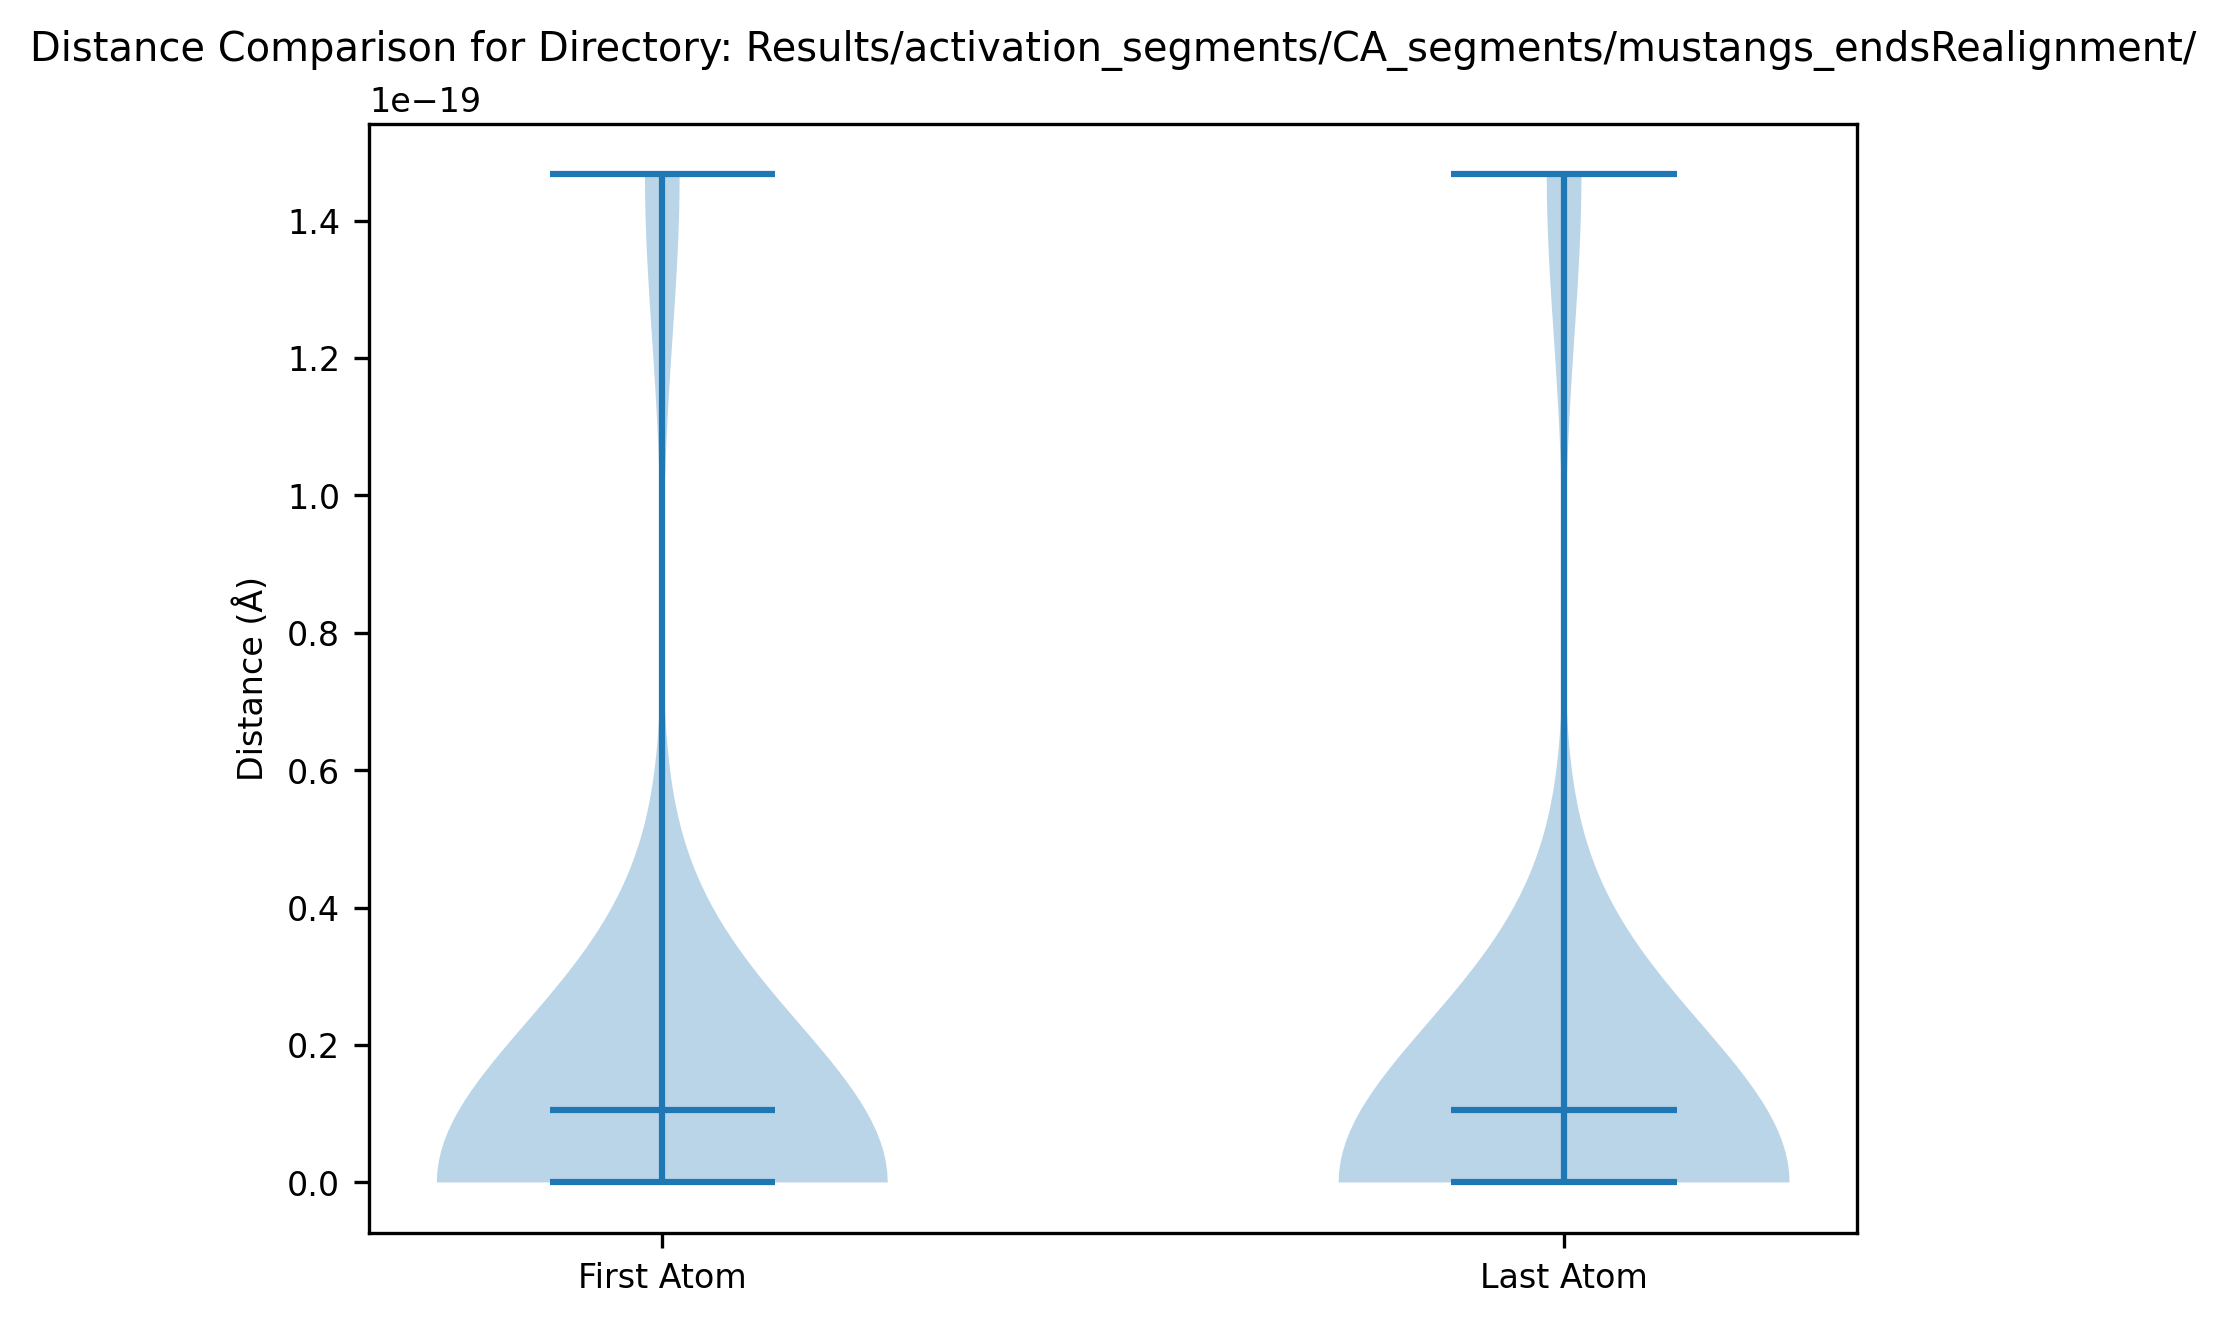


===== Analyzing directory: Results/activation_segments/CA_segments/mustangs_noRealignment/ =====

Processing file: Results/activation_segments/CA_segments/mustangs_noRealignment/5HHW_A.pdb
Details for selection: 5HHW_A_first_atom
Number of atoms in 5HHW_A_first_atom: 0
Details for selection: 5HHW_A_last_atom
Number of atoms in 5HHW_A_last_atom: 0
ExecutiveRMS-Error: No atoms selected.
RMSD for first atom of 5HHW_A vs. reference: 7.978213553623638e-23
ExecutiveRMS-Error: No atoms selected.
RMSD for last atom of 5HHW_A vs. reference: 7.978213553623638e-23

Processing file: Results/activation_segments/CA_segments/mustangs_noRealignment/7M0L_A.pdb
Details for selection: 7M0L_A_first_atom
Number of atoms in 7M0L_A_first_atom: 0
Details for selection: 7M0L_A_last_atom
Number of atoms in 7M0L_A_last_atom: 0
RMSD for first atom of 7M0L_A vs. reference: 1.5620974995818906e-19
ExecutiveRMS-Error: No atoms selected.
RMSD for last atom of 7M0L_A vs. reference: 1.5620974995818906e-19

Processing f

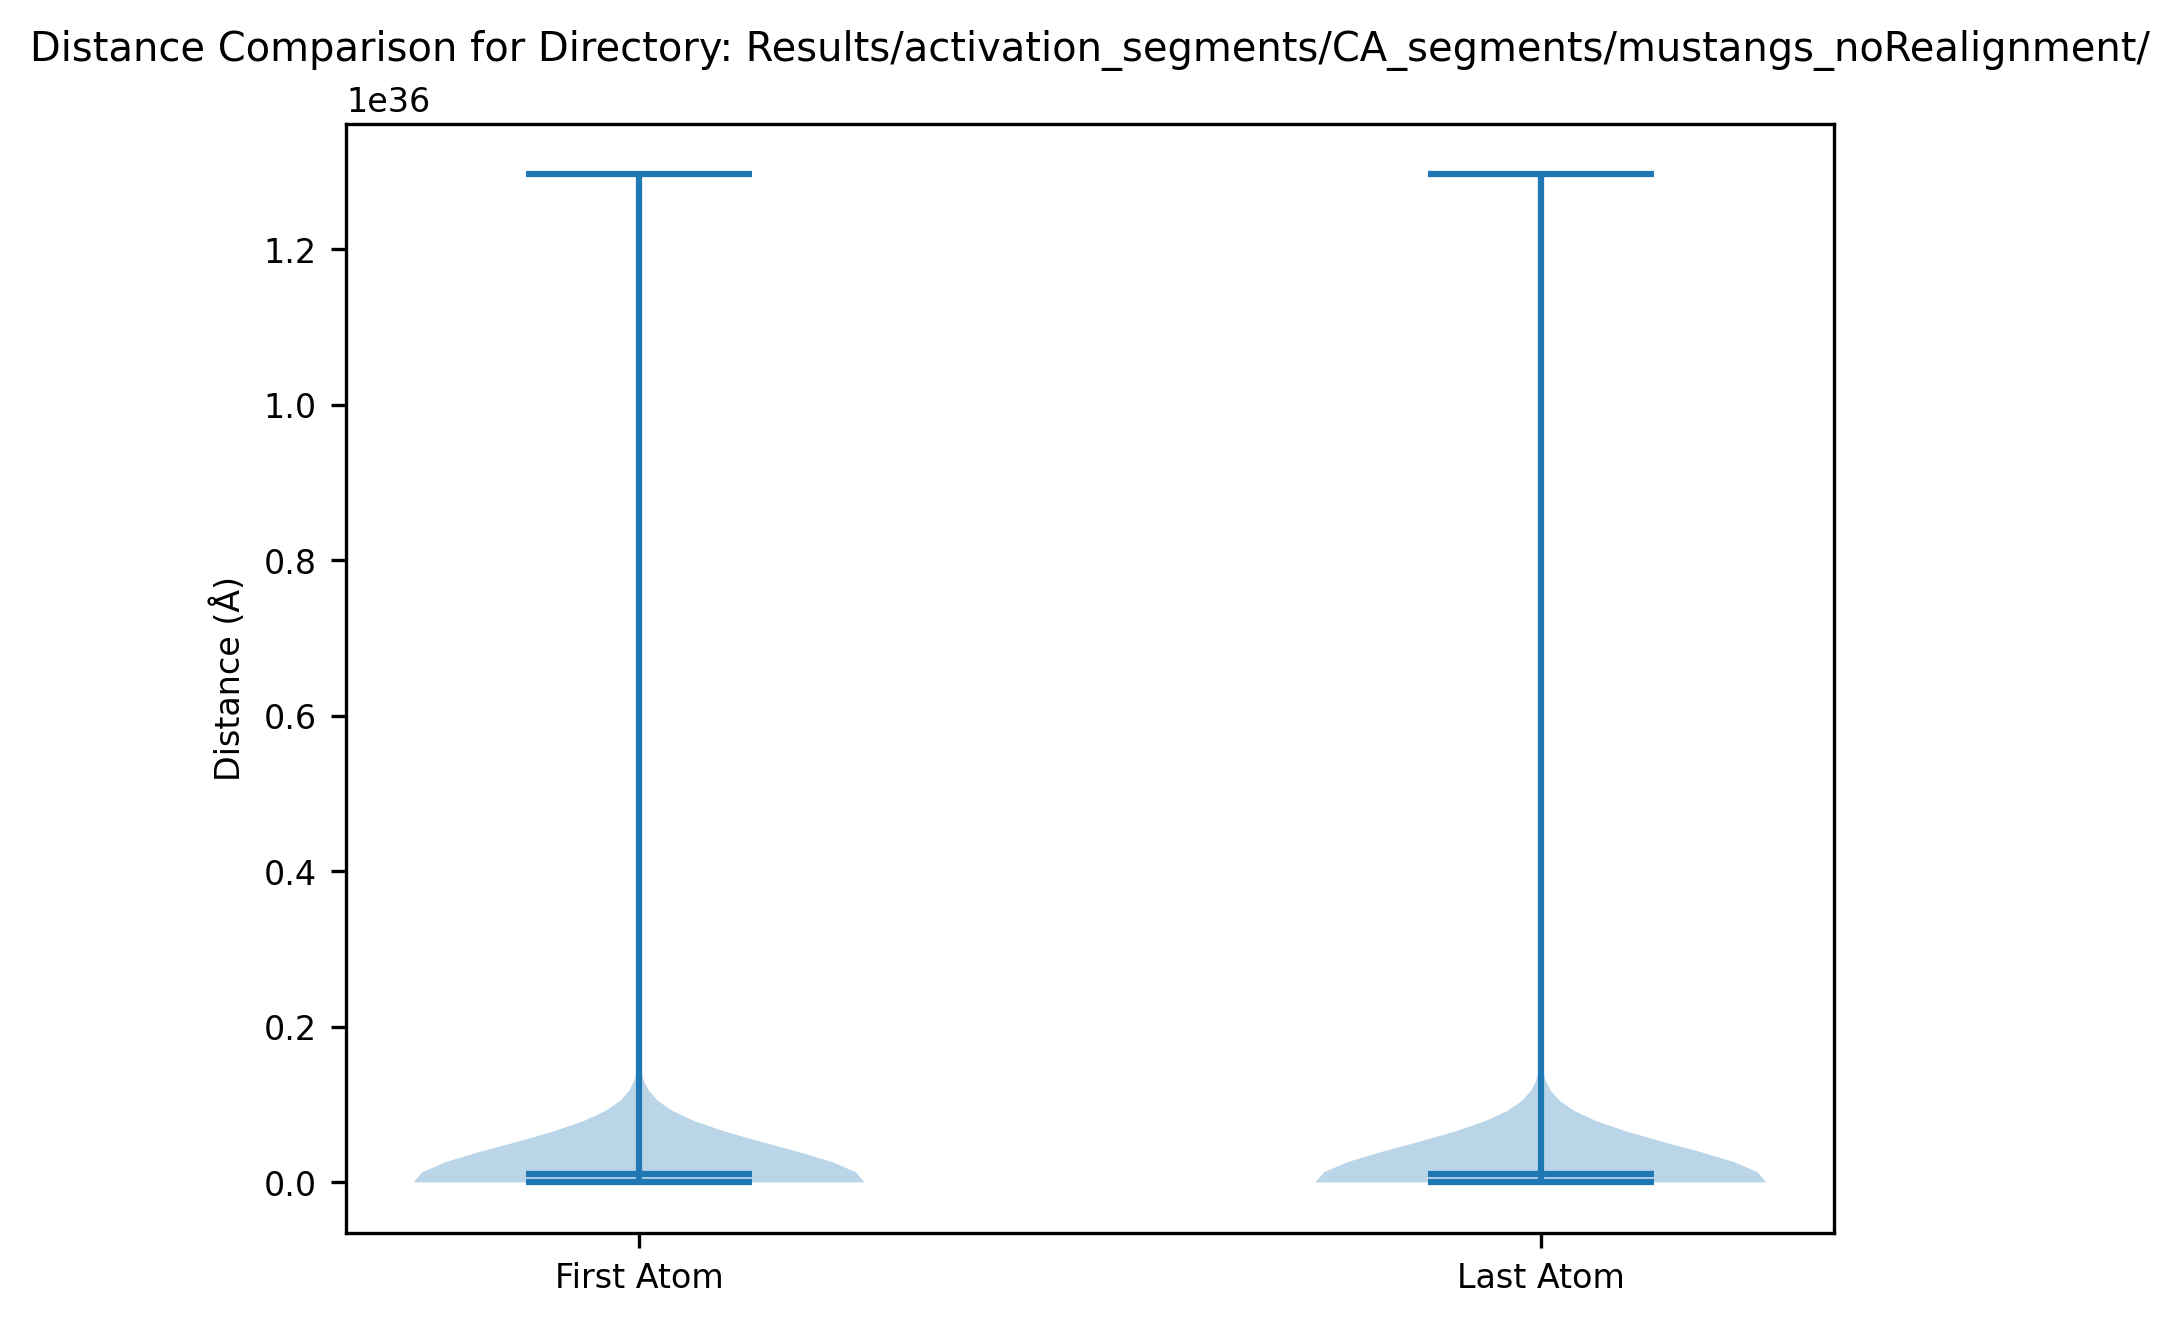


===== Analyzing directory: Results/activation_segments/CA_segments/mustangs_secondaryRealignment/ =====

Structures with distance > 2.5 Å (first atom):
[]

Structures with distance > 2.5 Å (last atom):
[]

Total Structures: 0
Number of structures with distance > 2.5 Å (first atom): 0
Percentage of structures with distance > 2.5 Å (first atom): 0.00%
Number of structures with distance > 2.5 Å (last atom): 0
Percentage of structures with distance > 2.5 Å (last atom): 0.00%


ValueError: zero-size array to reduction operation minimum which has no identity

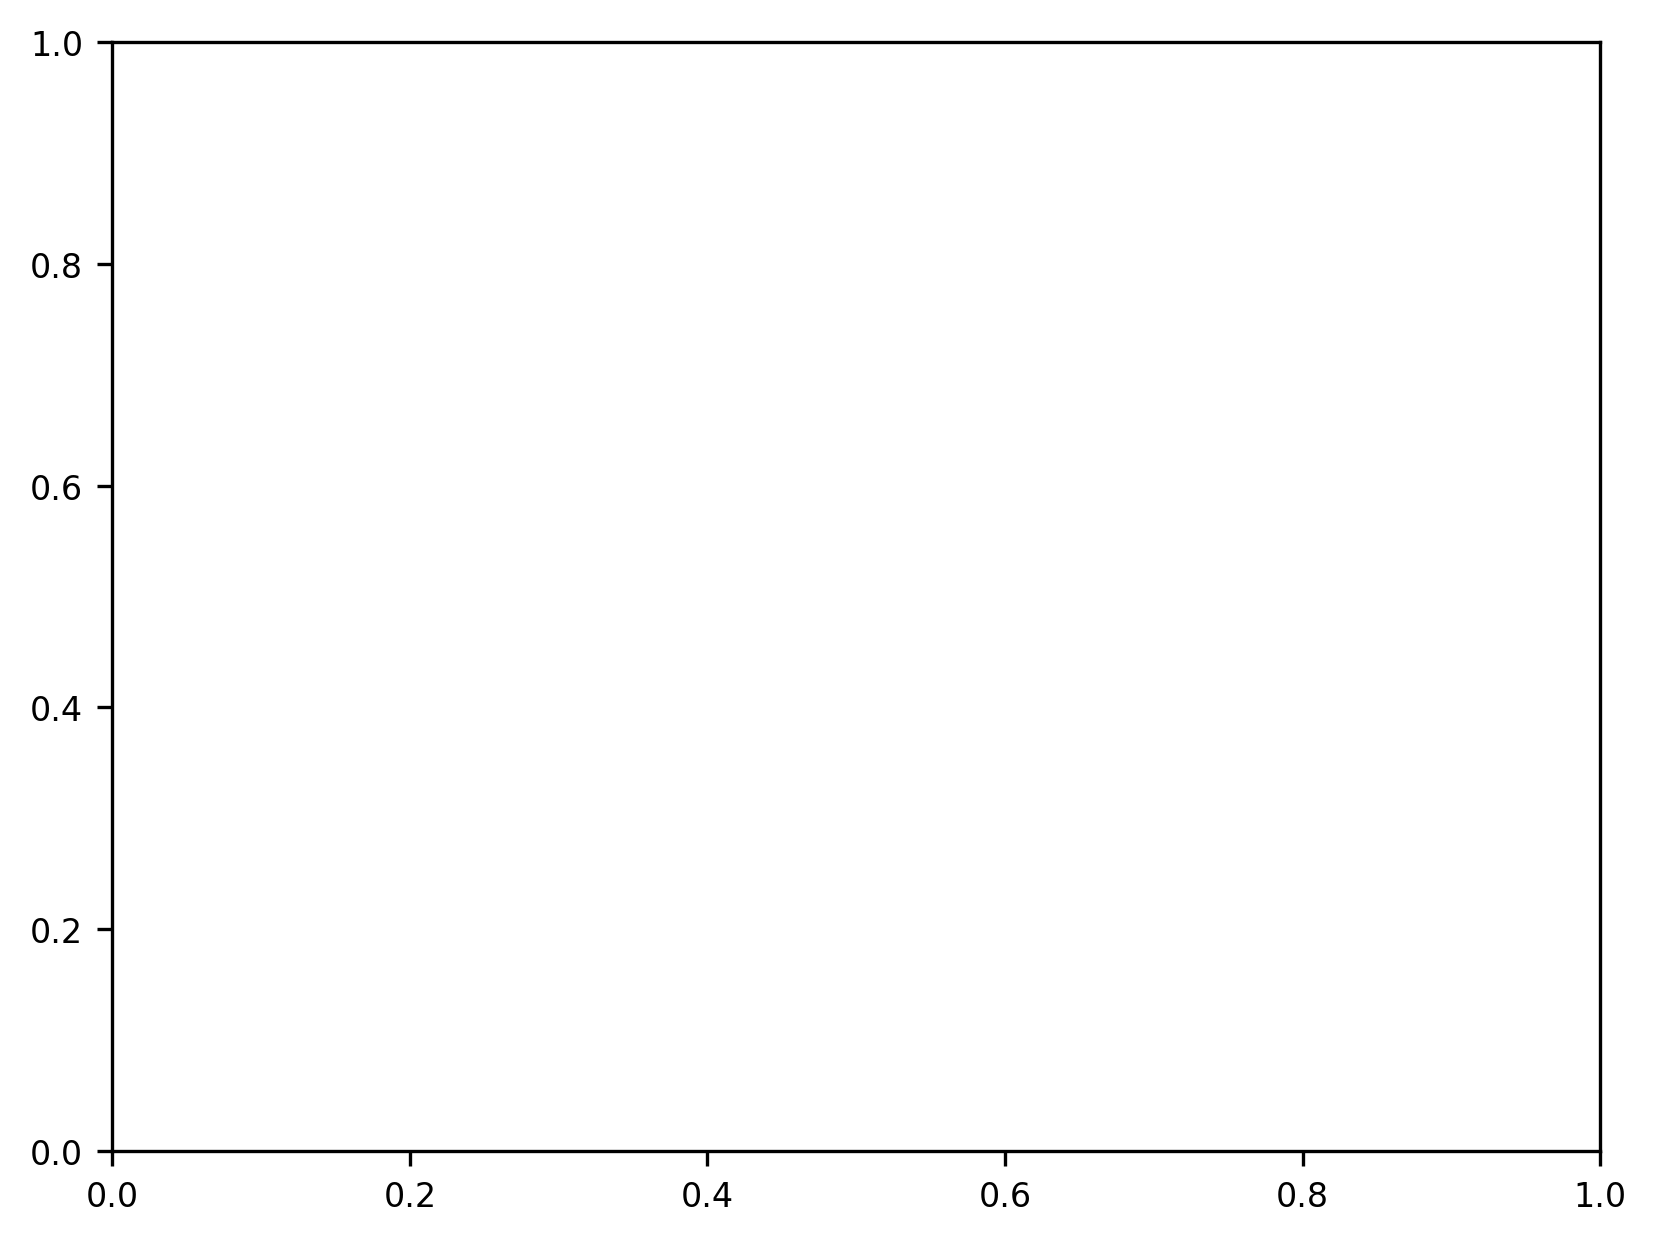

In [13]:
from pymol import cmd
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# Function to print details of a selection
# -----------------------------------------------------------
def print_selection_details(selection_name):
    print(f"Details for selection: {selection_name}")
    cmd.iterate(selection_name, "print(resi, resn, name)")
    count = cmd.count_atoms(selection_name)
    print(f"Number of atoms in {selection_name}: {count}")

# -----------------------------------------------------------
# Paths
# -----------------------------------------------------------
reference_pdb = "/home/marmatt/Documents/projects/BRAF/myWork/reproduceBRAFWork/6UAN_chainD.pdb"

# You mentioned these three directories:
target_dir_realigned = "Results/activation_segments/CA_segments/mustangs_endsRealignment/"
target_dir_no_realign = "Results/activation_segments/CA_segments/mustangs_noRealignment/"
target_dir_second_realign = "Results/activation_segments/CA_segments/mustangs_secondaryRealignment/"

# -----------------------------------------------------------
# Load the reference structure
# -----------------------------------------------------------
cmd.load(reference_pdb, "6UAN_chainD")

# Create selections for the reference structure
cmd.select("6UAN_chainD_first_atom", "6UAN_chainD and resi 594 and name CA")
cmd.select("6UAN_chainD_last_atom",  "6UAN_chainD and resi 623 and name CA")
print_selection_details("6UAN_chainD_first_atom")
print_selection_details("6UAN_chainD_last_atom")

# -----------------------------------------------------------
# Function to run RMSD analysis on a directory of PDBs
# -----------------------------------------------------------
def analyze_directory(pdb_dir):
    print(f"\n===== Analyzing directory: {pdb_dir} =====")

    # Lists to store RMSD values
    rmsd_first_atom = []
    rmsd_last_atom = []
    
    # Keep track of structures exceeding 2.5 Å RMSD
    structures_with_large_rmsd_first_atom = []
    structures_with_large_rmsd_last_atom  = []

    # Gather all fitted PDB files
    pdb_files = glob(os.path.join(pdb_dir, '*.pdb'))
    total_structures = len(pdb_files)

    for pdb_file in pdb_files:
        print(f"\nProcessing file: {pdb_file}")
        pdb_code = os.path.basename(pdb_file).split('.')[0]
        cmd.load(pdb_file, pdb_code)

        # Select the first atom, last atom, first three atoms, and last three atoms of the fitted structure
        cmd.select(f"{pdb_code}_first_atom",     f"{pdb_code} and resi 593 and name CA")
        cmd.select(f"{pdb_code}_last_atom",      f"{pdb_code} and resi 619 and name CA")
        
        # Print details of each selection
        print_selection_details(f"{pdb_code}_first_atom")
        print_selection_details(f"{pdb_code}_last_atom")
       

        # Calculate RMSD for the first atom
        try:
            rms_first_atom = cmd.rms_cur(f"{pdb_code}_first_atom", "6UAN_chainD_first_atom", matchmaker=-1)
            print(f"RMSD for first atom of {pdb_code} vs. reference: {rms_first_atom}")
            rmsd_first_atom.append(rms_first_atom)
            if rms_first_atom > 2.5:
                structures_with_large_rmsd_first_atom.append(pdb_code)
        except:
            print(f"Error calculating distance for first atom of {pdb_code}")

        # Calculate RMSD for the last atom
        try:
            rms_last_atom = cmd.rms_cur(f"{pdb_code}_last_atom", "6UAN_chainD_last_atom", matchmaker=-1)
            print(f"RMSD for last atom of {pdb_code} vs. reference: {rms_last_atom}")
            rmsd_last_atom.append(rms_last_atom)
            if rms_last_atom > 2.5:
                structures_with_large_rmsd_last_atom.append(pdb_code)
        except:
            print(f"Error calculating distance for last atom of {pdb_code}")

    

        # Remove the object from PyMOL session to keep it clean
        cmd.delete(pdb_code)
        cmd.delete(f"{pdb_code}_first_atom")
        cmd.delete(f"{pdb_code}_last_atom")
       

    # -----------------------------------------------------------
    # Summaries
    # -----------------------------------------------------------
    print("\nStructures with distance > 2.5 Å (first atom):")
    print(structures_with_large_rmsd_first_atom)

    print("\nStructures with distance > 2.5 Å (last atom):")
    print(structures_with_large_rmsd_last_atom)

    # Calculate percentage and number of structures with RMSD larger than 2.5 Å
    num_large_rmsd_first_atom = len(structures_with_large_rmsd_first_atom)
    num_large_rmsd_last_atom  = len(structures_with_large_rmsd_last_atom)

    if total_structures > 0:
        percentage_large_rmsd_first_atom = (num_large_rmsd_first_atom / total_structures) * 100
        percentage_large_rmsd_last_atom = (num_large_rmsd_last_atom / total_structures) * 100
    else:
        percentage_large_rmsd_first_atom = 0
        percentage_large_rmsd_last_atom  = 0

    print(f"\nTotal Structures: {total_structures}")
    print(f"Number of structures with distance > 2.5 Å (first atom): {num_large_rmsd_first_atom}")
    print(f"Percentage of structures with distance > 2.5 Å (first atom): {percentage_large_rmsd_first_atom:.2f}%")
    print(f"Number of structures with distance > 2.5 Å (last atom): {num_large_rmsd_last_atom}")
    print(f"Percentage of structures with distance > 2.5 Å (last atom): {percentage_large_rmsd_last_atom:.2f}%")

    # -----------------------------------------------------------
    # Create a violin plot for the RMSD values
    # -----------------------------------------------------------
    data = [rmsd_first_atom, rmsd_last_atom]
    labels = ['First Atom', 'Last Atom']
    fig, ax = plt.subplots()
    ax.violinplot(data, showmeans=True)
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_ylabel('Distance (Å)')
    plt.title(f'Distance Comparison for Directory: {pdb_dir}')
    plt.show()
    
    # Optionally, save the figure instead of showing it:
    # fig.savefig(os.path.join(fitted_pdb_dir, "rmsd_violinplot.png"), dpi=300)
    # plt.close(fig)

# -----------------------------------------------------------
# Main: Run the analysis for each directory of interest
# -----------------------------------------------------------
directories_to_analyze = [
    target_dir_realigned,
    target_dir_no_realign,
    target_dir_second_realign
]

for dir_path in directories_to_analyze:
    analyze_directory(dir_path)

# Once done, you can quit PyMOL:
cmd.quit()
#IT SEEMS TO WRITE ALL FILES, BUT STRUGGLES WITH PYMOL, DOES NOT OPEN IT

In [ ]:
import os
from Bio import PDB
import numpy as np
from scipy.interpolate import interp1d
import tempfile
import mdtraj as md

def fitting_code(fp_or_traj, save_path):
    # Function to read PDB file or trajectory object and get model
    def read_structure(input_data):
        if isinstance(input_data, str):
            # If input is a string, treat it as a file path
            parser = PDB.PDBParser(QUIET=True)
            structure = parser.get_structure('structure', input_data)
        elif isinstance(input_data, md.Trajectory):
            # If input is a trajectory, save to temp PDB and read
            with tempfile.NamedTemporaryFile(suffix=".pdb", delete=False) as tmpfile:
                input_data.save(tmpfile.name)
                tmpfile.close()
                parser = PDB.PDBParser(QUIET=True)
                structure = parser.get_structure('structure', tmpfile.name)
            os.unlink(tmpfile.name)
        else:
            raise ValueError("Unsupported input type. Provide a file path or md.Trajectory.")
        return structure[0]

    # Read the template for CA atoms configuration
    template_model = read_structure('template.pdb')
    Nnew = len([atom for atom in template_model.get_atoms() if atom.get_id() == 'CA'])

    # Read input PDB file or trajectory
    my_model = read_structure(fp_or_traj)
    atom_list = [atom for atom in my_model.get_atoms() if atom.get_id() == 'CA']

    # Coordinates for each CA atom
    avg = np.array([atom.coord for atom in atom_list])
    n = len(atom_list)

    # Fit cubic interpolation for each axis (x, y, z)
    dims = ['x', 'y', 'z']
    fits = {}
    for j, dim in enumerate(dims):
        fits[dim] = interp1d(np.arange(n), avg[:, j], kind='cubic', fill_value='extrapolate')

    # Create a finer grid of points (X) for interpolation
    X = np.arange(0, n - 1, 0.1) 
    # Gradient in each dimension
    dYdX = {dim: np.gradient(fits[dim](X)) for dim in dims}
    # Speed along path (magnitude of the gradient)
    Y = np.sqrt(sum(np.square(dYdX[dim]) for dim in dims))
    # Total arc length (area under the speed curve)
    L = np.trapz(Y, X)

    # Create an evenly spaced set of arc lengths (Li)
    Li = np.linspace(0, L, Nnew)

    # Precompute partial arc length at each step in X
    flen = np.array([np.trapz(Y[:ibig], X[:ibig]) for ibig in range(1, len(X))])

    # For each required point (Nnew), find the corresponding index in X
    pt = np.zeros(Nnew, dtype=int)
    for i in range(Nnew):
        pt[i] = np.argmin(np.abs(flen - Li[i]))

    # Interpolated 3D coordinates for each new point
    new_coords = np.array([[fits[dim](X[pt[i]]) for dim in dims] for i in range(Nnew)])

    # Update the template CA positions with interpolated coordinates
    ca_index = 0
    for atom in template_model.get_atoms():
        if atom.get_id() == 'CA':
            atom.set_coord(new_coords[ca_index])
            ca_index += 1

    # Save the updated structure
    try:
        with open(save_path, "w") as file:
            io = PDB.PDBIO()
            io.set_structure(template_model)
            io.save(file)
        print(f'Successfully saved the structure to {save_path}')
    except Exception as e:
        print(f"Error during file save: {e}")


###############################################################################
# Process two different input/output directory pairs:
#   1) mustangs_endsRealignment
#   2) mustangs_noRealignment
###############################################################################

cases = [
    (
       "Results/activation_segments/CA_segments/mustangs_endsRealignment/",
       "Results/fitted_matlab_segments/mustangs_endsRealignment/"
    ),
    (
       "Results/activation_segments/CA_segments/mustangs_noRealignment/",
       "Results/fitted_matlab_segments/mustangs_noRealignment/"
    ),
    (
       "Results/activation_segments/CA_segments/mustangs_secondaryRealignment",
       "Results/fitted_matlab_segments/mustangs_conserved_secondary/"
    )
]

for input_dir, output_dir in cases:
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    print(f"\nProcessing directory:\n  Input:  {input_dir}\n  Output: {output_dir}")

    # Process each PDB file in the input directory
    for file_name in os.listdir(input_dir):
        if file_name.endswith('.pdb'):
            input_file_path = os.path.join(input_dir, file_name)
            output_file_path = os.path.join(output_dir, file_name)
            fitting_code(input_file_path, output_file_path)


In [ ]:
from pymol import cmd
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

###############################################################################
# Function to print details of a selection
###############################################################################
def print_selection_details(selection_name):
    print(f"Details for selection: {selection_name}")
    cmd.iterate(selection_name, "print(resi, resn, name)")
    count = cmd.count_atoms(selection_name)
    print(f"Number of atoms in {selection_name}: {count}")

###############################################################################
# Function to process a single directory of fitted PDBs
###############################################################################
def process_directory(fitted_pdb_dir, directory_label):
    """
    Processes all PDB files in 'fitted_pdb_dir', measuring:
      - Euclidean distance (single-atom) for first and last CA vs. reference
      - RMSD (3 CA) for first three and last three CA vs. reference
    """
    # Re-initialize PyMOL to clear out any previous state
    cmd.reinitialize()

    # Load reference structure (change path/name if needed)
    reference_pdb = "6UAN_chainD.pdb"
    cmd.load(reference_pdb, "6UAN_chainD")

    # Create selections for the reference structure
    cmd.select("6UAN_chainD_first_atom", "6UAN_chainD and resi 594 and name CA")
    cmd.select("6UAN_chainD_last_atom", "6UAN_chainD and resi 623 and name CA")
    print_selection_details("6UAN_chainD_first_atom")
    print_selection_details("6UAN_chainD_last_atom")

    cmd.select("6UAN_chainD_first3", "6UAN_chainD and resi 594-596 and name CA")
    cmd.select("6UAN_chainD_last3", "6UAN_chainD and resi 621-623 and name CA")
    print_selection_details("6UAN_chainD_first3")
    print_selection_details("6UAN_chainD_last3")

    # Prepare lists to store distances/RMSDs
    euclid_first_atom = []   # single CA (treated as Euclidean distance)
    euclid_last_atom = []    # single CA (treated as Euclidean distance)
    rmsd_first3_atoms = []   # 3 CA
    rmsd_last3_atoms = []    # 3 CA

    # Gather PDB files in specified fitted directory
    fitted_pdb_files = glob(os.path.join(fitted_pdb_dir, "*.pdb"))
    total_structures = len(fitted_pdb_files)
    print(f"\nProcessing directory ({directory_label}): {fitted_pdb_dir}")
    print(f"Found {total_structures} PDB files.\n")

    # Keep track of structures with large distances on first/last CA
    structures_with_large_euclid_first = []
    structures_with_large_euclid_last = []

    # Loop over each fitted PDB
    for fitted_pdb_file in fitted_pdb_files:
        print(f"Processing file: {fitted_pdb_file}")
        pdb_code = os.path.basename(fitted_pdb_file).split('.')[0]

        # Load the fitted structure
        cmd.load(fitted_pdb_file, pdb_code)

        # Selections for single-atom
        cmd.select(f"{pdb_code}_first_atom", f"{pdb_code} and resi 593 and name CA")
        cmd.select(f"{pdb_code}_last_atom",  f"{pdb_code} and resi 619 and name CA")

        # Selections for 3-atom group
        cmd.select(f"{pdb_code}_first3_atoms", f"{pdb_code} and resi 593-595 and name CA")
        cmd.select(f"{pdb_code}_last3_atoms",  f"{pdb_code} and resi 617-619 and name CA")

        # Print selection details
        print_selection_details(f"{pdb_code}_first_atom")
        print_selection_details(f"{pdb_code}_last_atom")
        print_selection_details(f"{pdb_code}_first3_atoms")
        print_selection_details(f"{pdb_code}_last3_atoms")

        # Calculate Euclidean distance (single-atom “RMSD” from PyMOL is effectively the direct distance)
        # 1) First atom
        try:
            d_first = cmd.rms_cur(f"{pdb_code}_first_atom", "6UAN_chainD_first_atom", matchmaker=-1)
            print(f"Euclidean distance (first atom) for {pdb_code} vs. reference: {d_first:.2f} Å")
            euclid_first_atom.append(d_first)
            if d_first > 2.5:
                structures_with_large_euclid_first.append(pdb_code)
        except:
            print(f"Error calculating distance for {pdb_code}_first_atom")

        # 2) Last atom
        try:
            d_last = cmd.rms_cur(f"{pdb_code}_last_atom", "6UAN_chainD_last_atom", matchmaker=-1)
            print(f"Euclidean distance (last atom)  for {pdb_code} vs. reference: {d_last:.2f} Å")
            euclid_last_atom.append(d_last)
            if d_last > 2.5:
                structures_with_large_euclid_last.append(pdb_code)
        except:
            print(f"Error calculating distance for {pdb_code}_last_atom")

        # Calculate RMSD for 3 atoms
        # 3) First three atoms
        try:
            rms_first3 = cmd.rms_cur(f"{pdb_code}_first3_atoms", "6UAN_chainD_first3", matchmaker=-1)
            print(f"RMSD (first 3 atoms) for {pdb_code} vs. reference: {rms_first3:.2f} Å")
            rmsd_first3_atoms.append(rms_first3)
        except:
            print(f"Error calculating RMSD for {pdb_code}_first3_atoms")

        # 4) Last three atoms
        try:
            rms_last3 = cmd.rms_cur(f"{pdb_code}_last3_atoms", "6UAN_chainD_last3", matchmaker=-1)
            print(f"RMSD (last 3 atoms)  for {pdb_code} vs. reference: {rms_last3:.2f} Å")
            rmsd_last3_atoms.append(rms_last3)
        except:
            print(f"Error calculating RMSD for {pdb_code}_last3_atoms")

        # Remove the loaded structure from PyMOL to keep things tidy
        cmd.delete(pdb_code)
        cmd.delete(f"{pdb_code}_first_atom")
        cmd.delete(f"{pdb_code}_last_atom")
        cmd.delete(f"{pdb_code}_first3_atoms")
        cmd.delete(f"{pdb_code}_last3_atoms")

    # Summaries for large distances from single-atom comparisons
    print("\nStructures with Euclidean distance > 2.5 Å (first atom):")
    print(structures_with_large_euclid_first)
    print("Structures with Euclidean distance > 2.5 Å (last atom):")
    print(structures_with_large_euclid_last)

    # Percentages
    num_large_first = len(structures_with_large_euclid_first)
    num_large_last = len(structures_with_large_euclid_last)
    pct_large_first = (num_large_first / total_structures) * 100 if total_structures > 0 else 0.0
    pct_large_last = (num_large_last / total_structures) * 100 if total_structures > 0 else 0.0
    print(f"\nNumber of structures > 2.5 Å (first atom): {num_large_first}")
    print(f"Percentage: {pct_large_first:.2f}%")
    print(f"Number of structures > 2.5 Å (last atom): {num_large_last}")
    print(f"Percentage: {pct_large_last:.2f}%")

    ###########################################################################
    # Plot 1: Single-atom as Euclidean distance (violin plot)
    ###########################################################################
    single_atom_data = [euclid_first_atom, euclid_last_atom]
    single_atom_labels = ["First Atom", "Last Atom"]

    fig_euclid, ax_euclid = plt.subplots()
    ax_euclid.violinplot(single_atom_data)
    ax_euclid.set_xticks(np.arange(1, len(single_atom_labels) + 1))
    ax_euclid.set_xticklabels(single_atom_labels)
    ax_euclid.set_ylabel("Euclidean Distance (Å)")
    ax_euclid.set_title(f"Single-Atom Comparison\n{directory_label}")
    plt.show()

    ###########################################################################
    # Plot 2: Three-atom RMSD (violin plot)
    ###########################################################################
    triple_atom_data = [rmsd_first3_atoms, rmsd_last3_atoms]
    triple_atom_labels = ["First Three Atoms", "Last Three Atoms"]

    fig_rmsd, ax_rmsd = plt.subplots()
    ax_rmsd.violinplot(triple_atom_data)
    ax_rmsd.set_xticks(np.arange(1, len(triple_atom_labels) + 1))
    ax_rmsd.set_xticklabels(triple_atom_labels)
    ax_rmsd.set_ylabel("RMSD (Å)")
    ax_rmsd.set_title(f"Three-Atom Comparison\n{directory_label}")
    plt.show()

    # Finally, remove the reference structure so we can re-run for the next directory
    cmd.delete("6UAN_chainD")
    cmd.delete("6UAN_chainD_first_atom")
    cmd.delete("6UAN_chainD_last_atom")
    cmd.delete("6UAN_chainD_first3")
    cmd.delete("6UAN_chainD_last3")

###############################################################################
# Main script - process both directories
###############################################################################
if __name__ == "__main__":
    # Directories to process
    cases = [
        ("Results/fitted_matlab_segments/mustangs_endsRealignment/", "Ends Realignment"),
        ("Results/fitted_matlab_segments/mustangs_noRealignment/",  "No Realignment"),
        ("Results/fitted_matlab_segments/mustangs_conserved_secondary/", "Secondary structure Realignment")
    ]

    # Process each directory
    for dpath, label in cases:
        process_directory(dpath, label)

    cmd.quit()


In [ ]:
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import mdtraj as md


# Usage Example
xyz = md.load("Results/activation_segments/CA_segments/mustang/1AD5_A.pdb")

DFG = xyz.top.to_fasta()[0].find("DFG")
APE = xyz.top.to_fasta()[0].find("APE")+2
atoms = sum([[atom.index for atom in res.atoms if atom.name == "CA"] for res in xyz.top._residues[:]],[])

coords = xyz.xyz[0,atoms].T
x = coords[0]
y = coords[1]
z = coords[2]
new_coords = md.load("Results/fitted_matlab_segments/mustang/1AD5_A.pdb")

atoms = sum([[atom.index for atom in res.atoms if atom.name == "CA"] for res in new_coords.top._residues[:]],[])
new_coords = new_coords.xyz[0,atoms].T
xp = new_coords[0]
yp = new_coords[1]
zp = new_coords[2]

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot3D(x,y,z, 'blue',marker="o")
ax.plot3D(xp, yp, zp, 'red')
plt.tick_params(bottom=False, top=False, labelbottom=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])